# Characterize C branchpoints and branchpoints missing a -2 T

In [10]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
from scipy.stats import ranksums, fisher_exact
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)
        
primates = {}
with open('../anno/hg19.46way.phylop.primates.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in primates: primates[chrom] = {}
        primates[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
lengths = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end, pos = int(bp), int(start), int(end), int(pos)
        gene = gene.split('.')[0]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        lengths[(chrom, three)] = (end - pos
                                   if strand == '+' else
                                   pos - start)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr9', 137650088, '+', 'ENSG00000130635')


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c3 = np.array([primates[chrom][pos] if pos in primates[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
            c3 = c3[::-1]
        X += [np.hstack([onehot(seq), c1, c2, c3]).reshape(1, L, 7)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 7) (37110, 70, 7)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [11]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

In [12]:
X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

# Examples

Can actually see that many of the C branchpoints have C-rich PPT.
Also seemingly a lot of repeats?

Interestingly many of the no -2 T branchpoints have a TnA available.

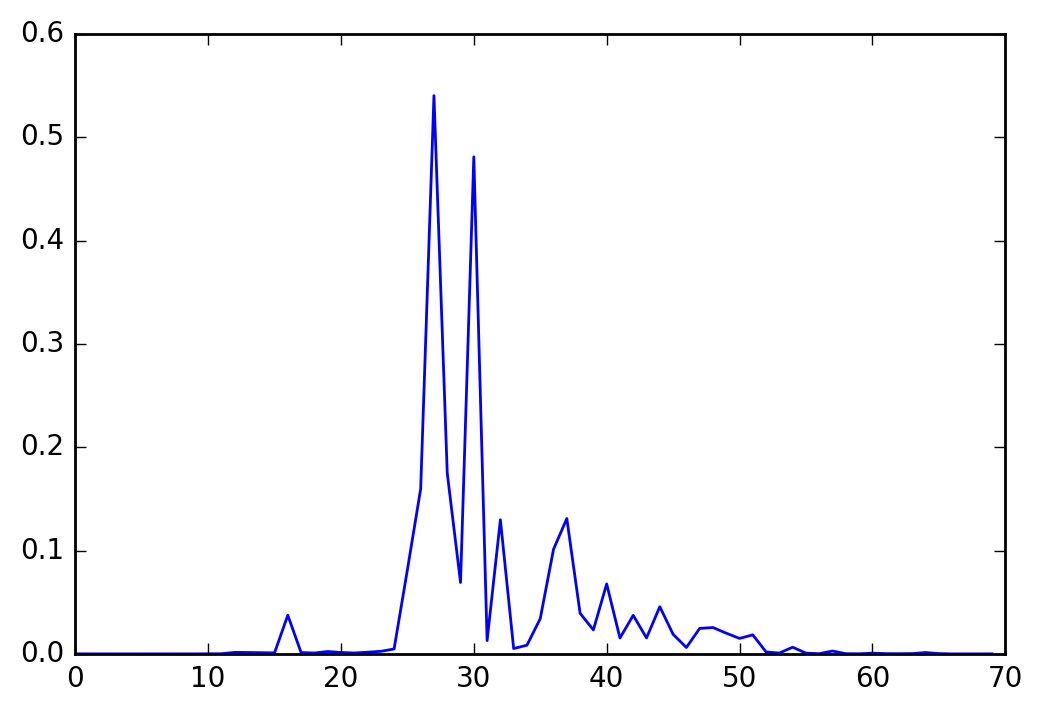

AGGGAGAGGCTGCCTTAGGCCCTGCTACCCACACTGGCCTCTGTGTTTCTGTCTCCTCCTGTCTCCCCAG
___________________________B


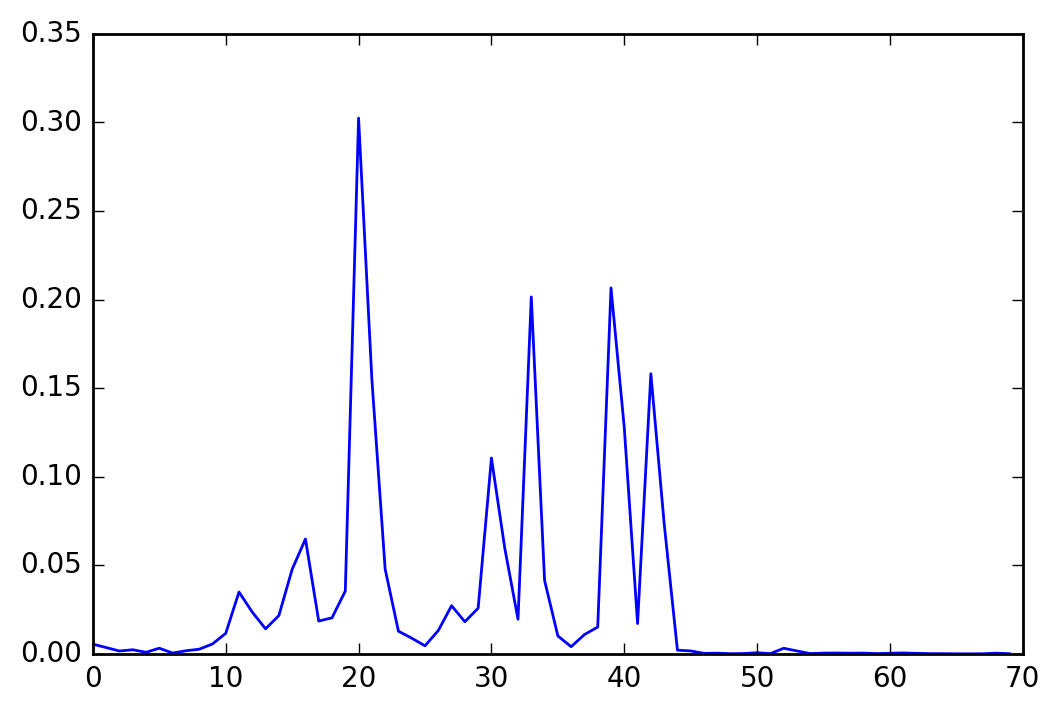

GTCTCCCTGTCCCTGCGTCTCCCGTCTGTGCCTCCCTCTCCTCCCCGTCTCTCCCGGCCCGGGCGCTCAG
____________________B


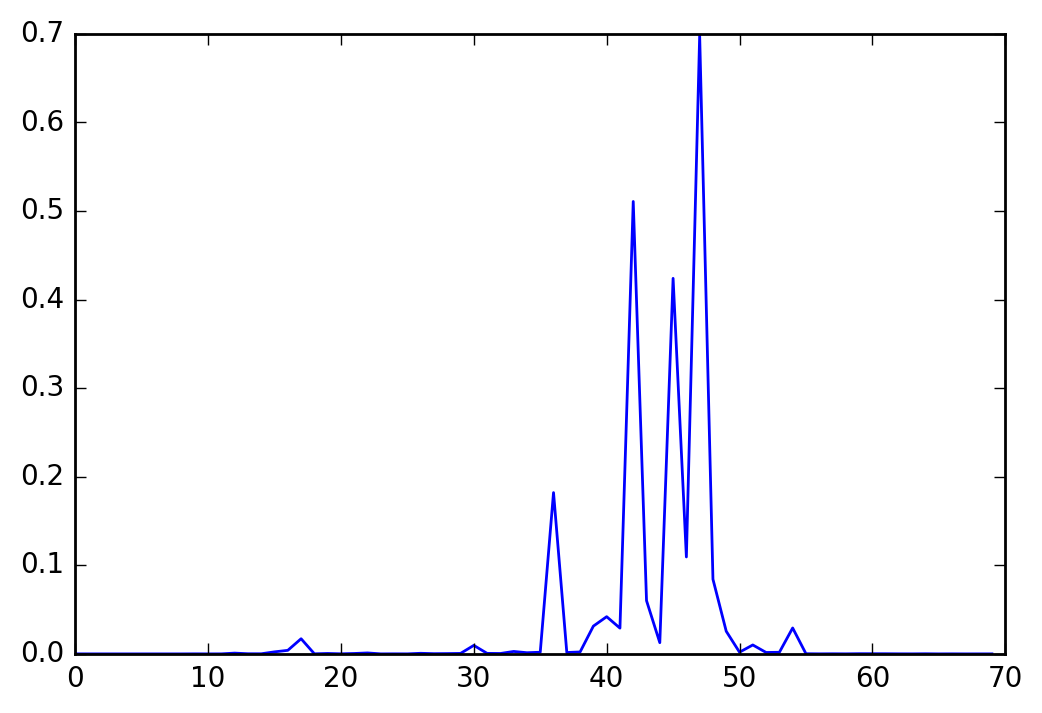

AAACACATCATCACCTAAGAGAAGCTTGTGACTCTCATTCCCAGCTGCCCTCCTATTCTTTCCTCTATAG
_______________________________________________B


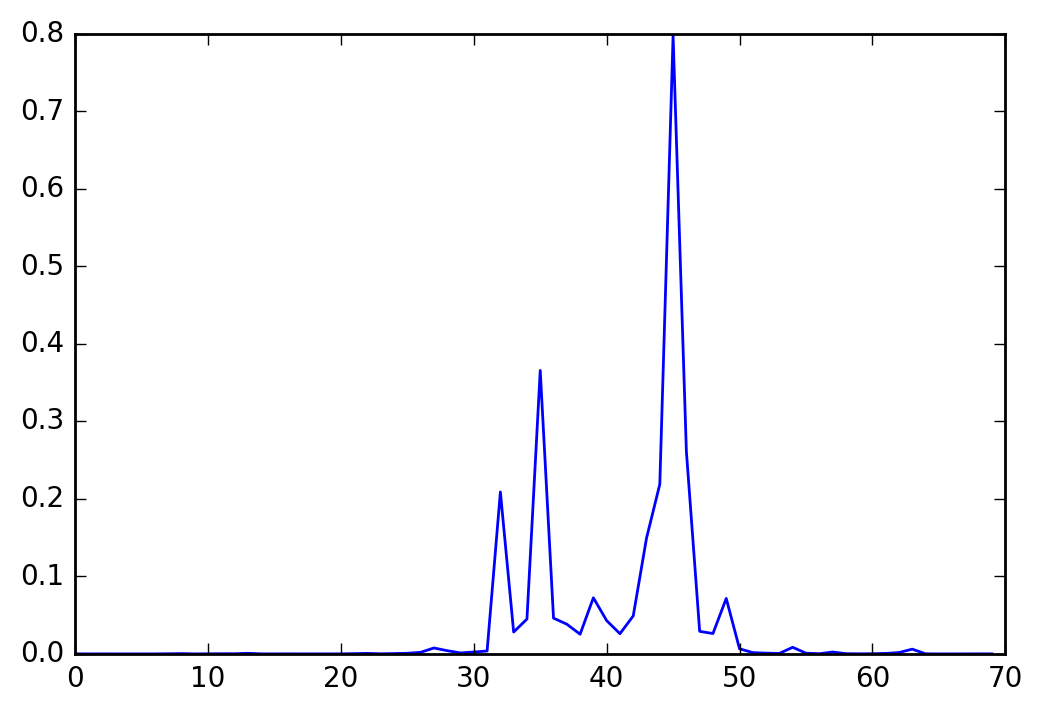

CGCGTGGAAGCGGAGGGGTCTCGCTGGGCCCCAGCACCCCGTCTTCCTTCCGTTCCTCCTCTGCCTGCAG
_____________________________________________B


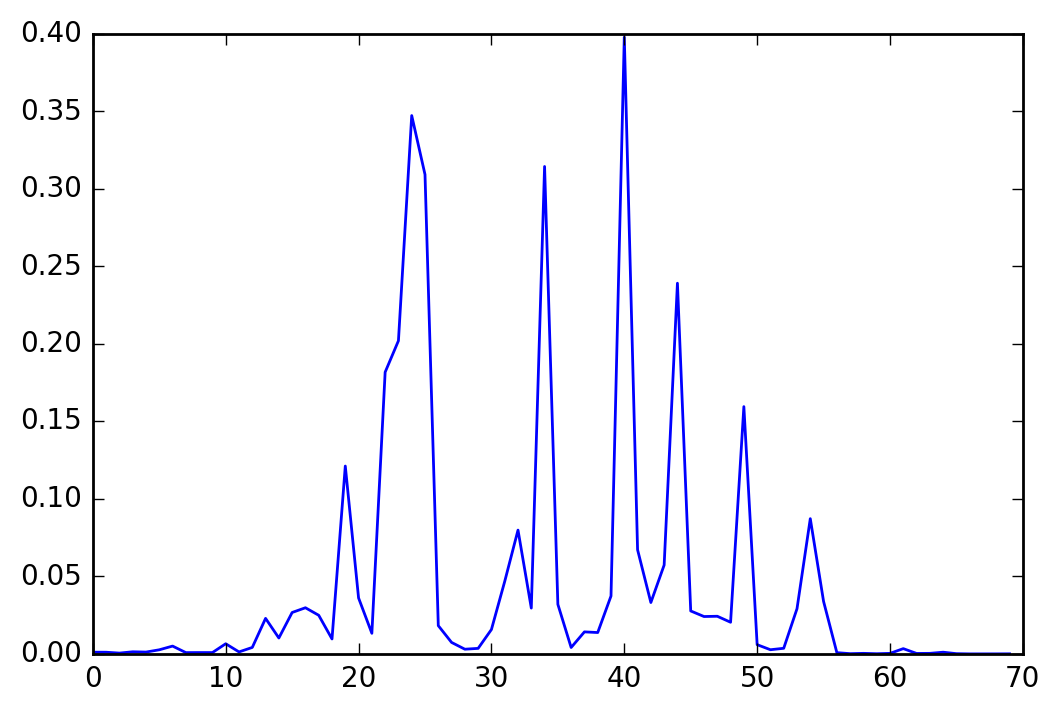

TTGAAAACCTCTTGTCCCTCCTCCACCCTTTCCTCCTCTTCCTTCCCCCATCCTACCTCTTCCTGTCCAG
________________________________________B


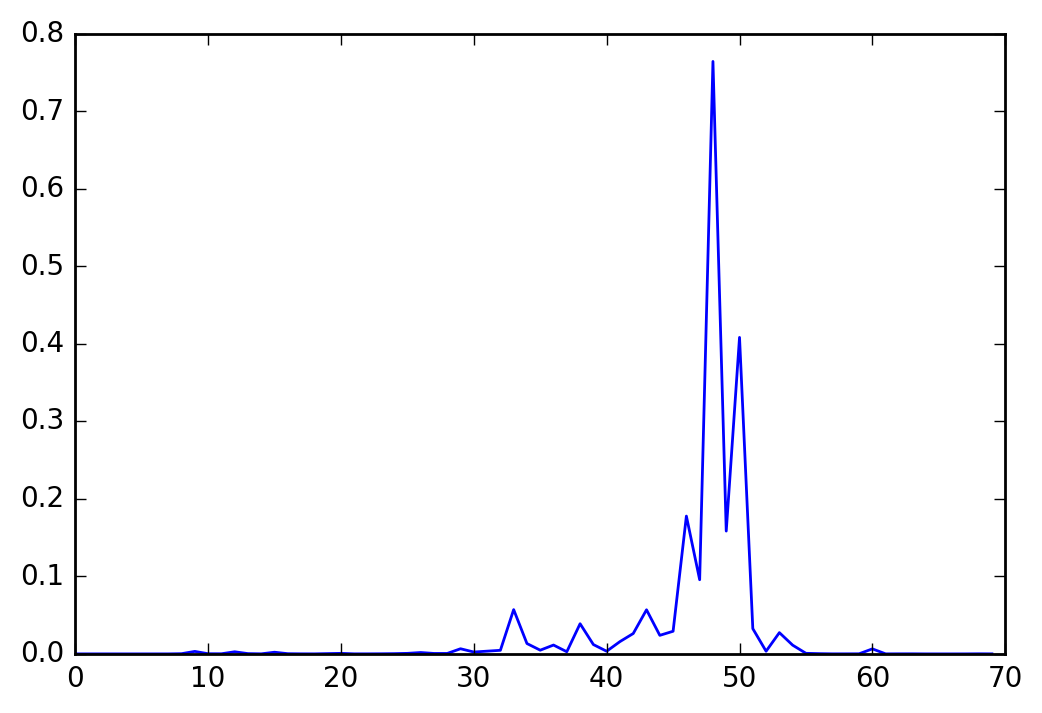

TAAGGTTTCATGAGGAATGGATGGCTCTGGGTGAGGTGCCTGGCCCTGCCACTCGTCTTCATTTCTGCAG
________________________________________________B


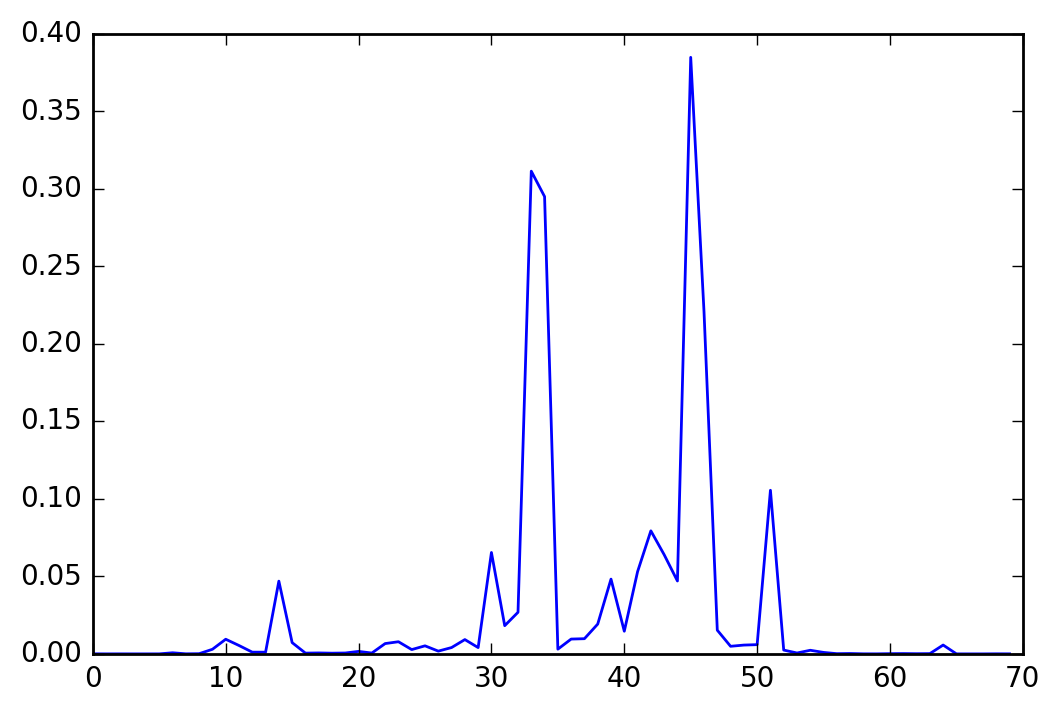

ATATTCATTAAACGAATGTTTTGGTCTTTTCCCAATCCTGTGTCTCCTTTTACTTTTCCTTTTCATTCAG
_____________________________________________B


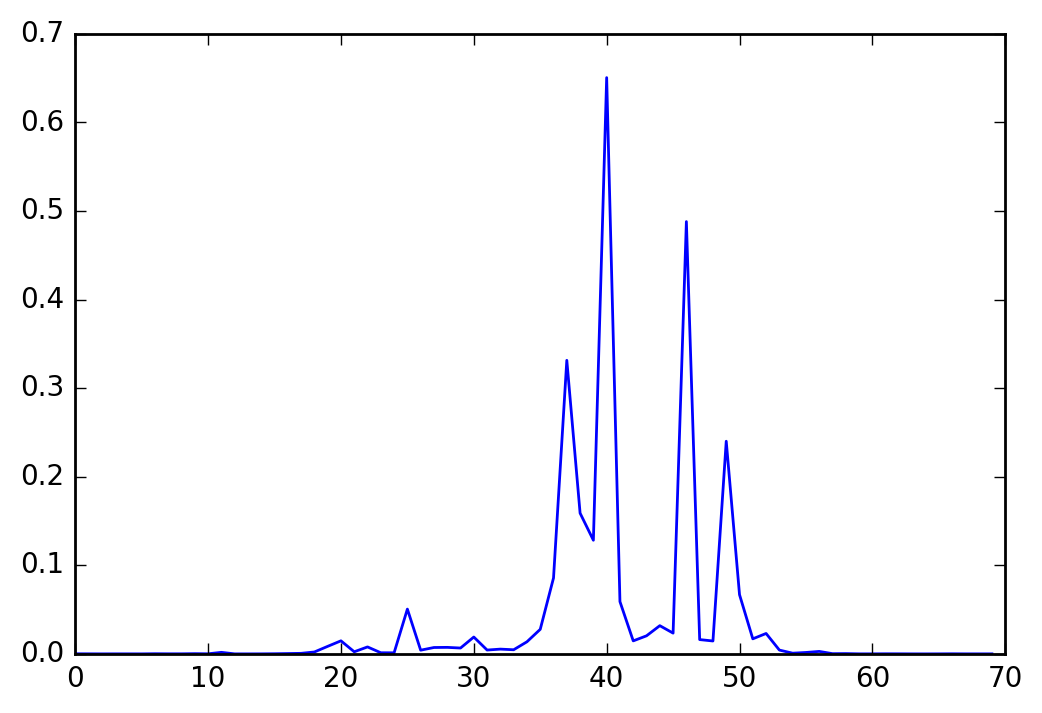

GGTTCTCGCGGACCTTTTTCCGTGTAGCTTTCTGCTTCTTCCCGGCATTCCTGTTTCCGTTTTCTCACAG
________________________________________B


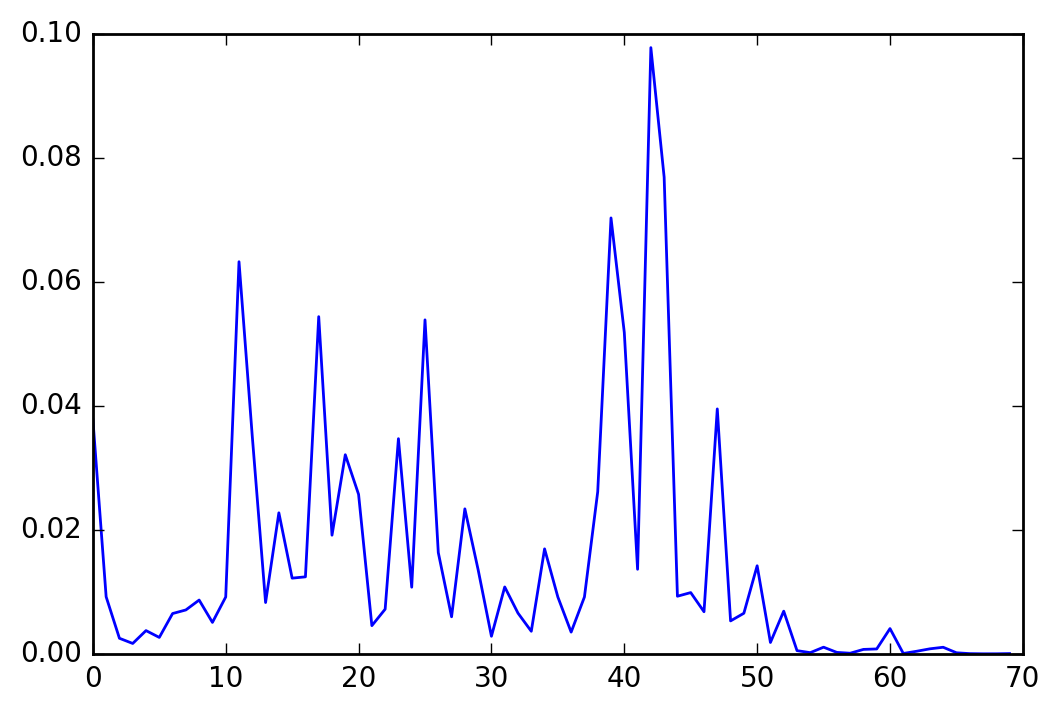

CCTTTTCGTTTGTTTTTGTGTTTGTGTTGTTTTTGTTTTCCTCGCTTTCTCTCTTGGTGGACTGTCCCAG
__________________________________________B


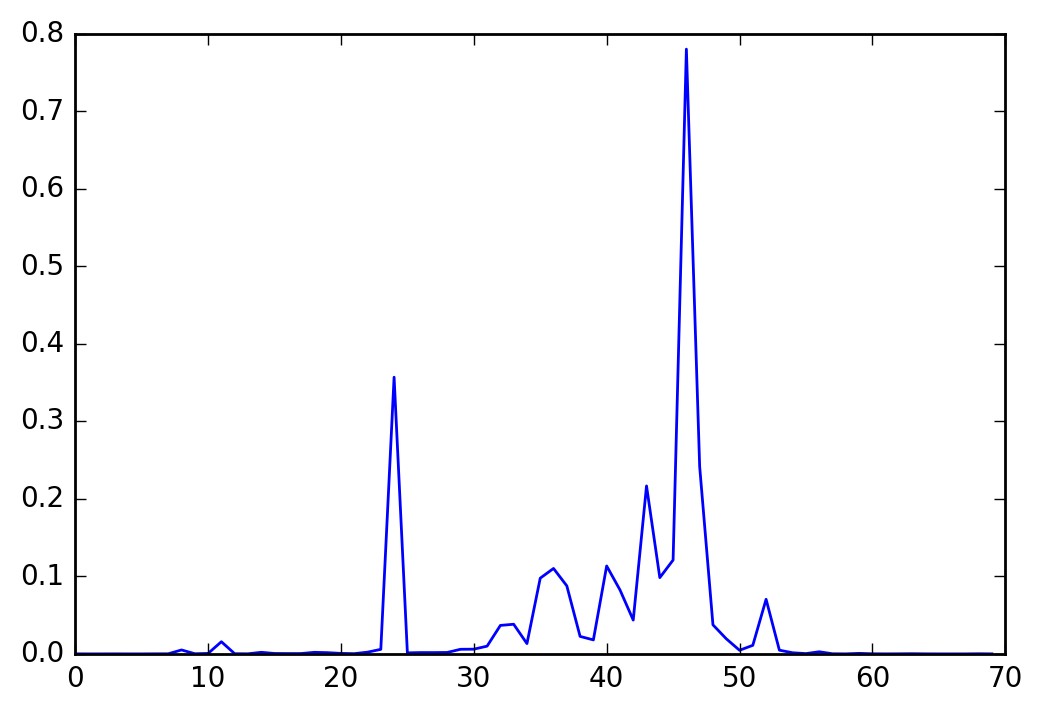

TGAAGCTCAGCAGCTGTGGGTTGGACGGTGGTGTTGGCTTGCTCTTCCCCTTCCCTCCTGGTTTCTTCAG
______________________________________________B


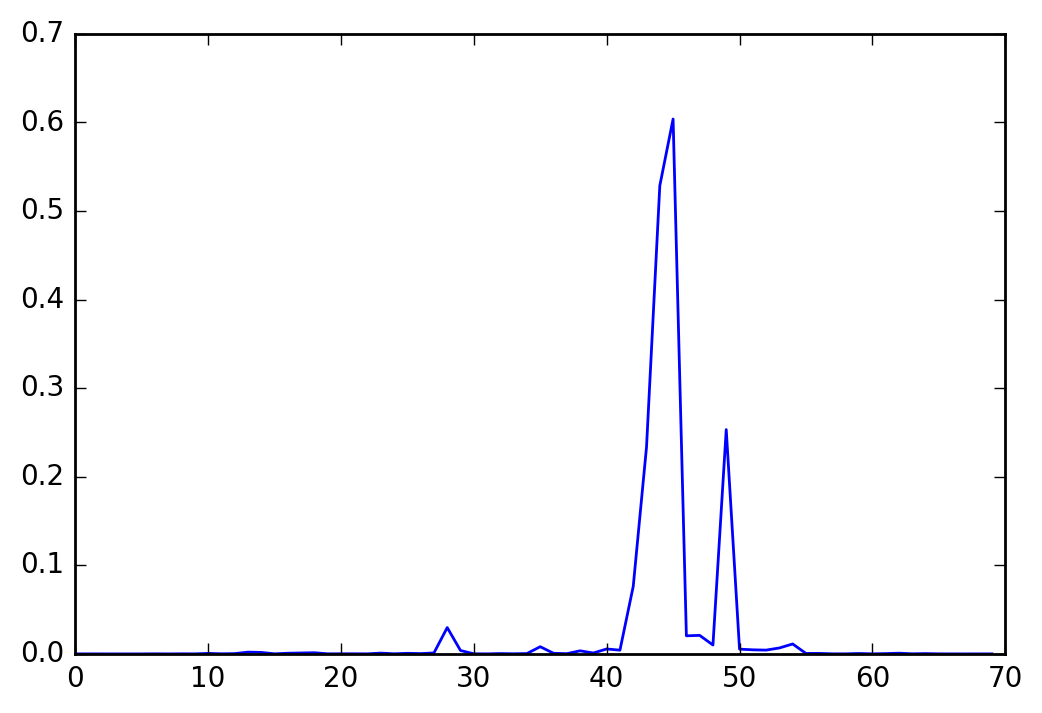

GTGTTTTGTGCCCAAGAAACCCTGGTGCAACTTCTATGGGTGCTCCTGGAGCTTCTGTTCTTCTCTCTAG
_____________________________________________B


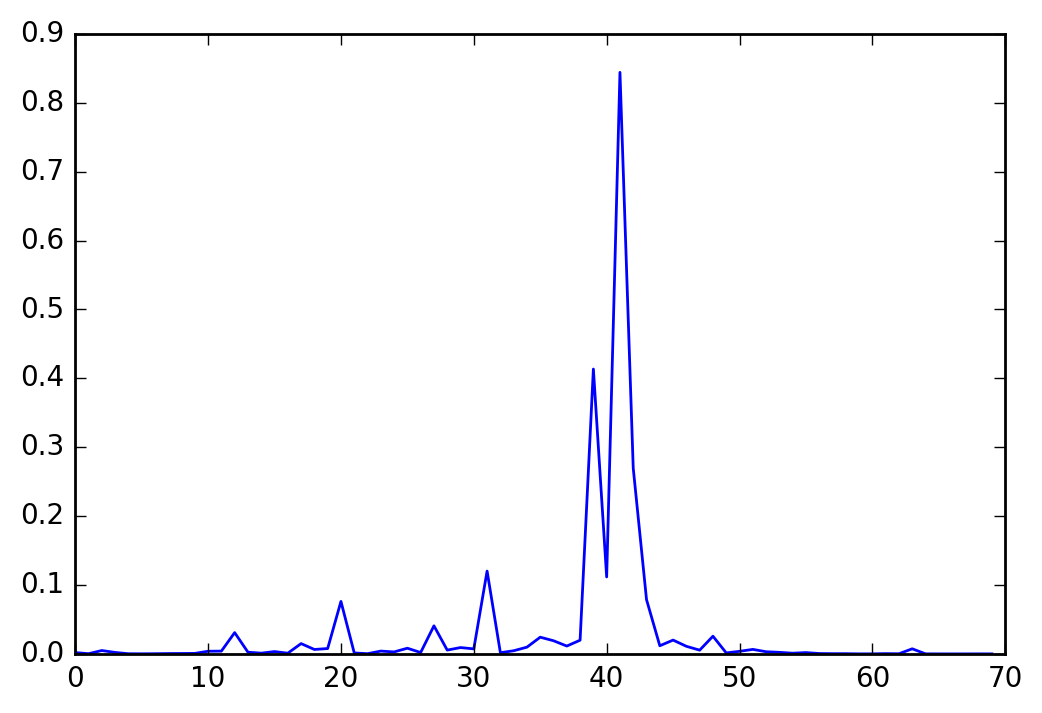

CCAATGTCTTTGCCTCTCCCATGGGTGCCCCATCCCCGCTGCCCGCCTCTGGTCTCCGTCTGTATGTCAG
_________________________________________B


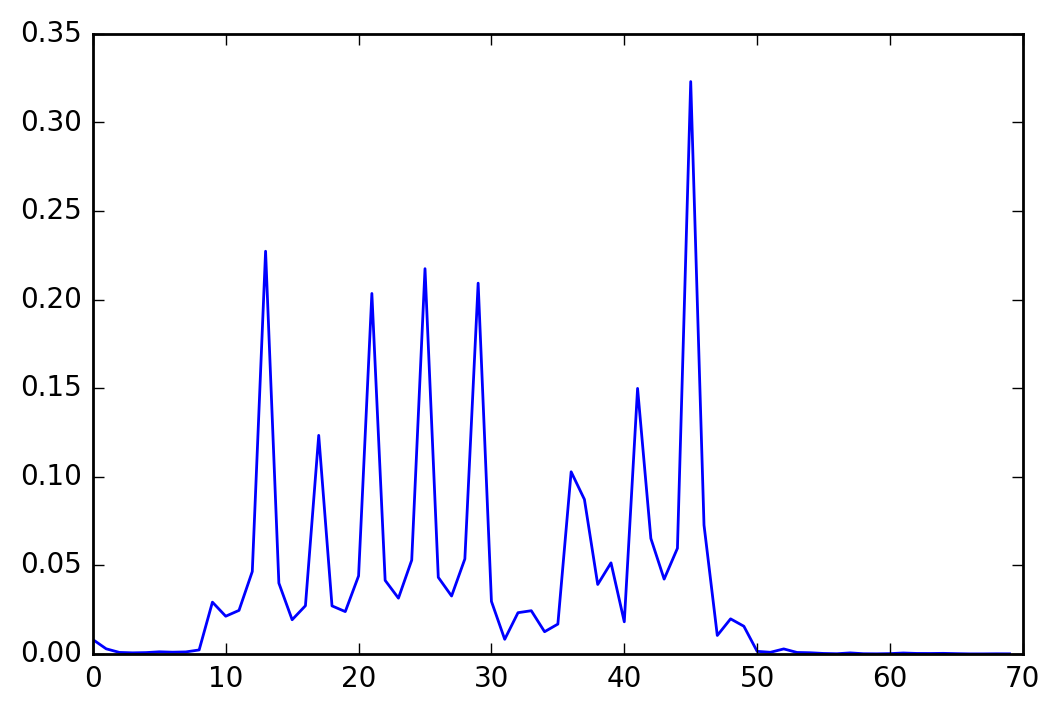

TCCTTCCTTCCTTCCTTCCTTCCTTCCTTCCTTCTTTCCCTCCTTCCTTCTTTCCCTCCTTCCTTCTCAG
_____________________________________________B


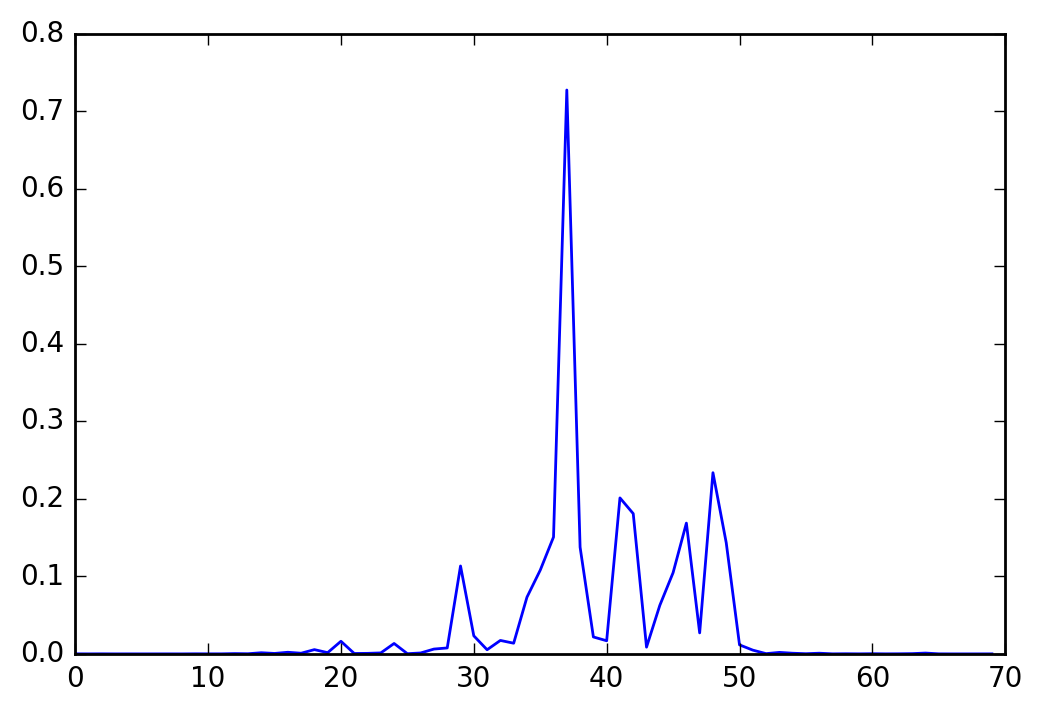

CTGGTGCGCTGTCGCGCTCCAGGGATCCTCCCGGCTTCCCCAATCCCTCCCCTTCTCTGCGTTTCCCCAG
_____________________________________B


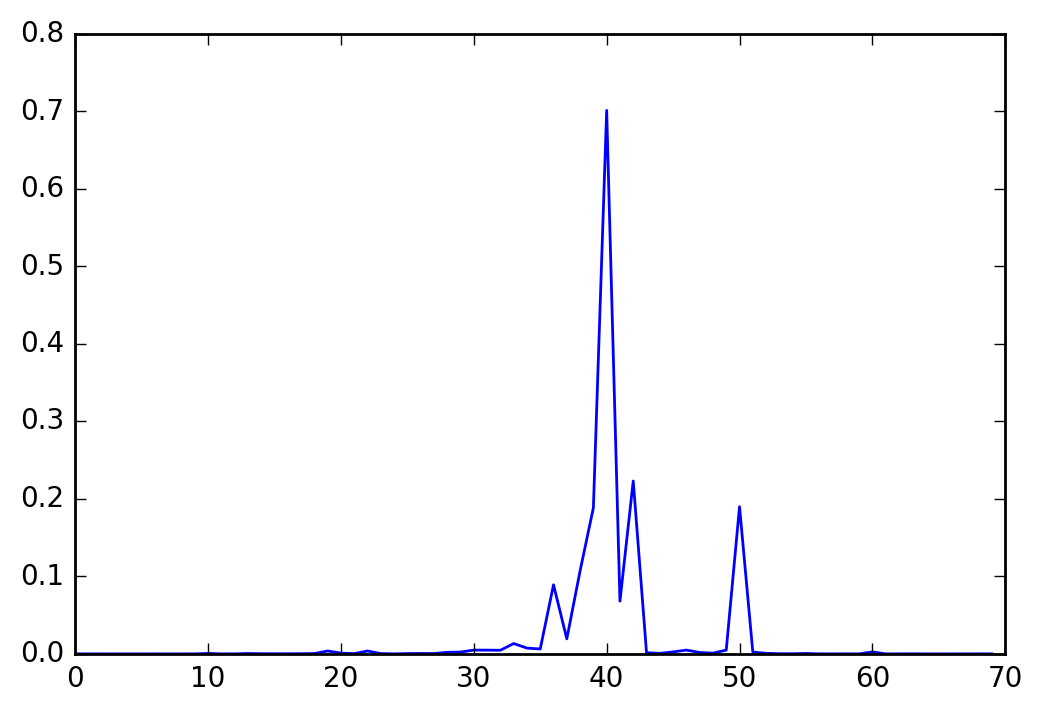

AAACCCTCTGACTTGTGCTAGGAATCGTGCTTTGTTACTTCCATGGGTTTATCTTGTTTCATTCTTGCAG
________________________________________B


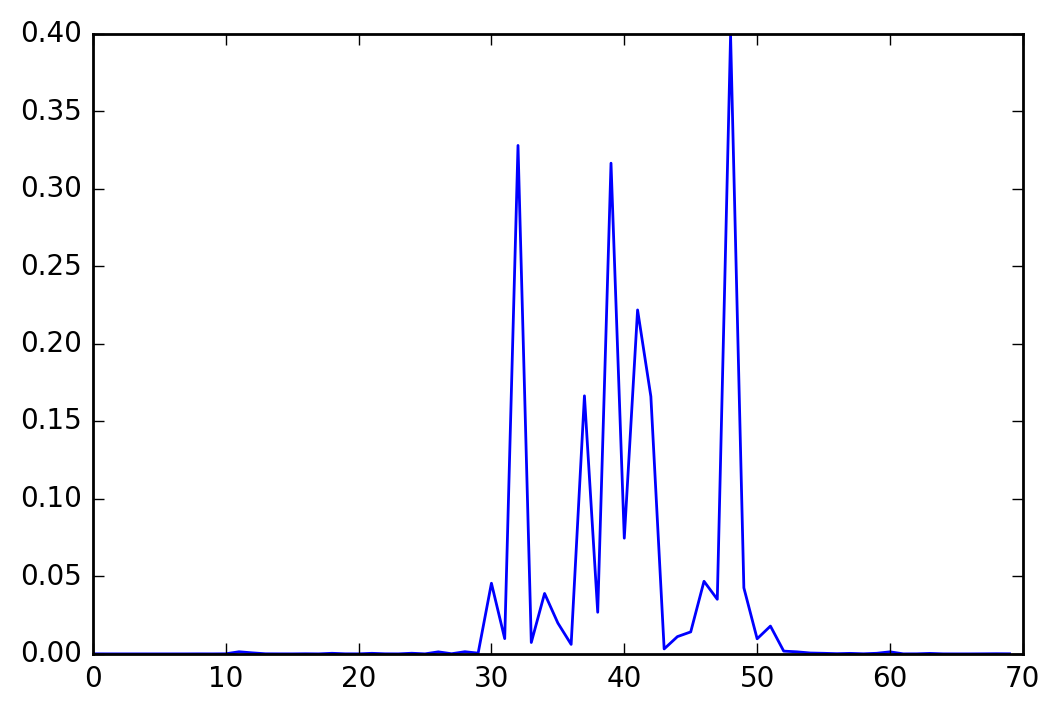

AGGCCTTTTTTACGTTCCTGCAACATTGTCTGAGAAGACAAAATGGTTCCTCTCTCTGTGATTCTTGCAG
________________________________________________B


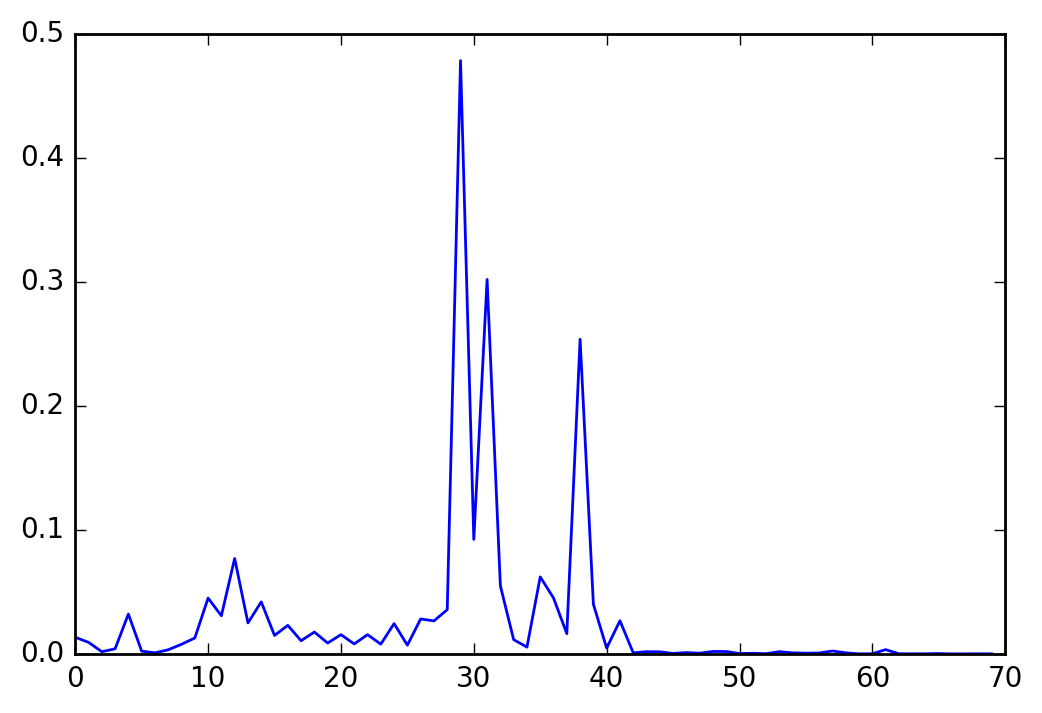

TTCTATTTCTCTCTCTCTCTCTCTCTCTTCCACCTCCTCCTCTTTTCTTCTCTCCCCACCCATCTCTTAG
_____________________________B


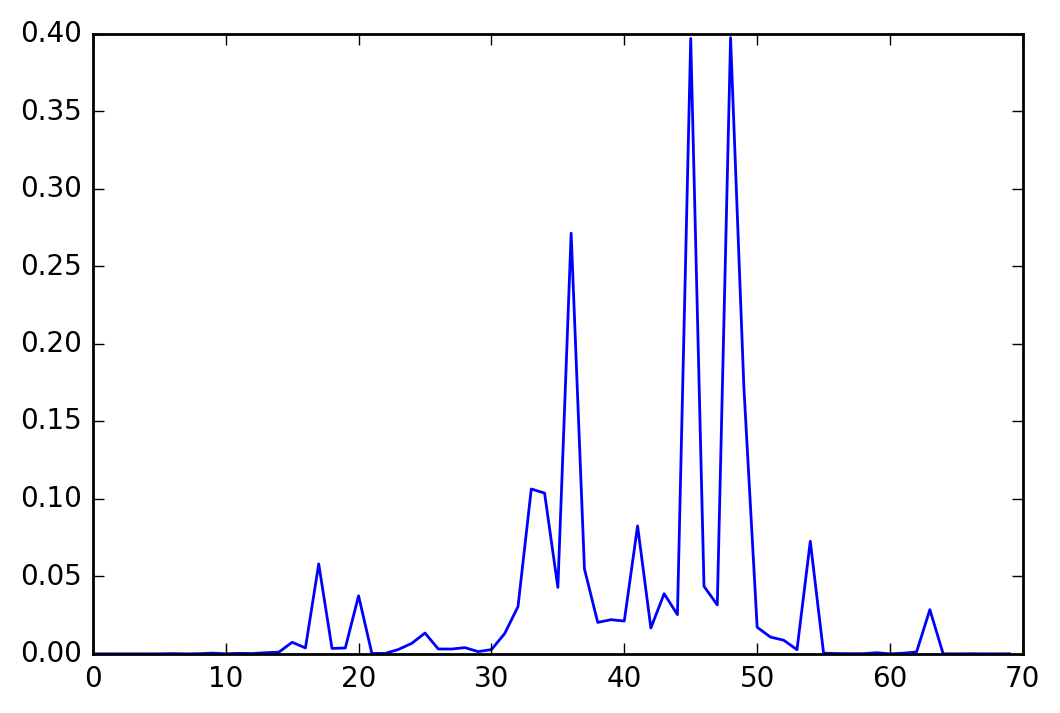

CAGGGGAGGATGGTCTGCCCATTGGCCCGTTGCTGTGTCCTGTGTATTCCTTTCATCTTTCTCATTATAG
________________________________________________B


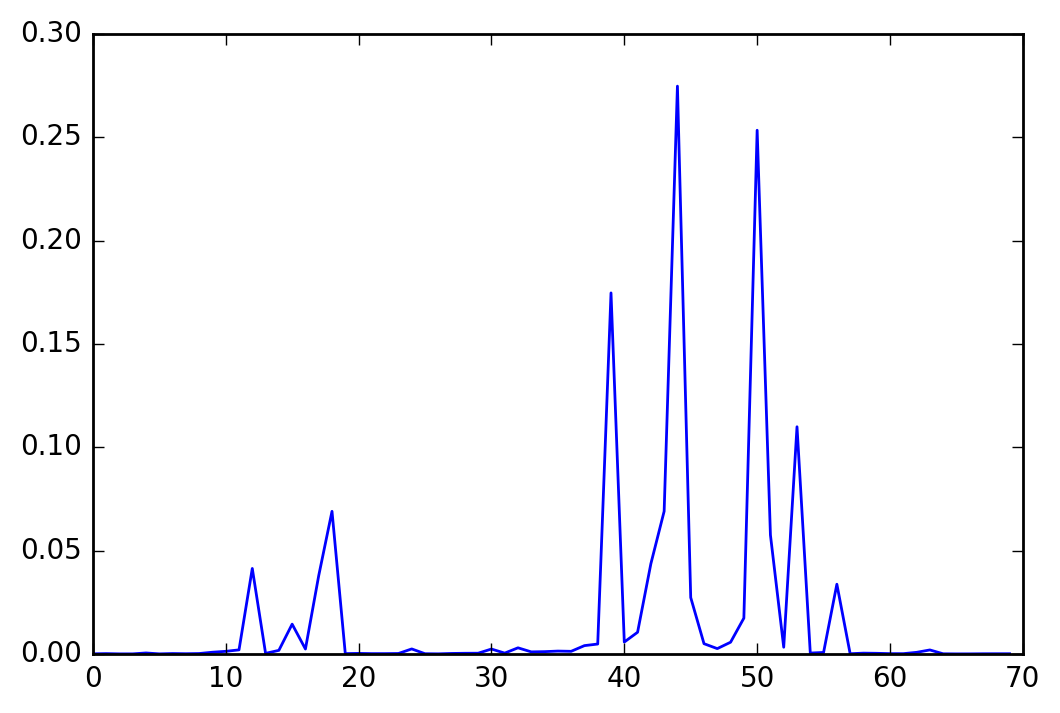

TCCTAGTGTCCCATTATAATCTTTACTTGCATATCCTGGAGCTTCCTGGGAACATTATGGCTTGTTGCAG
____________________________________________B


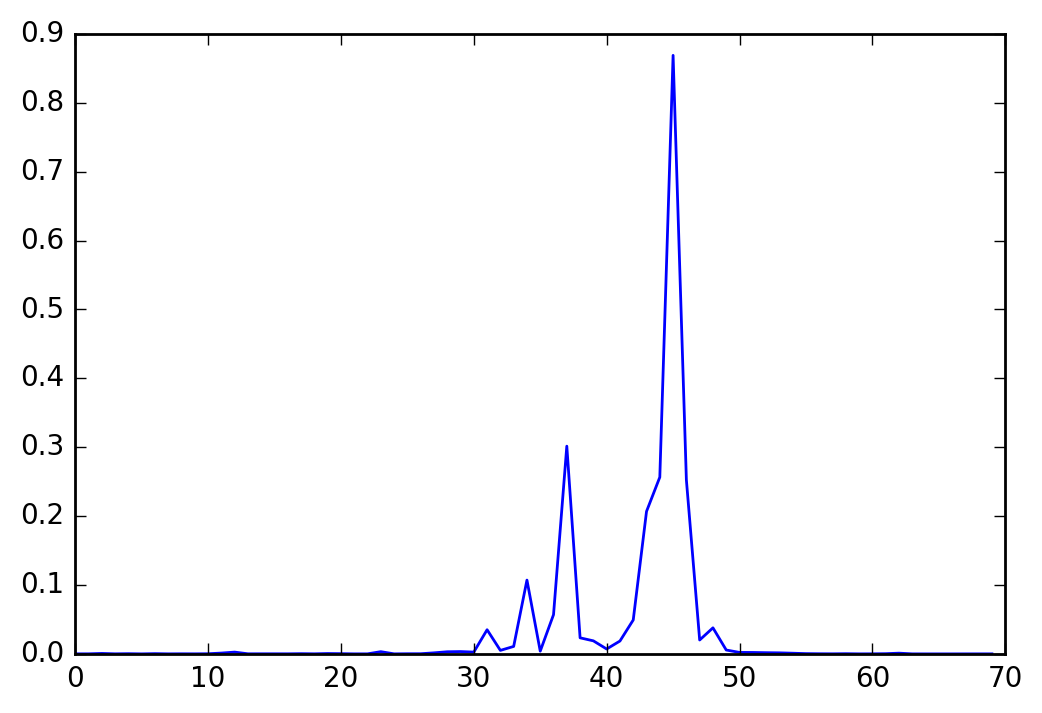

GCACACAGGCTCCCTCTCTCCCCAGTGGGCTAGGAGCACCTTCTTCCTCTTTGTCCTTTCTTCTCGACAG
_____________________________________________B
3352


In [10]:
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 1]: continue
    total += 1
    if total > 20: continue
    plt.plot(target)
    plt.show()
    print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :4]))
    print '_'*bp + 'B'
print total

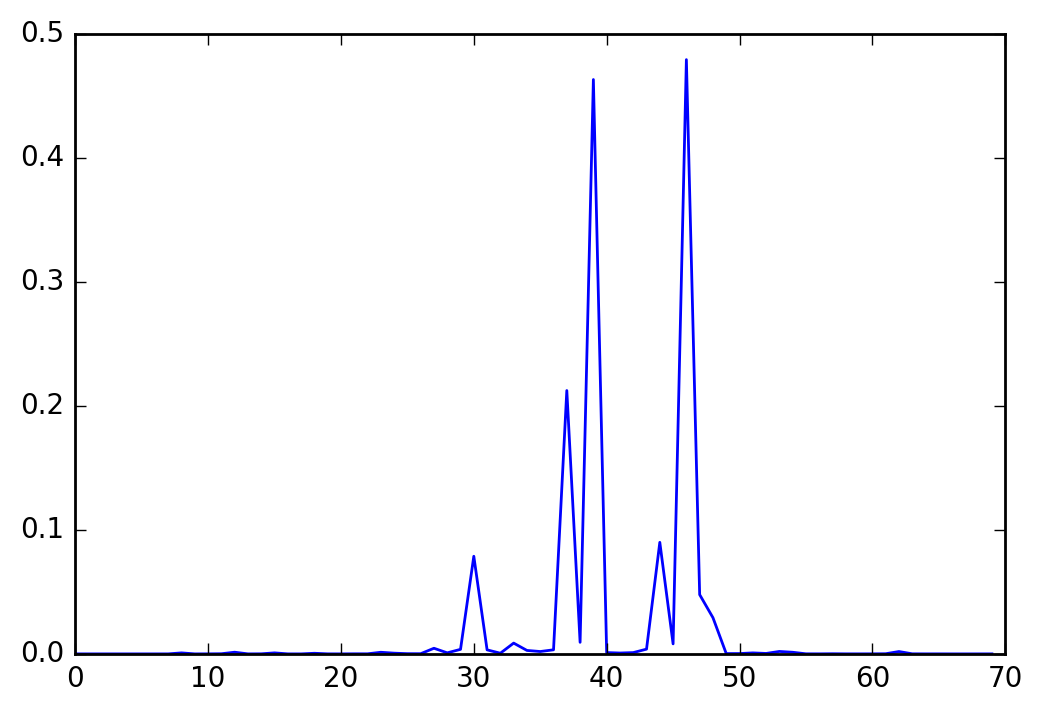

ACAGGTTAAGTAAGCATCAGTTCTGTTACTATTAGTTACATTCTATAAATTCTCCCTGTTTTATTTCTAG
______________________________________________B


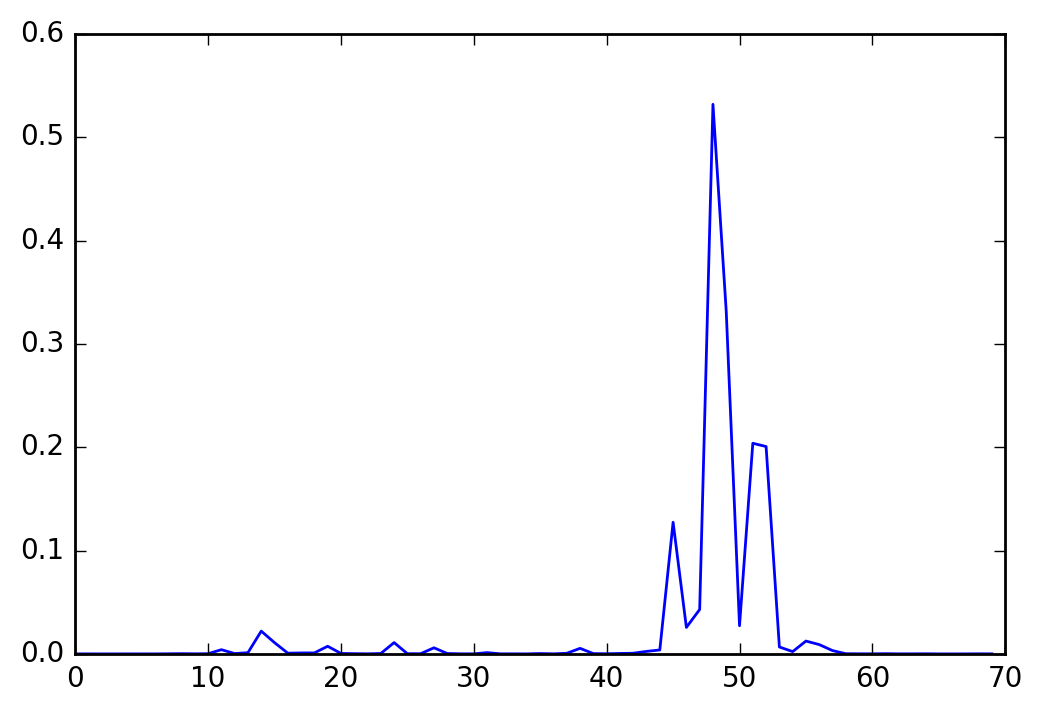

ATGCTGCAAGGATTACCCCACCCTATTACTTGGTTTGCATGGGGGACGAATAAGCTGTCTTTCTCTGCAG
________________________________________________B


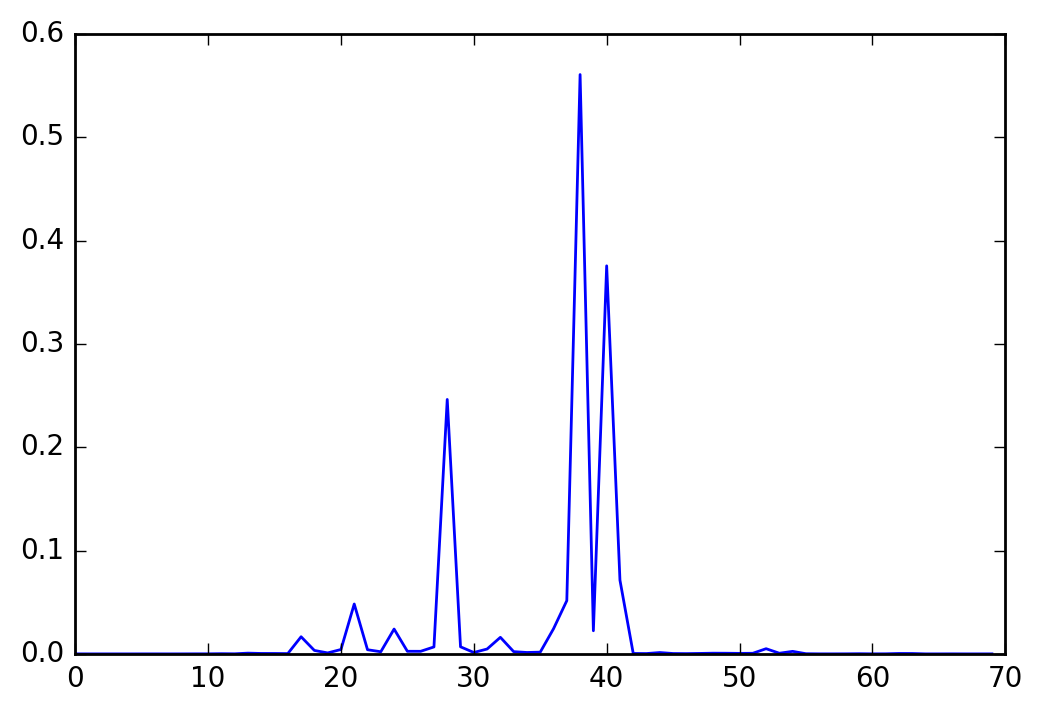

TCTCTTGTTGCTTTGTCAATGATGATTTACCTGTCTCCACAATTGTTTTCTTCCACCTTCCTTTTGAAAG
______________________________________B


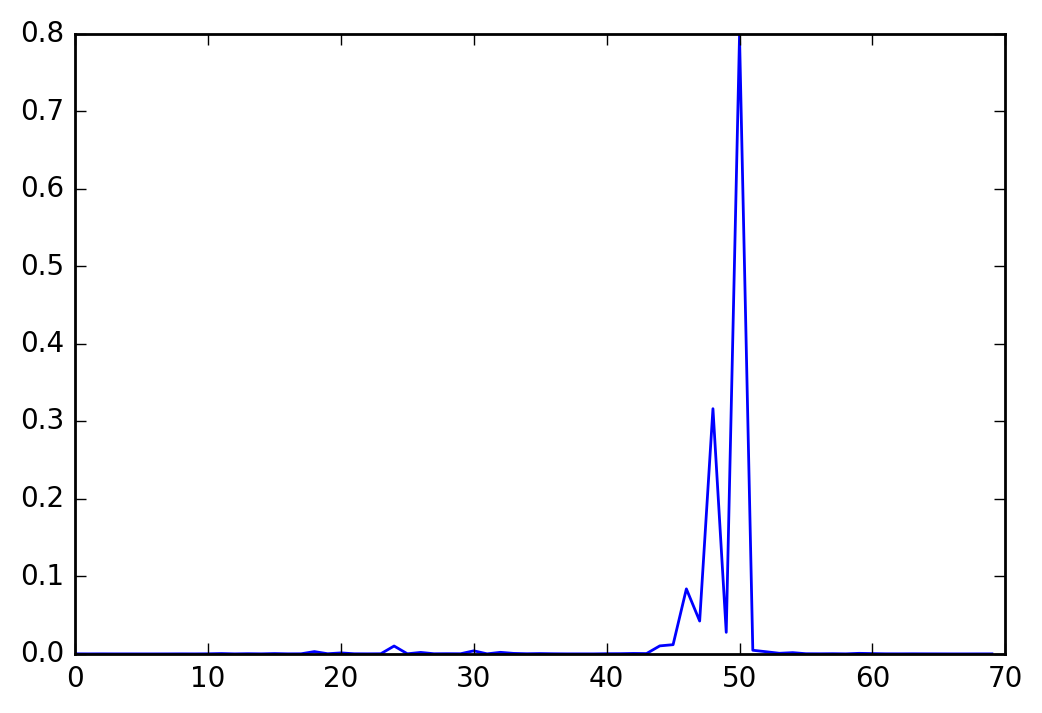

GGCCCCTCGCTCTCCTGCACATGCAGCCCCACTGTGGCCCCGTCTGCTACAGCCCCTCTCCCTTTGTTAG
__________________________________________________B


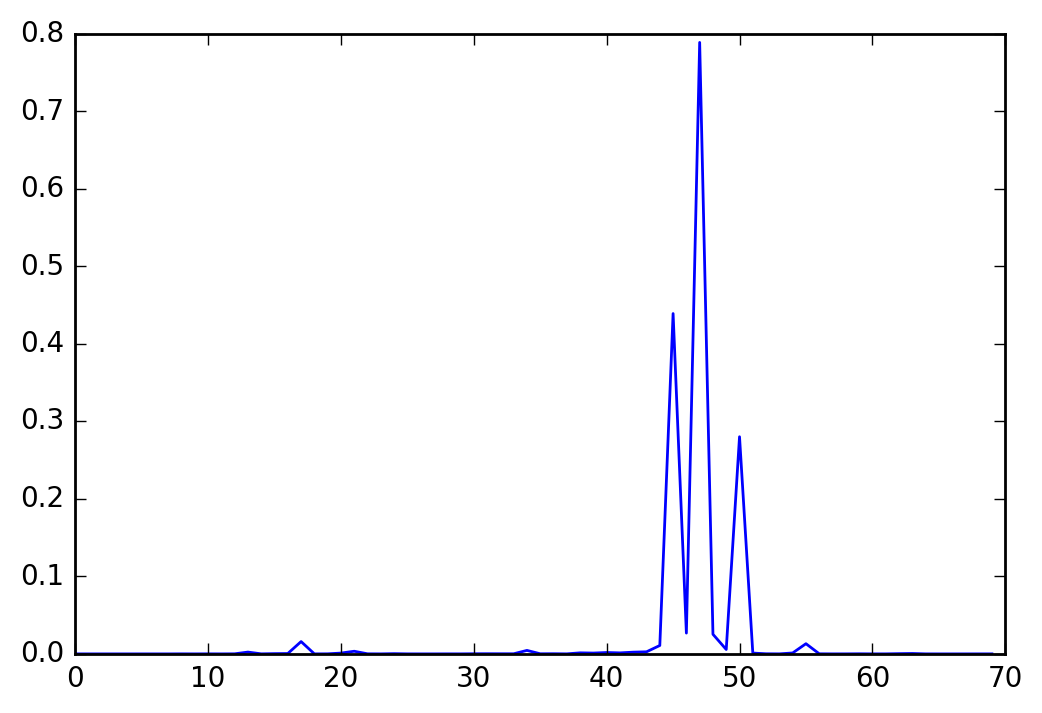

GTTGGATTTGTCTATTAAGTAACGGGTTTTTCTCAGGCTGTTTTTATAGCATGCTATTTTCTCCCTGCAG
_______________________________________________B


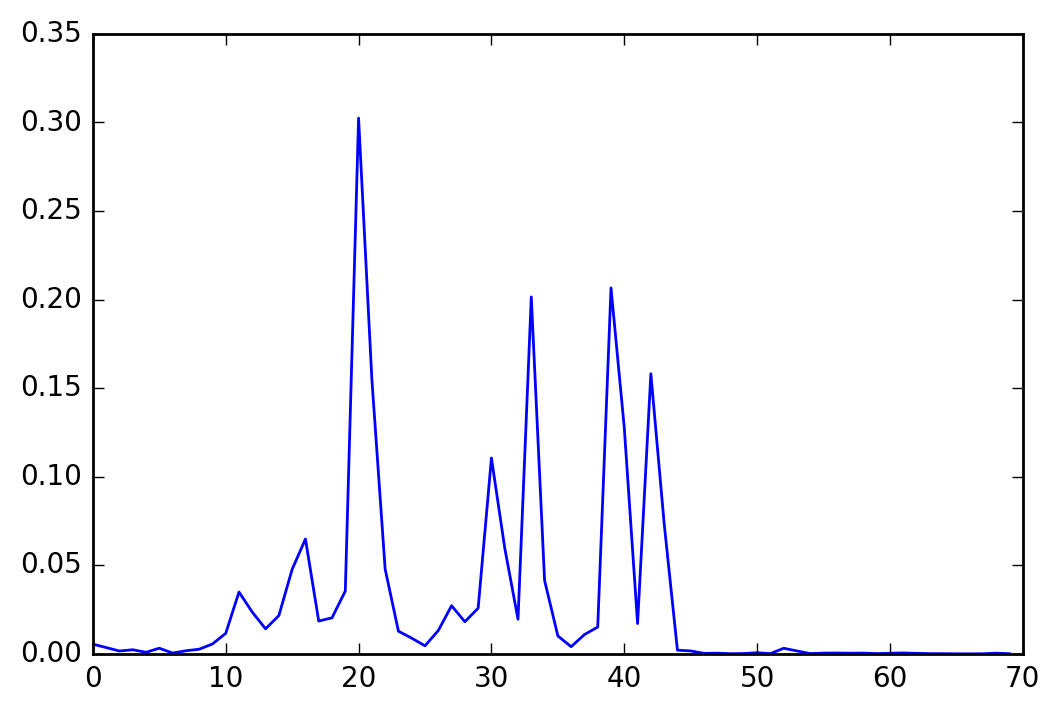

GTCTCCCTGTCCCTGCGTCTCCCGTCTGTGCCTCCCTCTCCTCCCCGTCTCTCCCGGCCCGGGCGCTCAG
____________________B


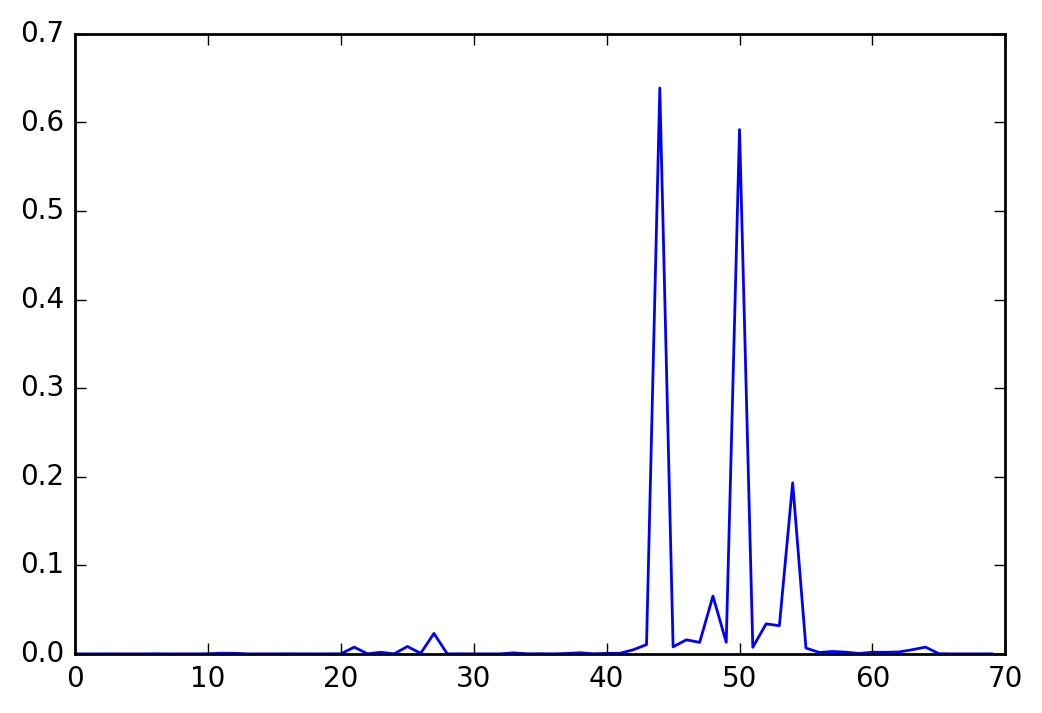

GCCACCACGGGAGGTGGGCTTACACTGAGACCCAGACAGGTGGGACCTGCAGCCACTGCTGCTCCCCTAG
____________________________________________B


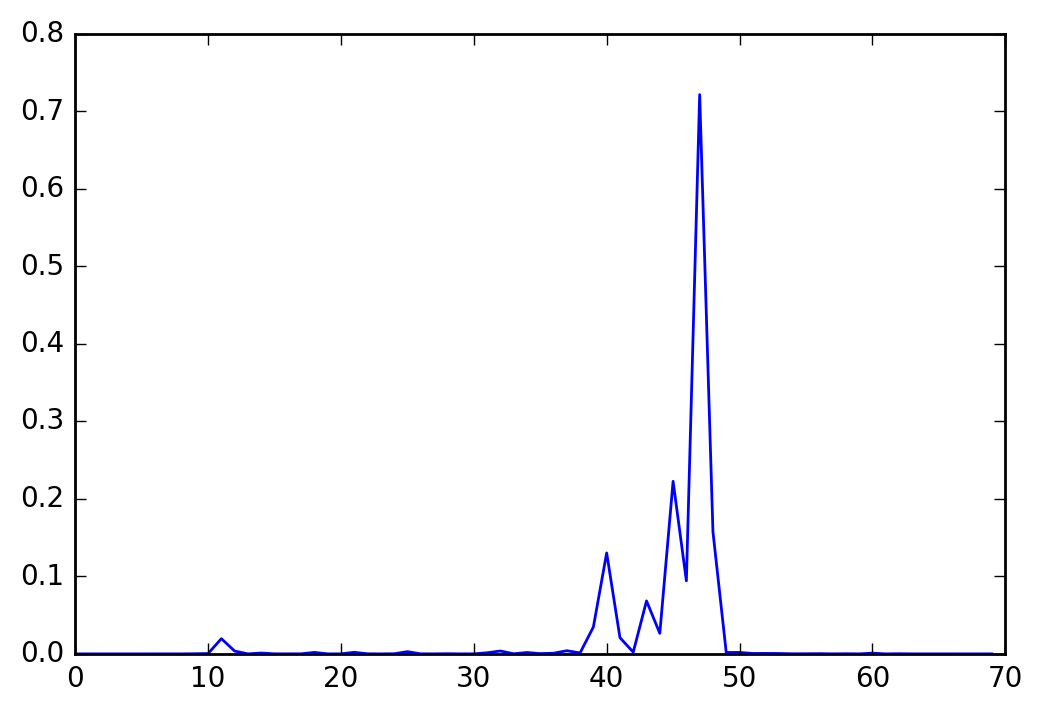

CAGCCCATCTTAAGAGCCATTATCCATTTTTAATACTCTAAAGATACAAGTGTGTTCTGTATATTTCTAG
_______________________________________________B


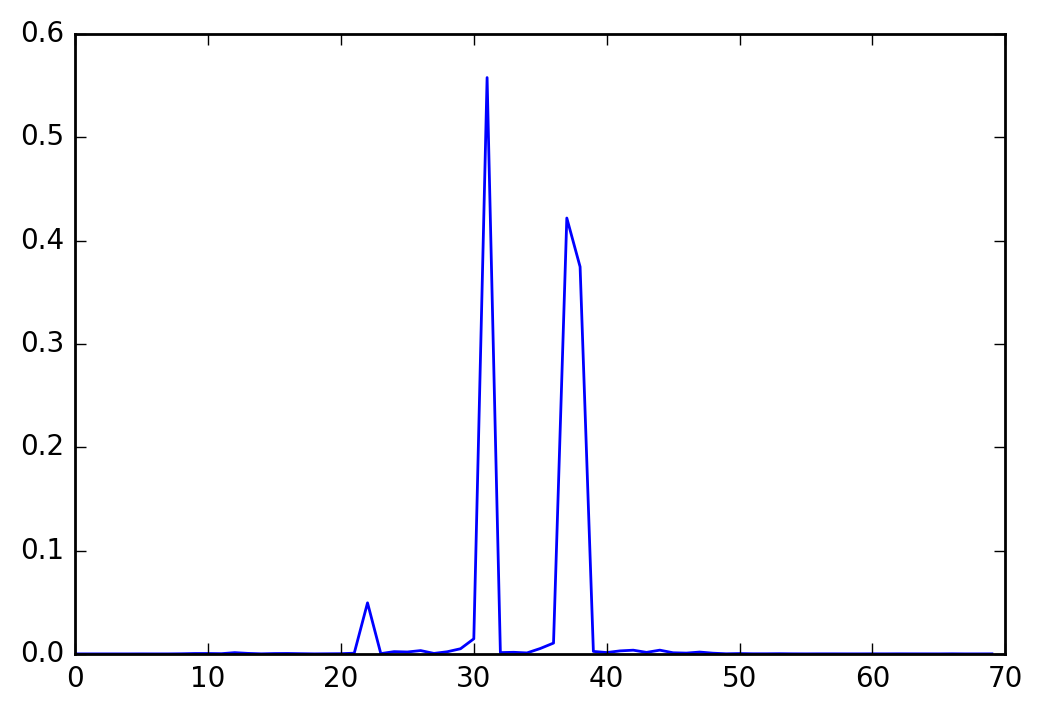

TAAATATTAAACATGAAATTTTATTGTTTGCATTTTGAATTTTTTTTGTTTTTGTTTTTTTTTCTTATAG
_______________________________B


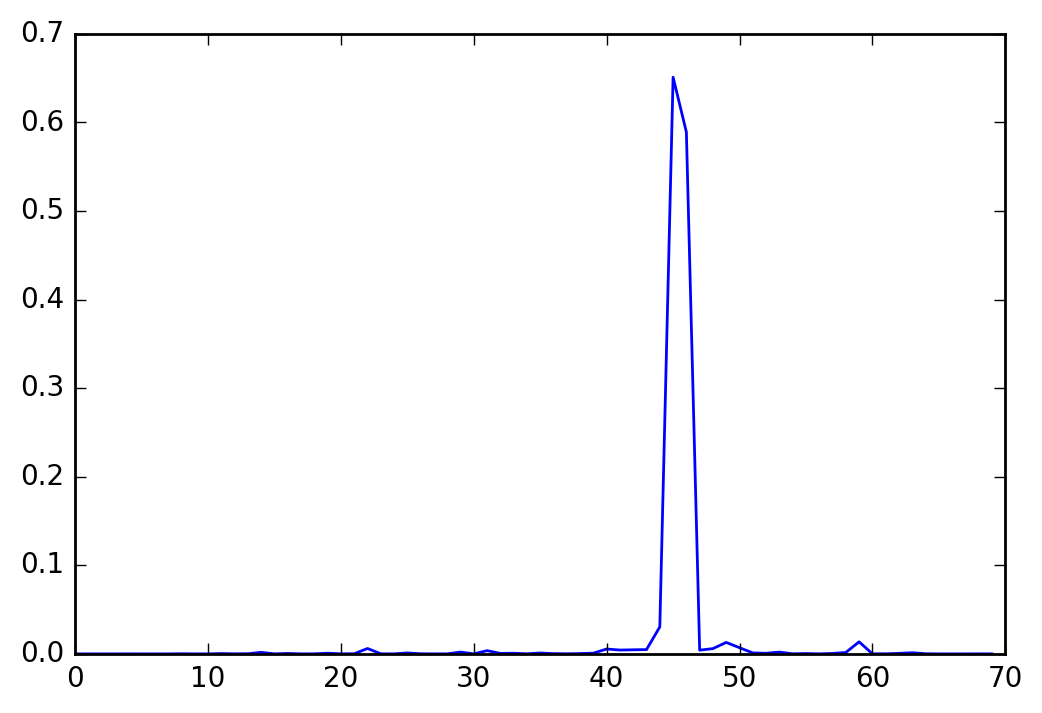

TTTTGGTCATTTGCATGGTGGTAGTCGTTACTGTGAATGGGGTCCAAGGGCTTTTTCTTACTTTCCTCAG
_____________________________________________B


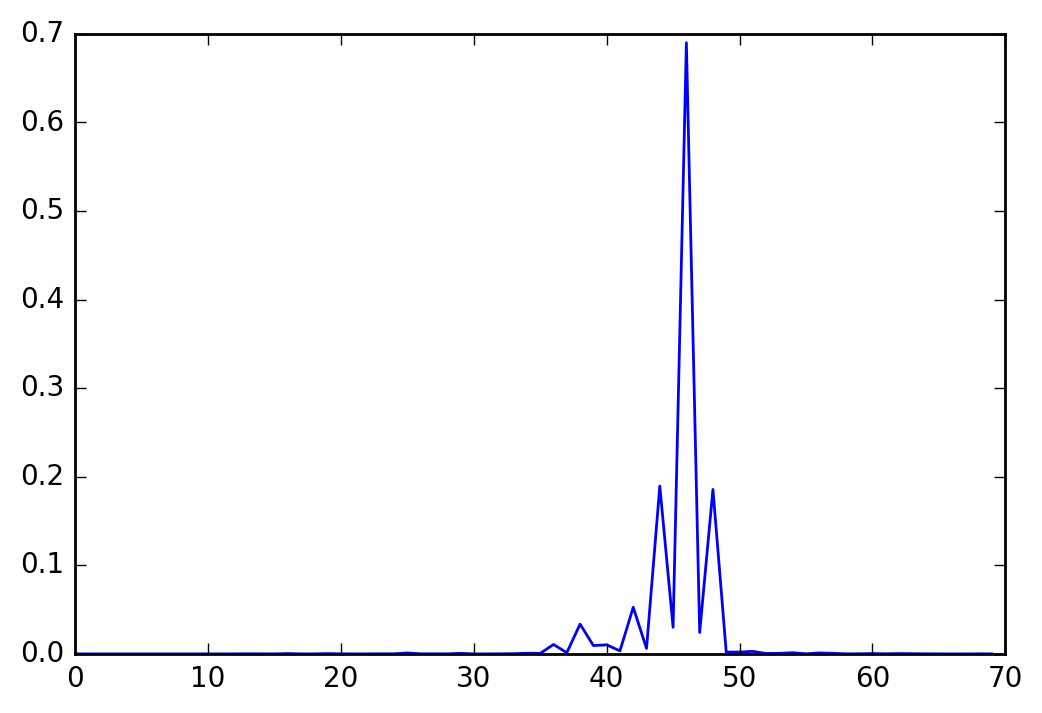

GGATGGGGACTCTGGGAGCAATGCCAGGGAGTCCCCACACCTCTAGACATGTCTCTGGTTGTGCTTTCAG
______________________________________________B


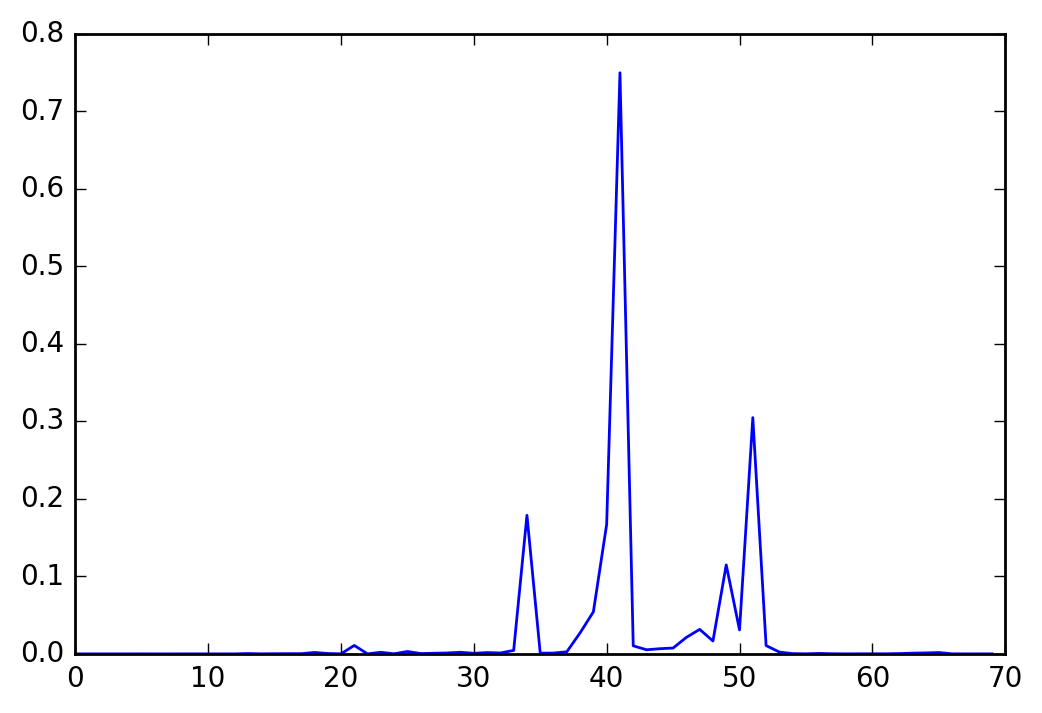

CTGGAGGCAGGTCAGGGGAAGAGTGTGTGGCTGCATGGCCCACGGGGGCTGCCCTTGGTTTTCTGCCCAG
_________________________________________B


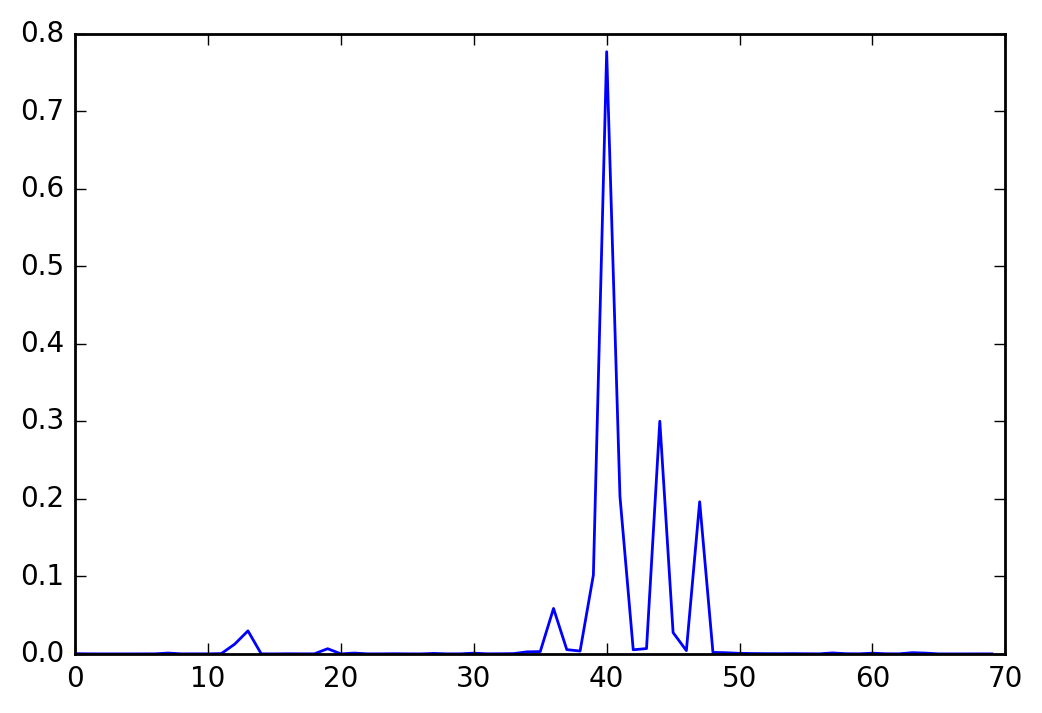

ATGCTGGATTTTAATTTTTATTGTGGTTGTACTTGGATGCAAGGAATATGTTTTGTTCCTCCCAATTTAG
________________________________________B


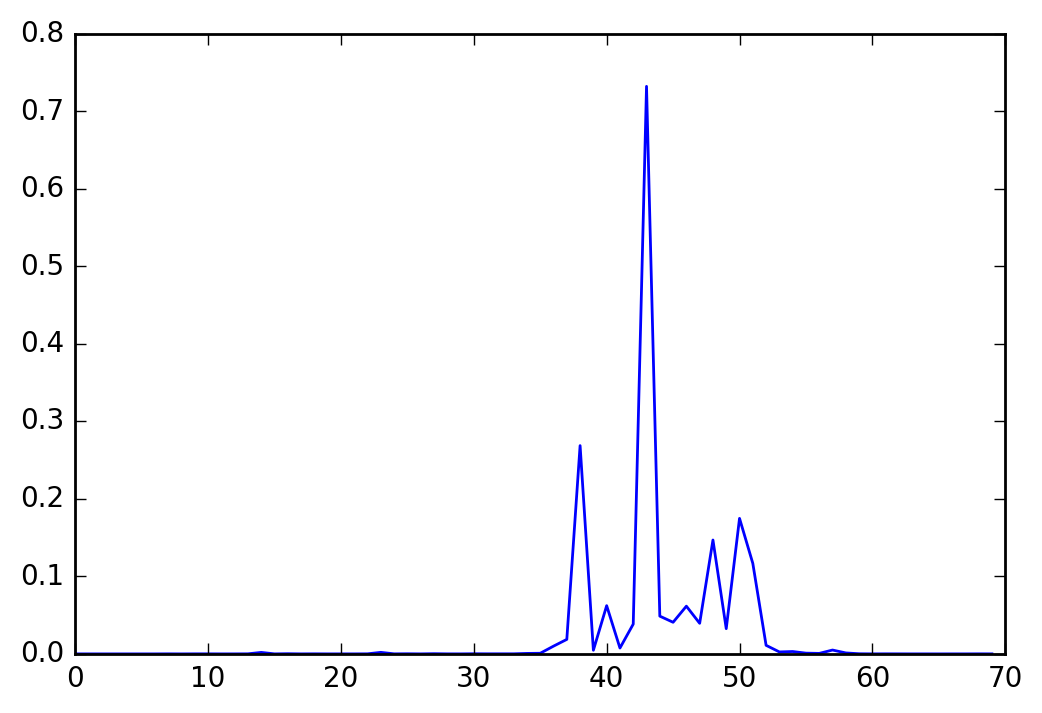

ATGCTTCAGAATTCAGAGGGTTCAGGGAATGGTTTCGGATAGTAGGCTCTCCCTGCTCCCTTCTCTACAG
___________________________________________B


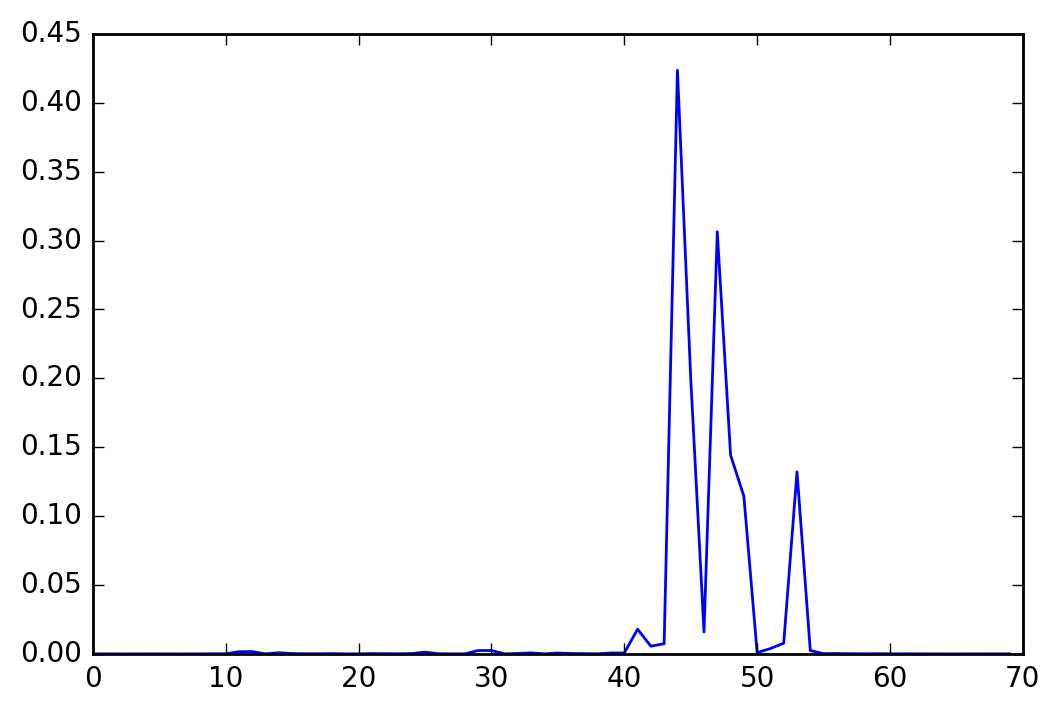

AACCAACTTCCAATACCCTTTGGCCATTTAATTGTTGTTTCTGTAACAAACTTAGTTTTGTGTTTTACAG
____________________________________________B


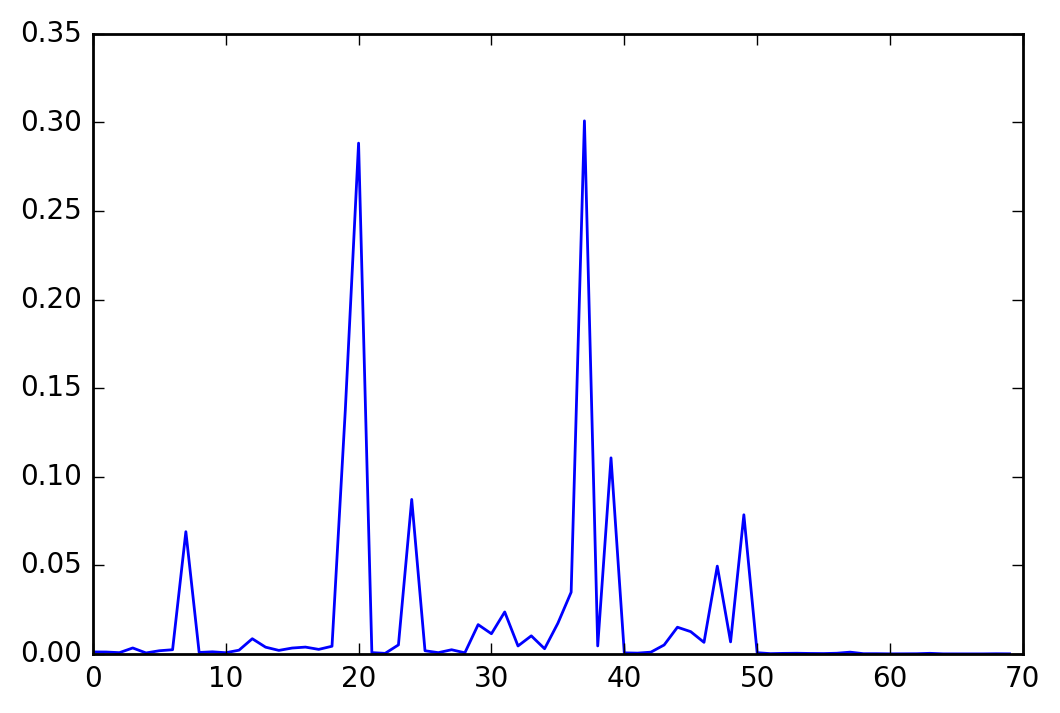

AATACTCACTTTGTTTTTTAATCTATGTCTGTCCCCGACATTTTCCTCCATGTGTTGCCCCGGATTTCAG
_____________________________________B


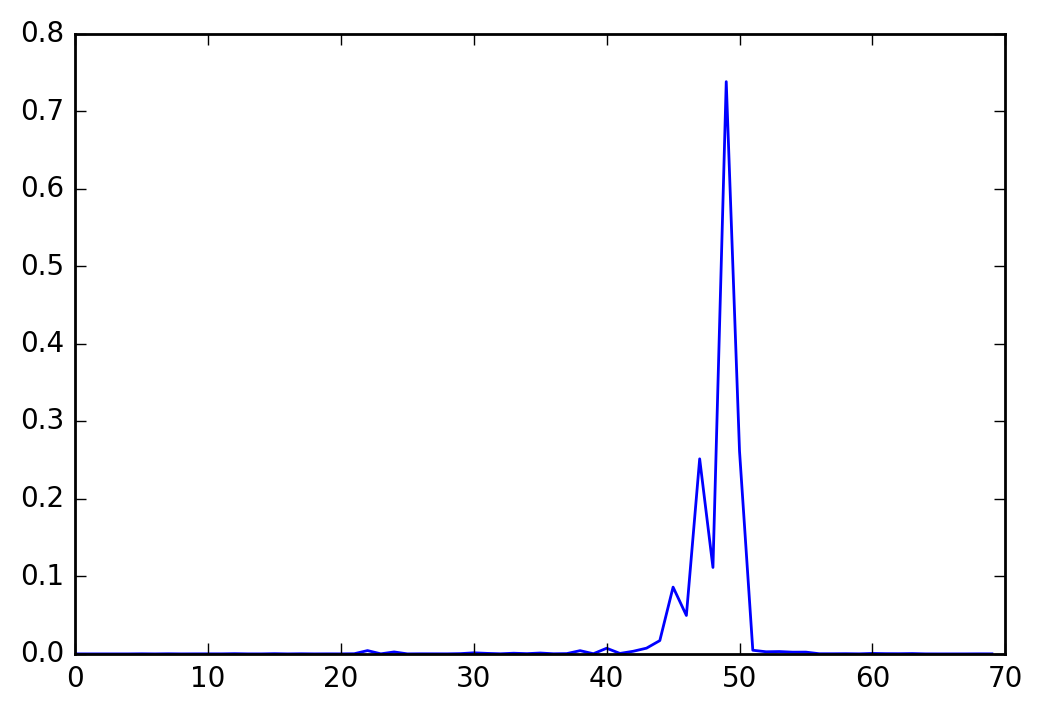

CCCCTGGTGTGGGGCAGGGTGCACAGTGCTGCTGGCGCAGACCCTCTCCAAGTCCCCTCTGTCCCTGCAG
_________________________________________________B


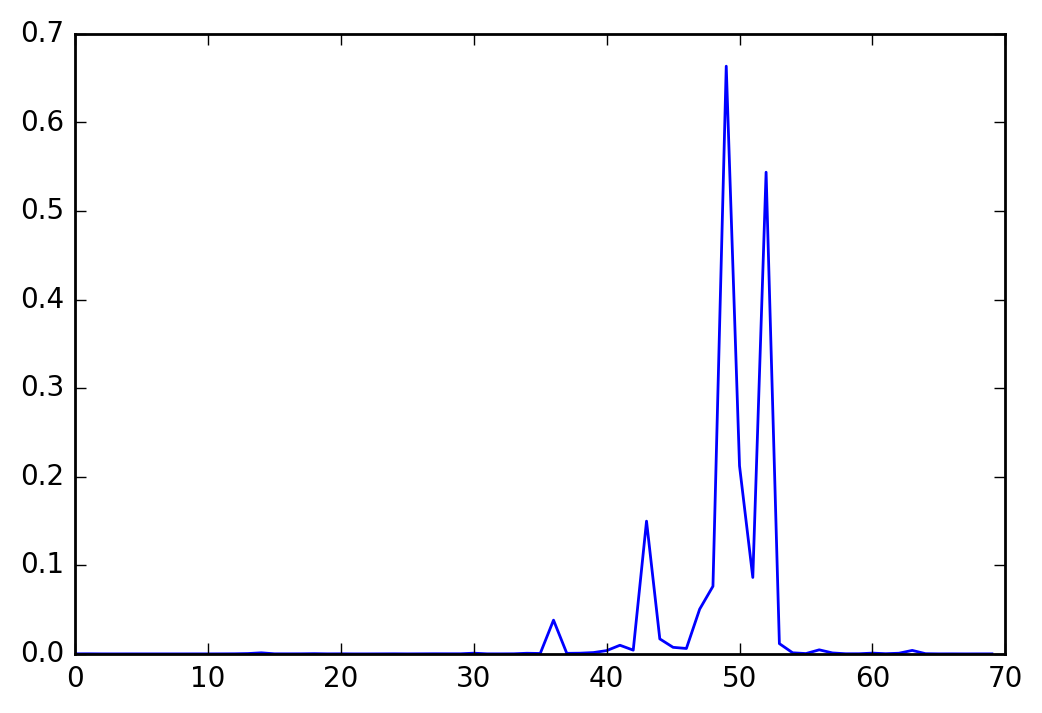

GATGGGCCCCCTGGATGGGGATTGGCTGGGAGGCTCAGGGGCCAGTGCCATCACCTGGCTCTTCCTCCAG
_________________________________________________B


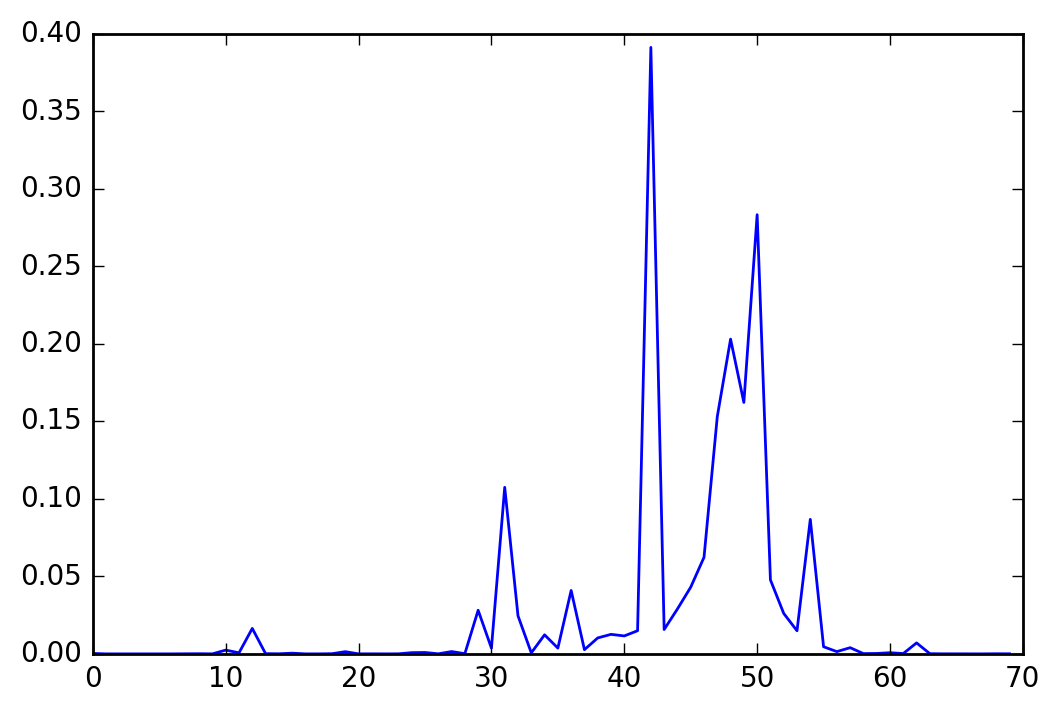

ACCCTCCATCTGAGGACCAAGCCCAACACTGAAGAGAGGCCCAGGGTCCCCCTGCCTCTTTCACTTTCAG
__________________________________________B


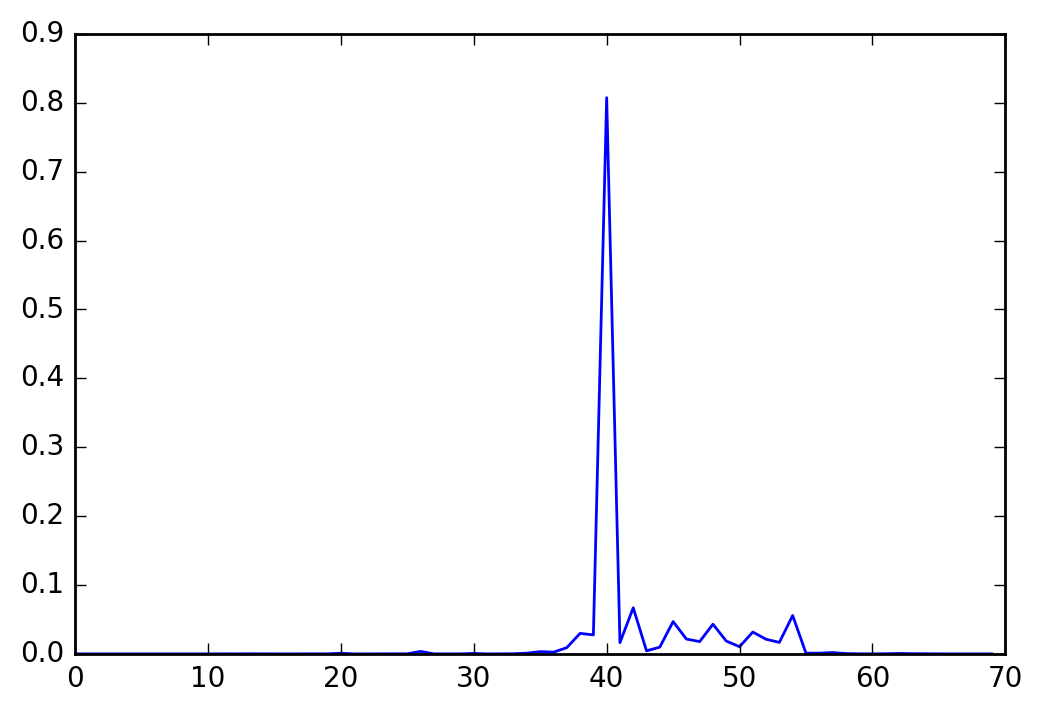

GGCCTGGGCTGGGAAACTGGAGCTGCAGGGATTGGGCTGGACAGGCCCCCTGCTCTGCCCTCGCCCCCAG
________________________________________B
38927


In [11]:
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    total += 1
    if total > 20: continue
    plt.plot(target)
    plt.show()
    print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :4]))
    print '_'*bp + 'B'
print total

# Gene Set enrichments

- No -2 T set covers most of the genome.

- C branchpoints don't seem to have any grouping into a given set of genes.

These sets yield some results, but I am very skeptical of large gene set enrichments, so I will not pursue this further.

In [12]:
from sklearn.utils import shuffle
# A Branchpoints
with open('A.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if seq[bp, 0]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if seq[bp, 0]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# C Branchpoints
with open('C.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if seq[bp, 1]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if seq[bp, 1]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# T at -2
with open('T_2.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if bp < 2: continue
        if seq[bp-2, 3]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if bp < 2: continue
        if seq[bp-2, 3]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

# no T at -2
with open('no_T_2.txt', 'w') as fp:
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], a_genes):
        if bp < 2: continue
        if not seq[bp-2, 3]:
            fp.write(gene + '\n')
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())
    genes = {}
    for bp, seq, gene in zip(np.argmax(y_all, axis = 1), X_all[:, :, :4], shuffle(a_genes)):
        if bp < 2: continue
        if not seq[bp-2, 3]:
            if gene not in genes: genes[gene] = 0
            genes[gene] += 1
    print len(genes), sum(genes.values())

18547 202813
18555 202813
2695 3352
2912 3352
18252 167365
18314 167365
13705 38922
13824 38922


## Conservation Meta

44810


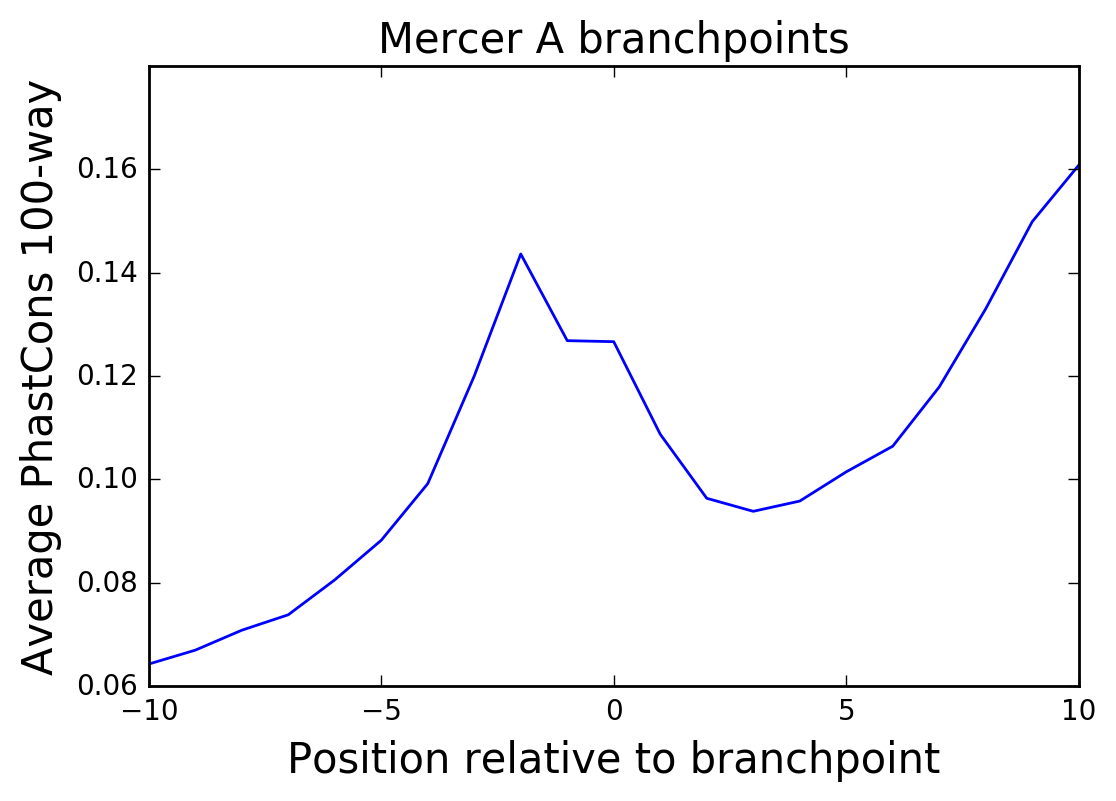

4815


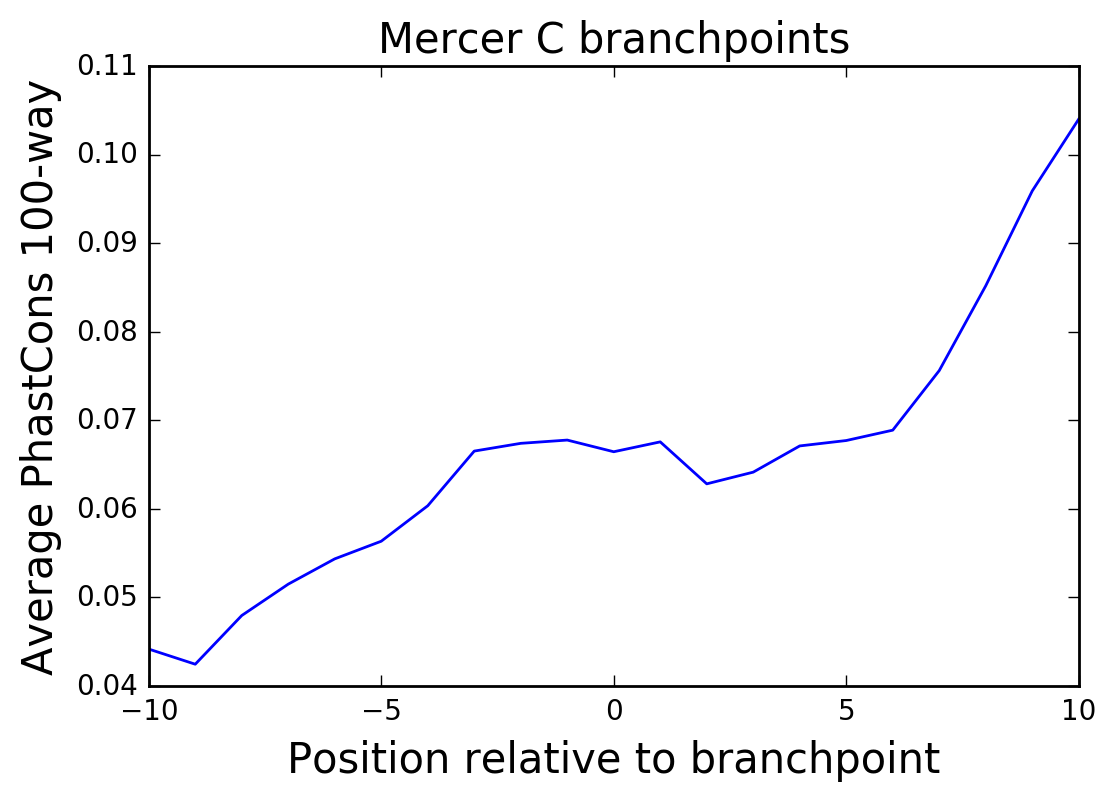

2424


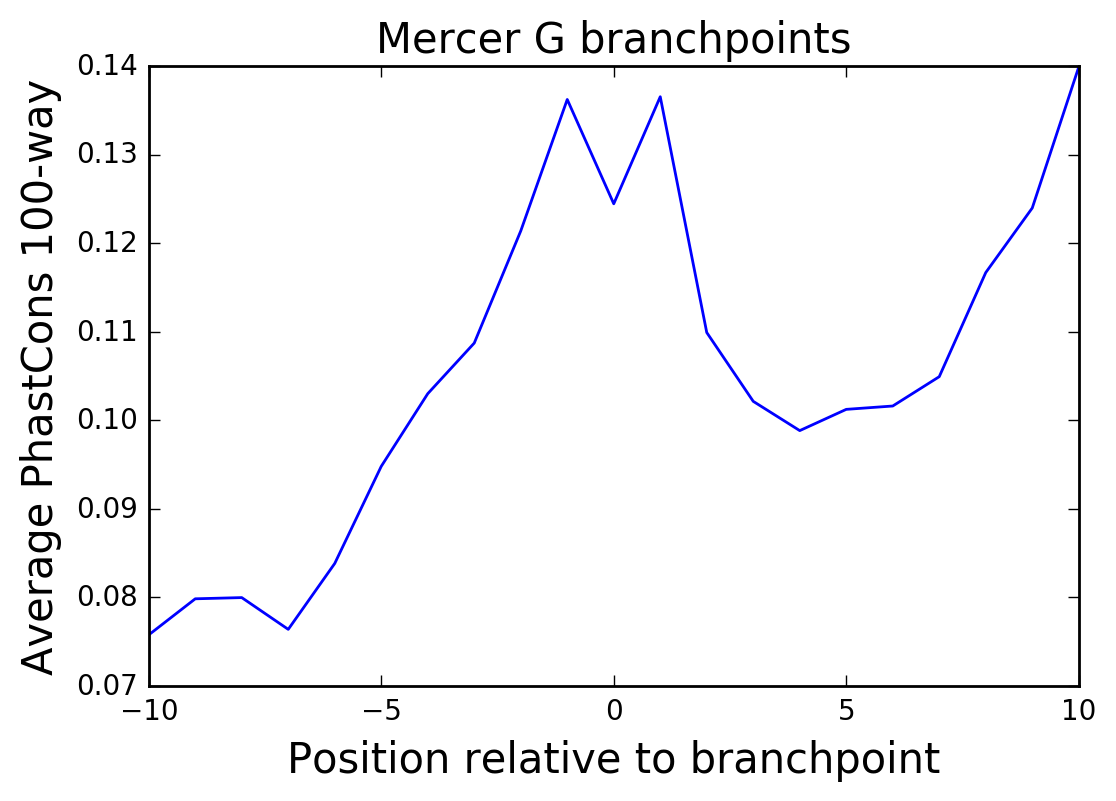

4568


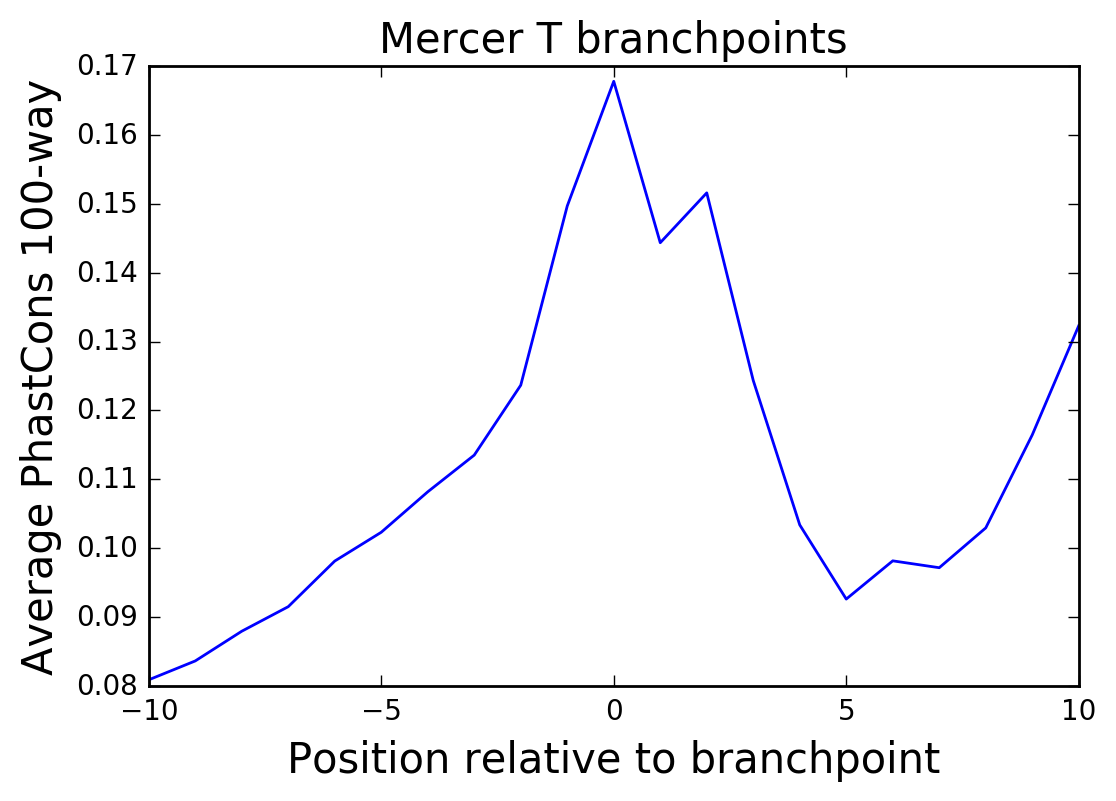

44810


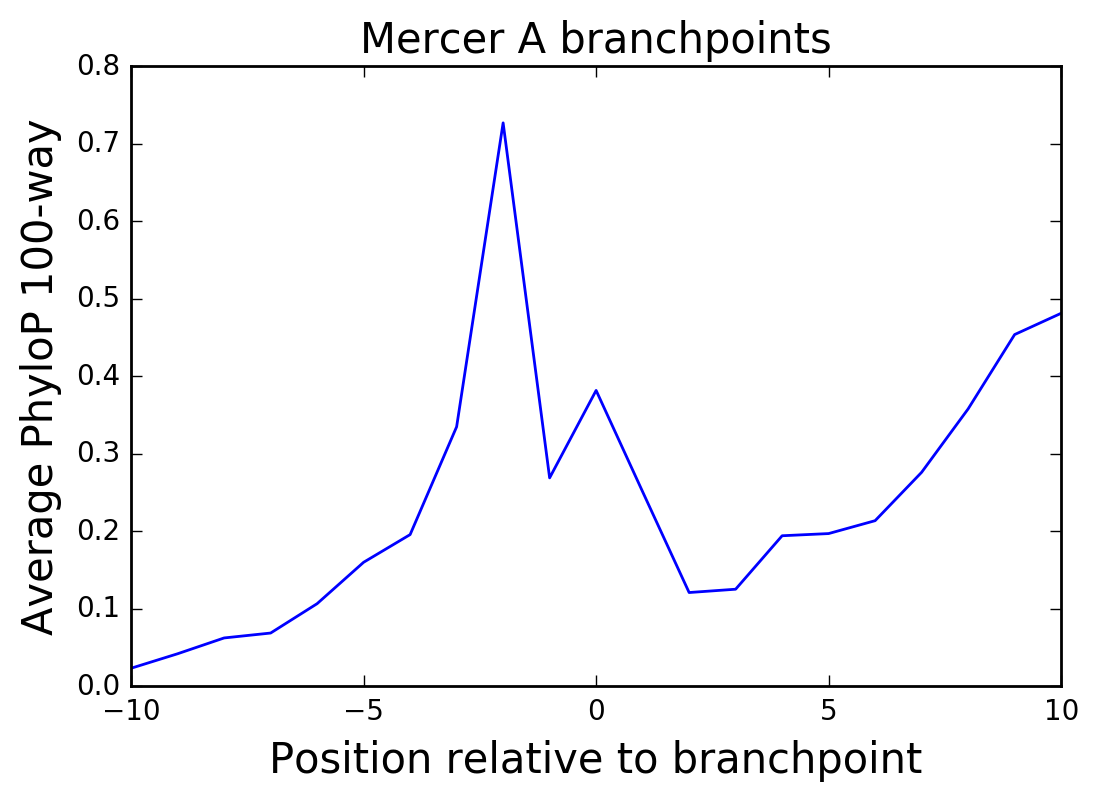

4815


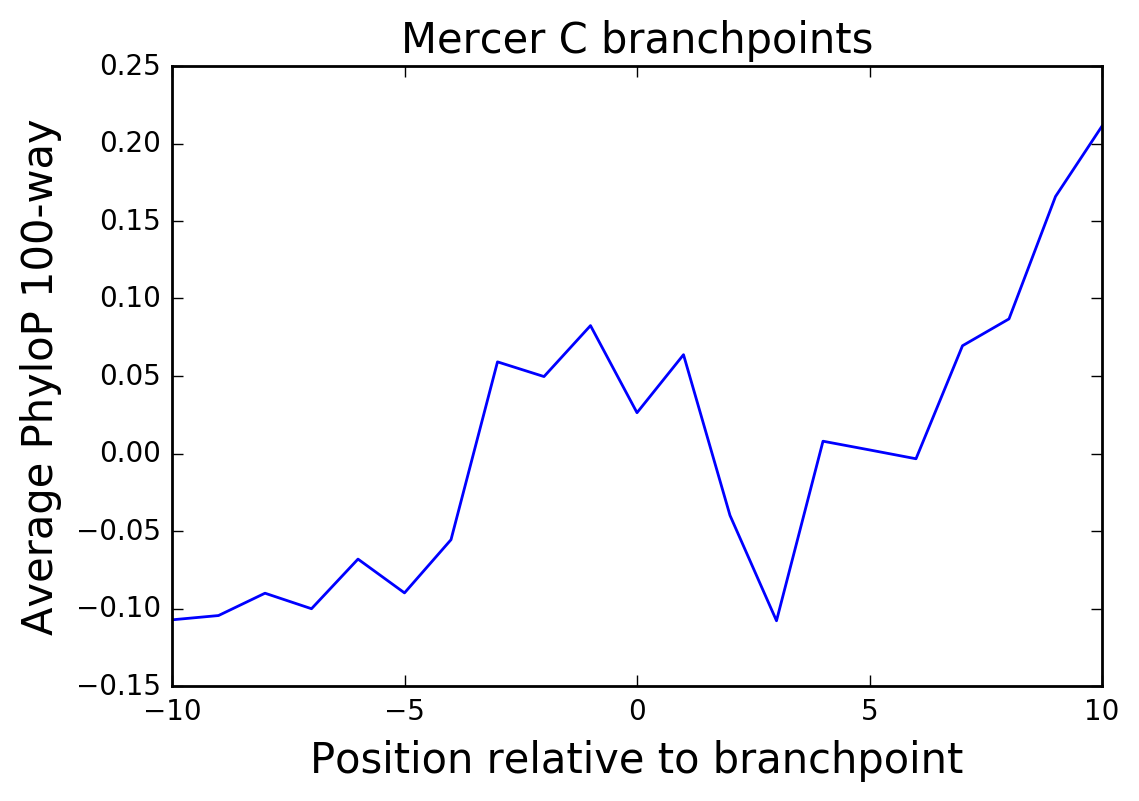

2424


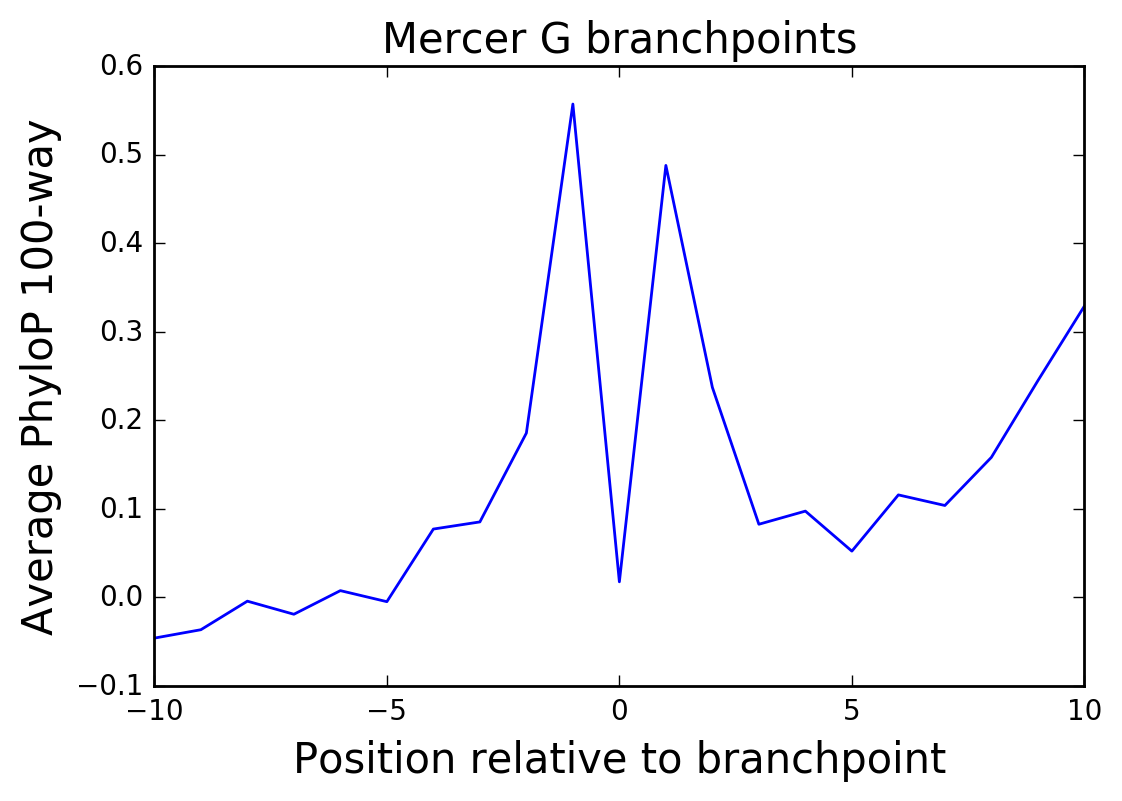

4568


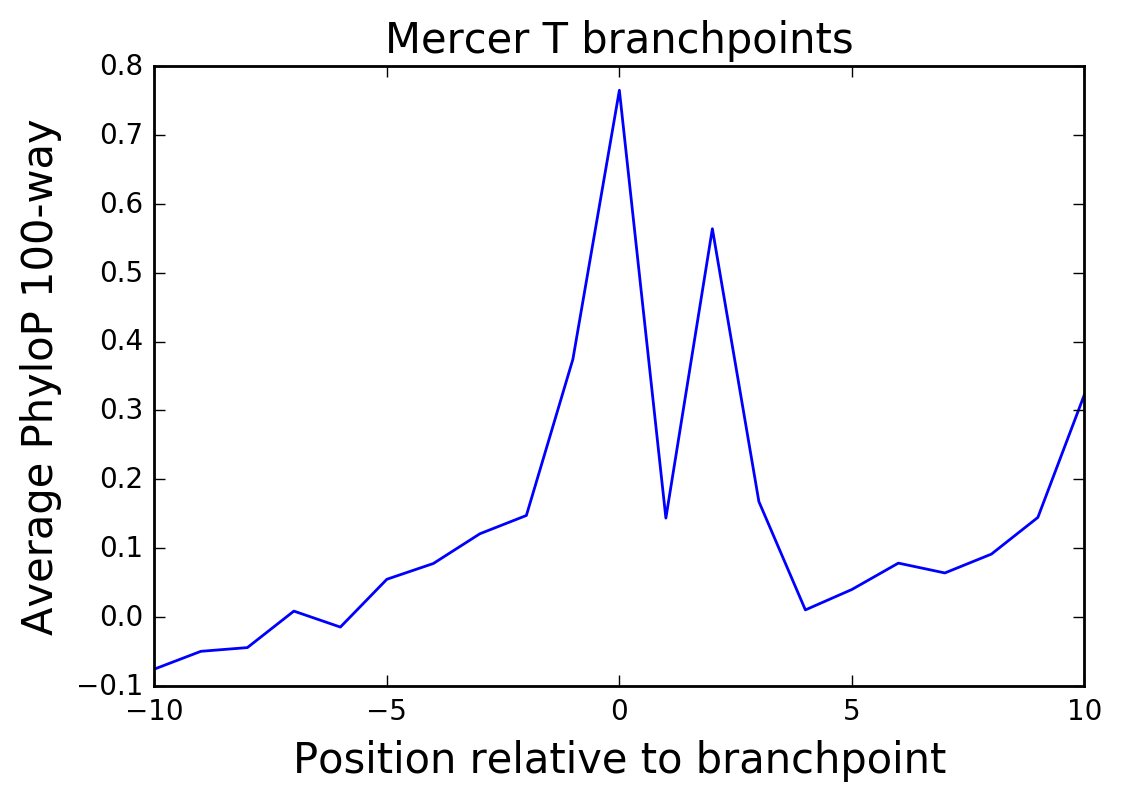

44810


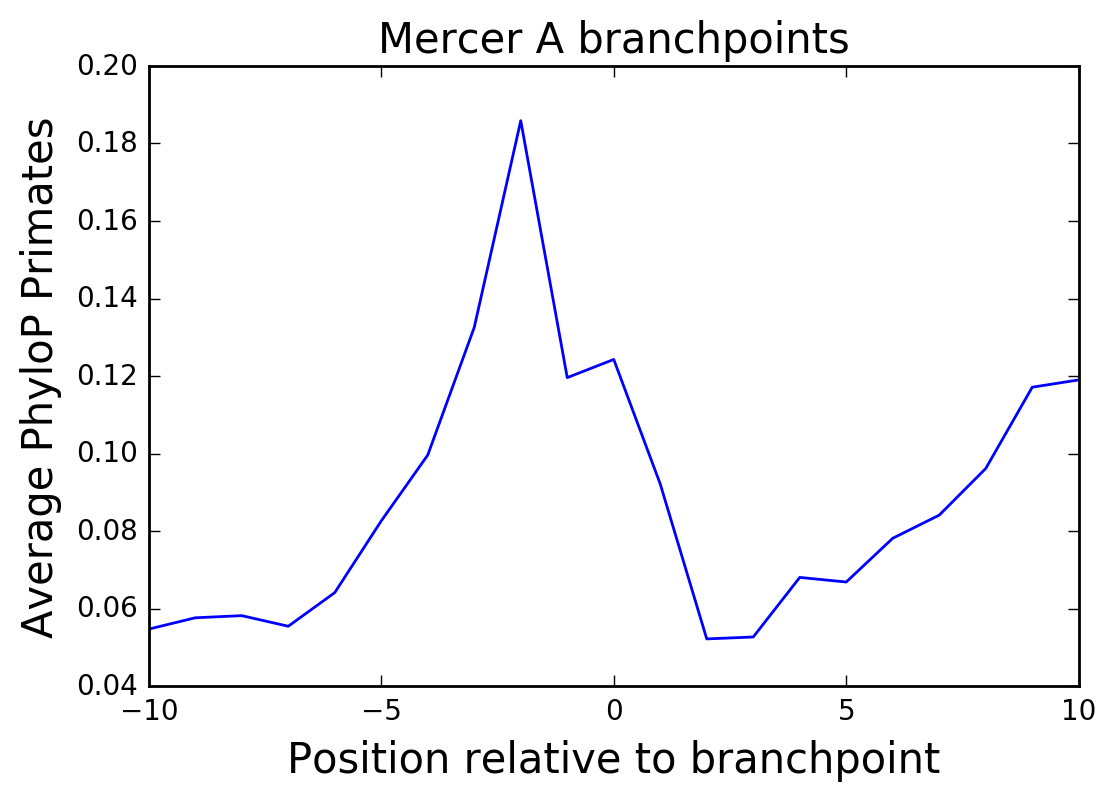

4815


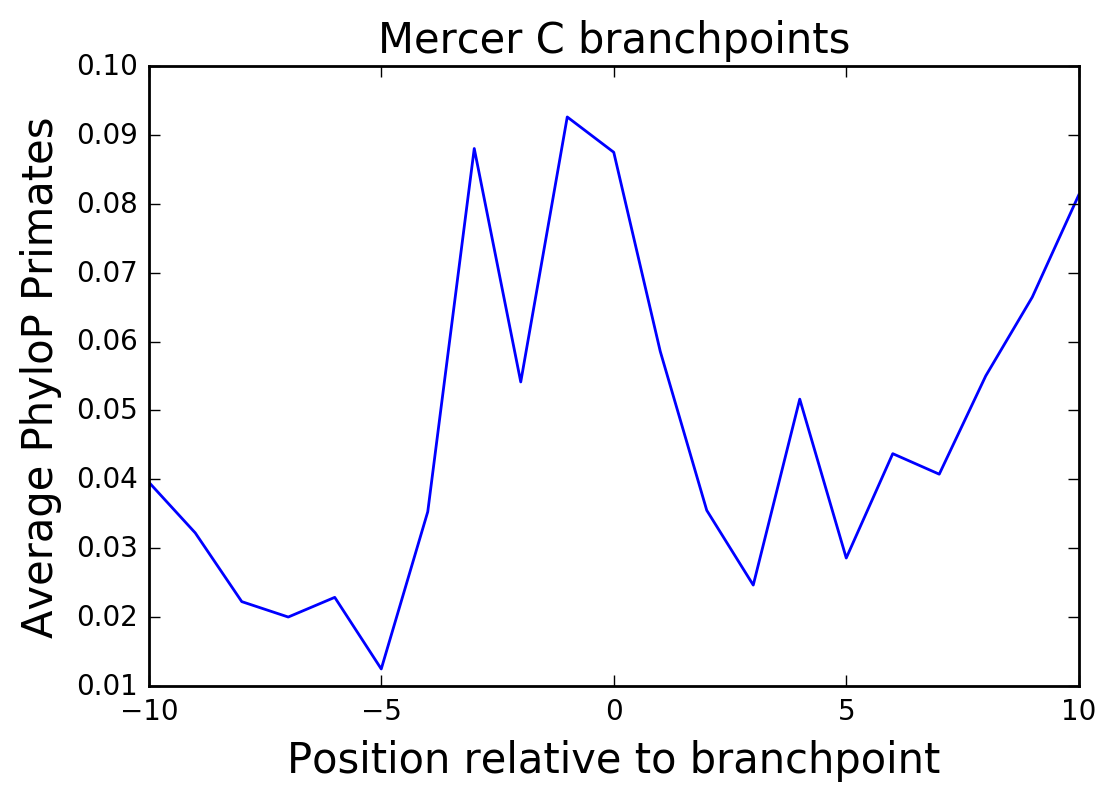

2424


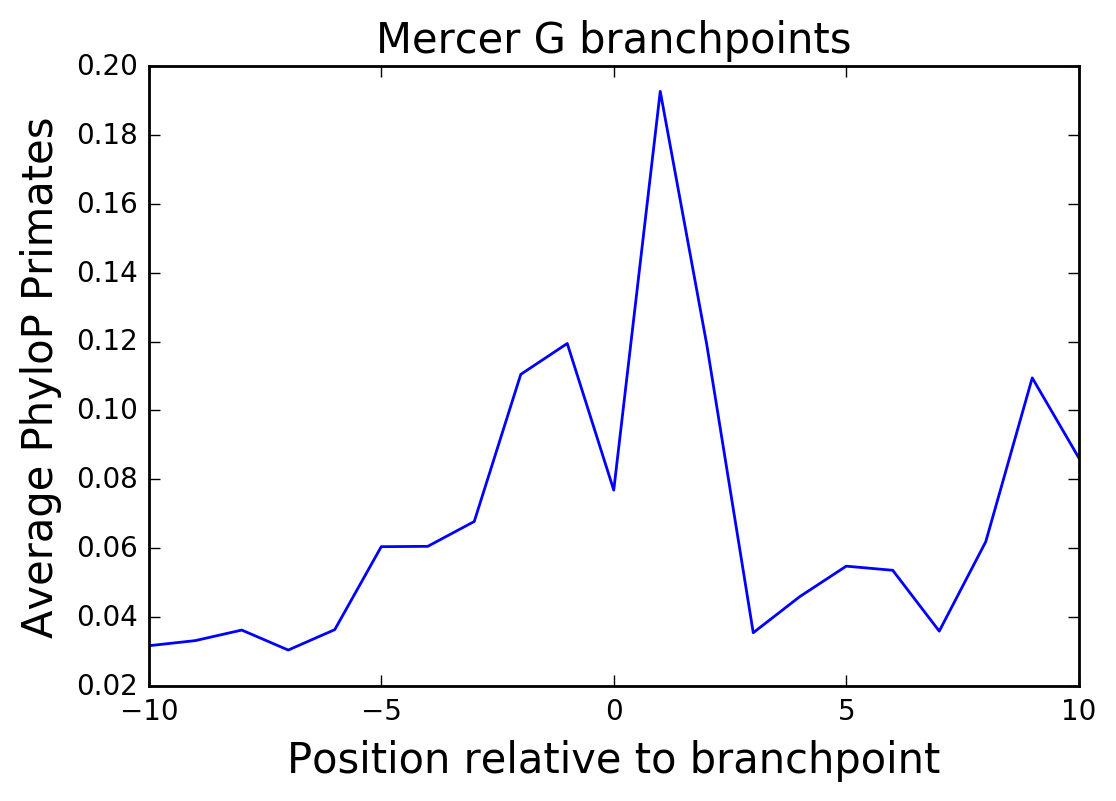

4568


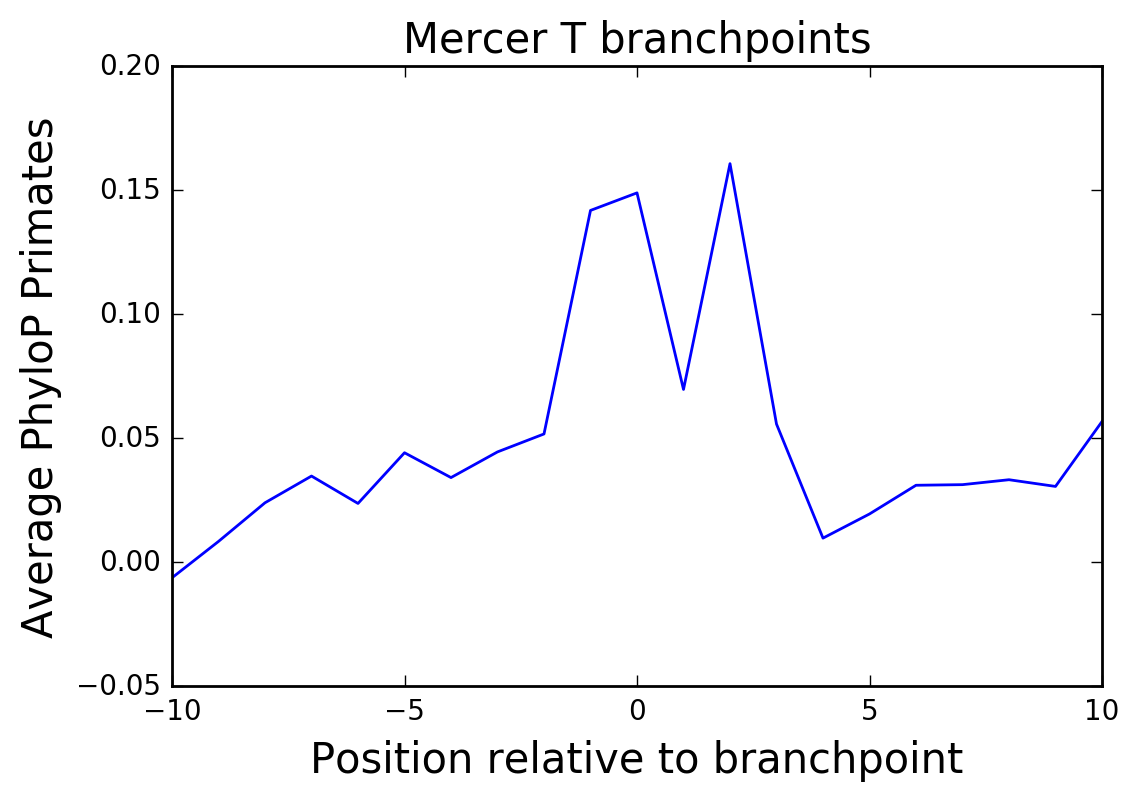

In [13]:
# By BP nucleotide

def cons_known_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, base]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_known_base(X_known, y_known, 4, i), label = base)
    plt.xlabel('Position relative to branchpoint')
    plt.ylabel('Average PhastCons 100-way')
    plt.title("Mercer {} branchpoints".format(base))
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_known_base(X_known, y_known, 5, i), label = base)
    plt.xlabel('Position relative to branchpoint')
    plt.ylabel('Average PhyloP 100-way')
    plt.title("Mercer {} branchpoints".format(base))
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_known_base(X_known, y_known, 6, i), label = base)
    plt.xlabel('Position relative to branchpoint')
    plt.ylabel('Average PhyloP Primates')
    plt.title("Mercer {} branchpoints".format(base))
    plt.show()

202549


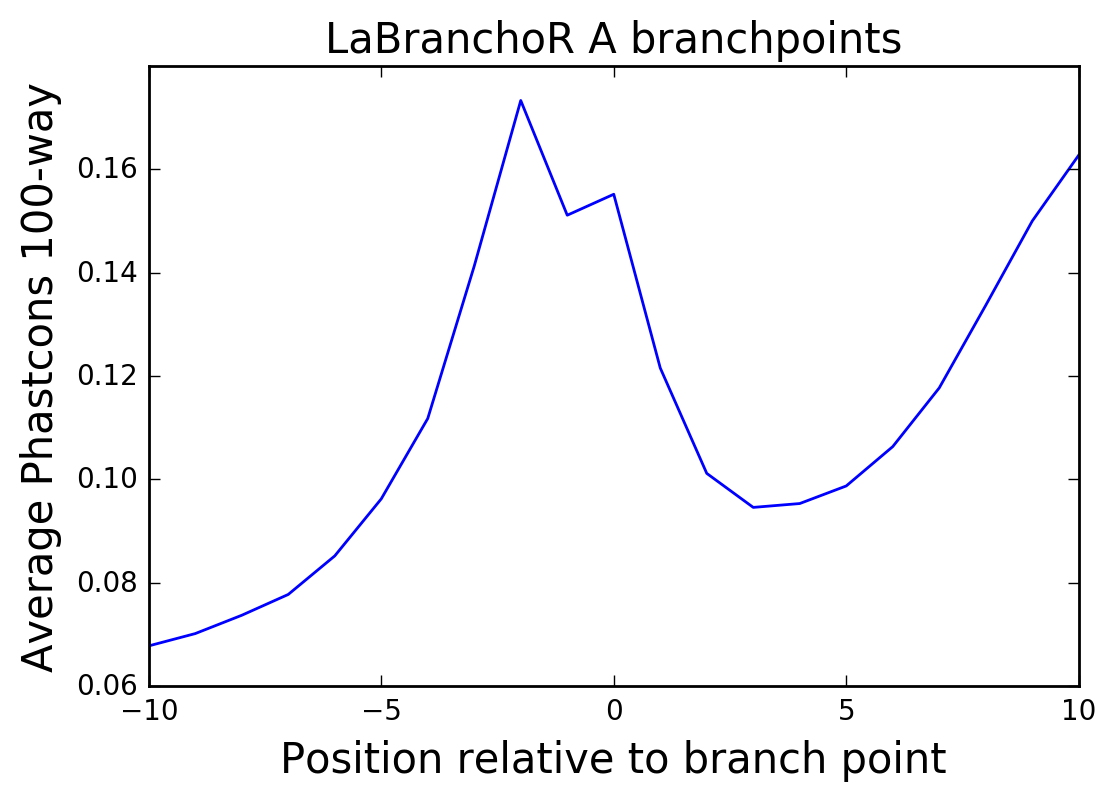

3347


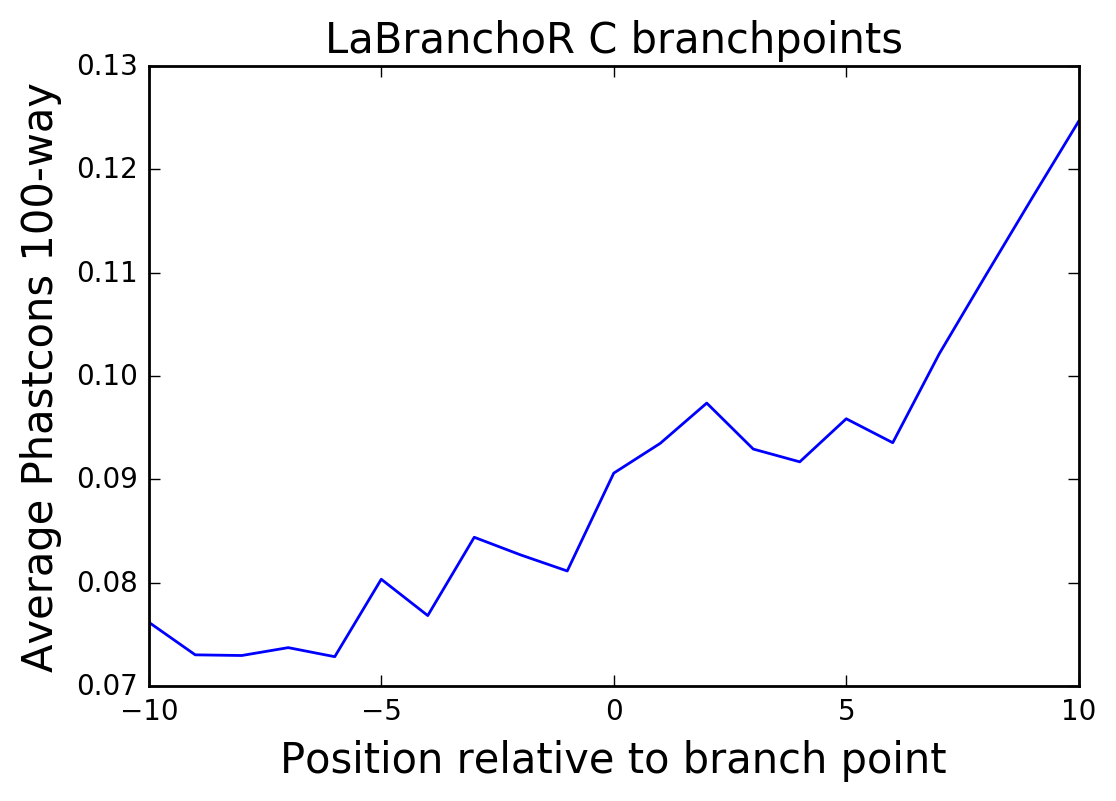

57


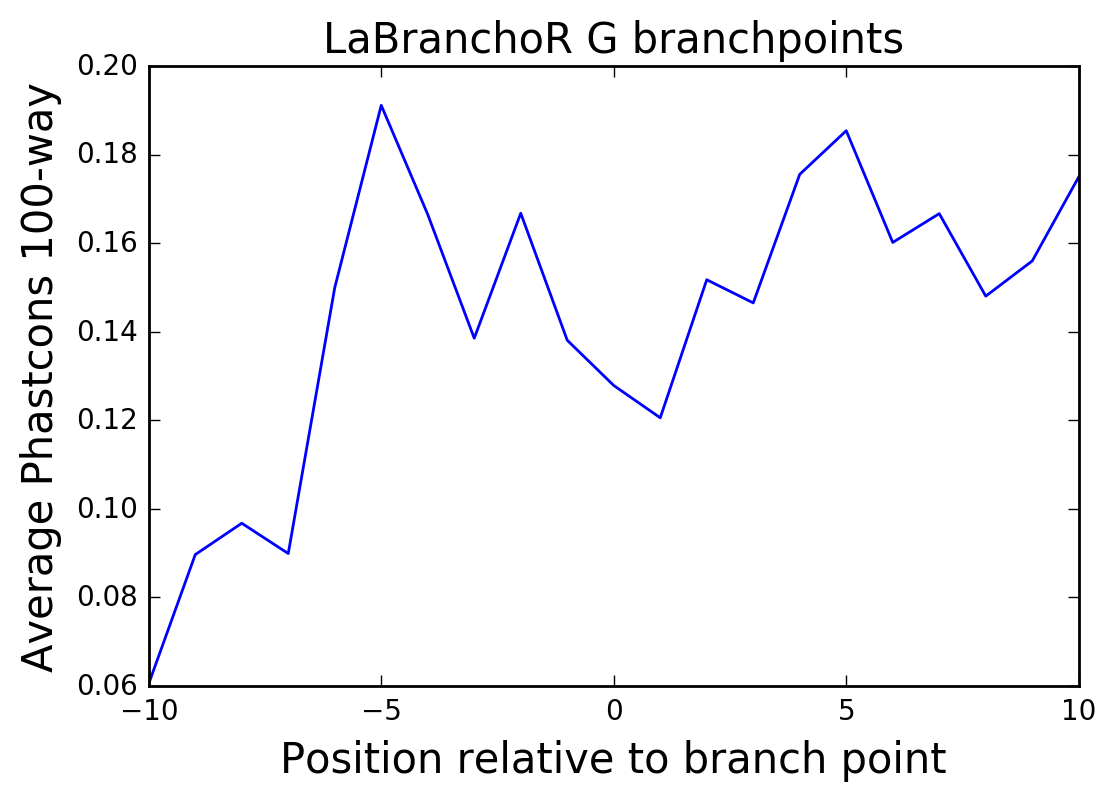

69


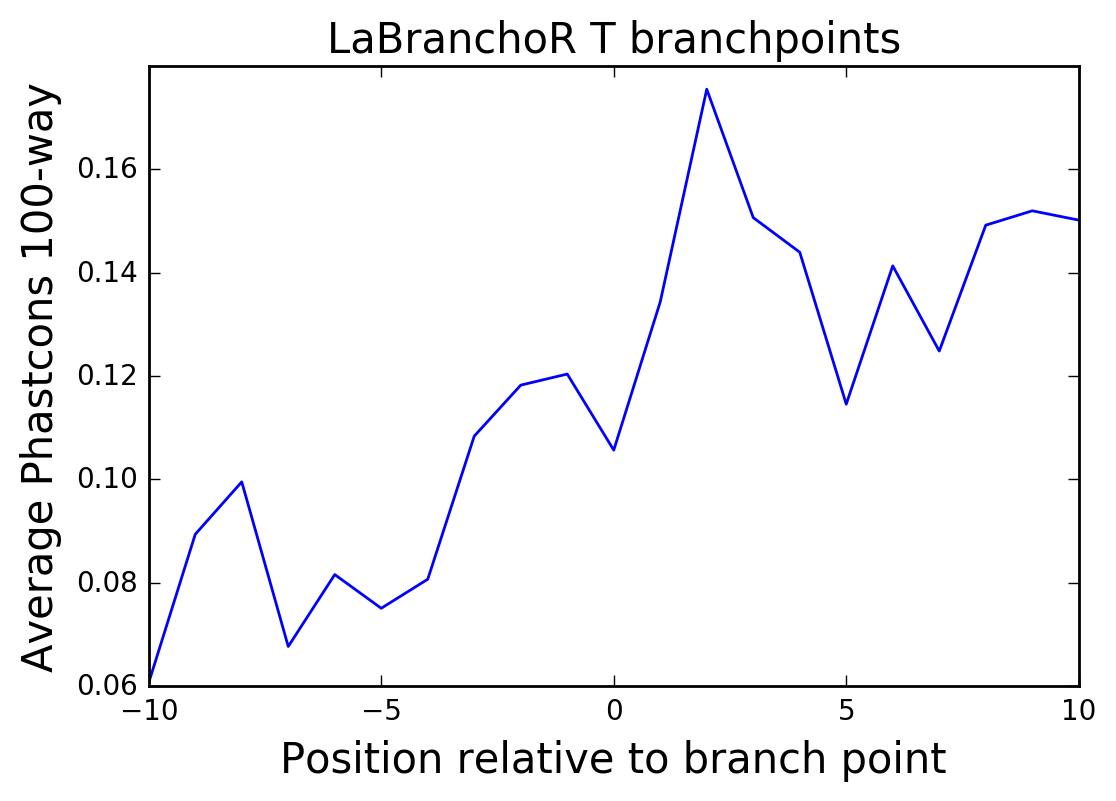

202549


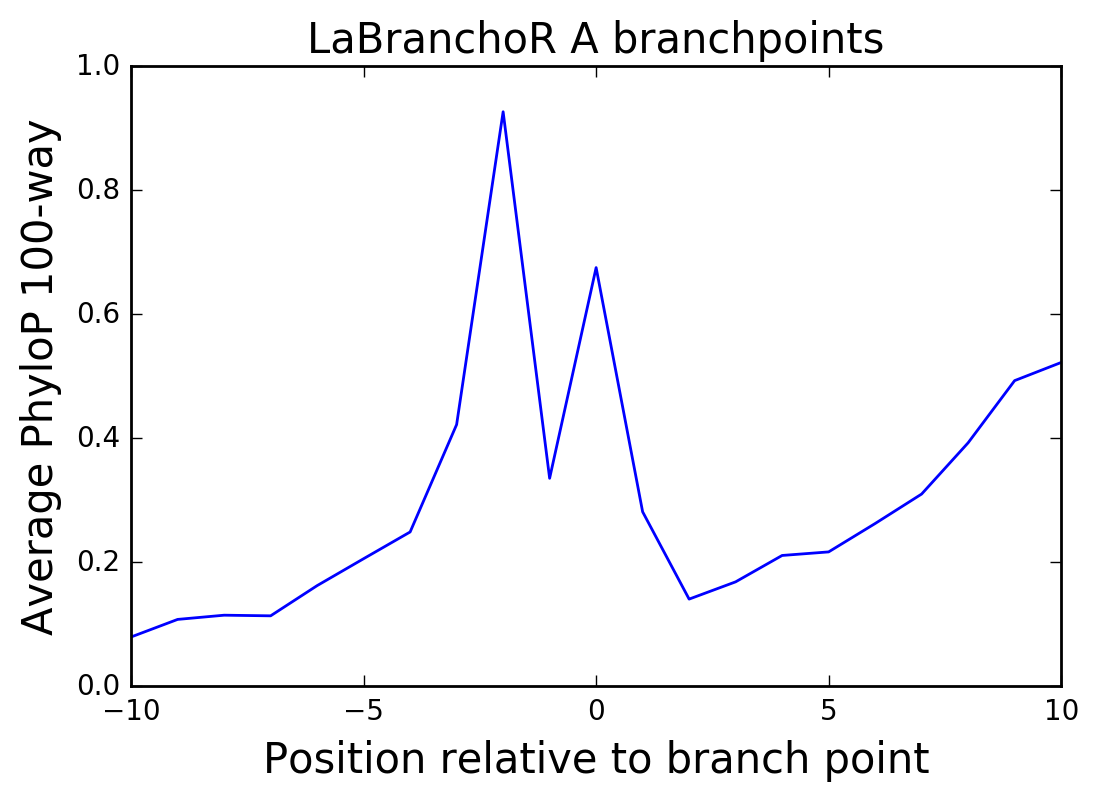

3347


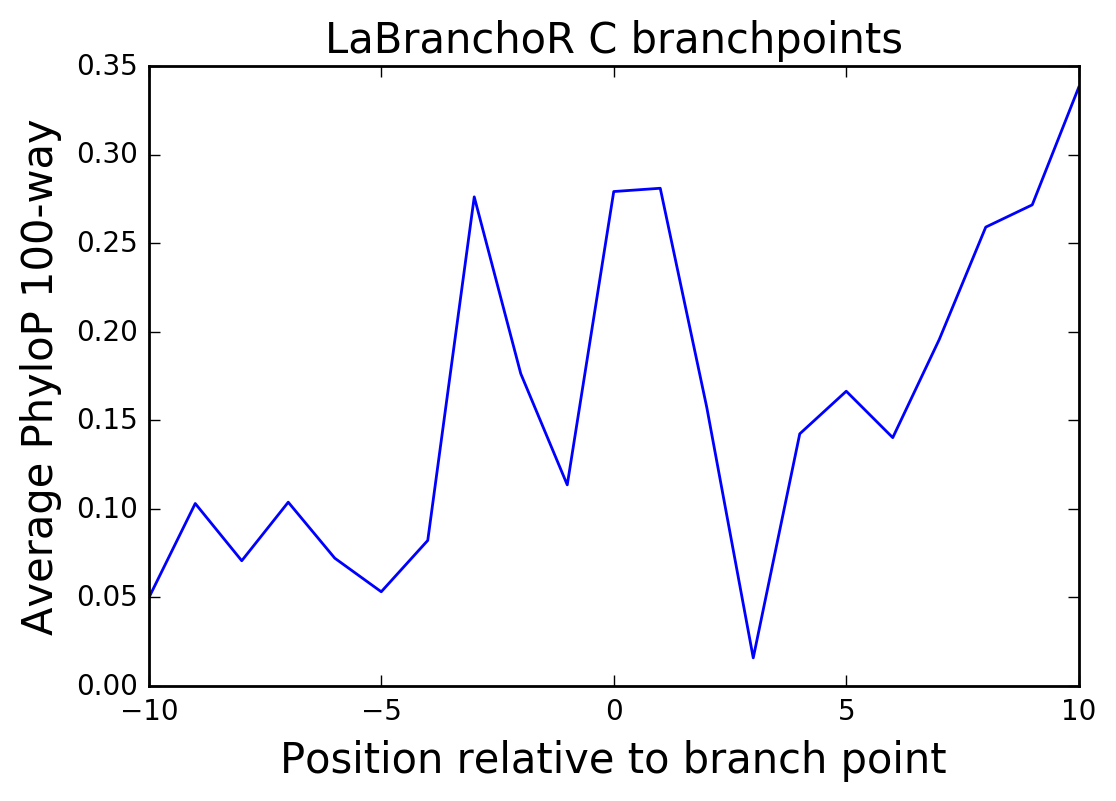

57


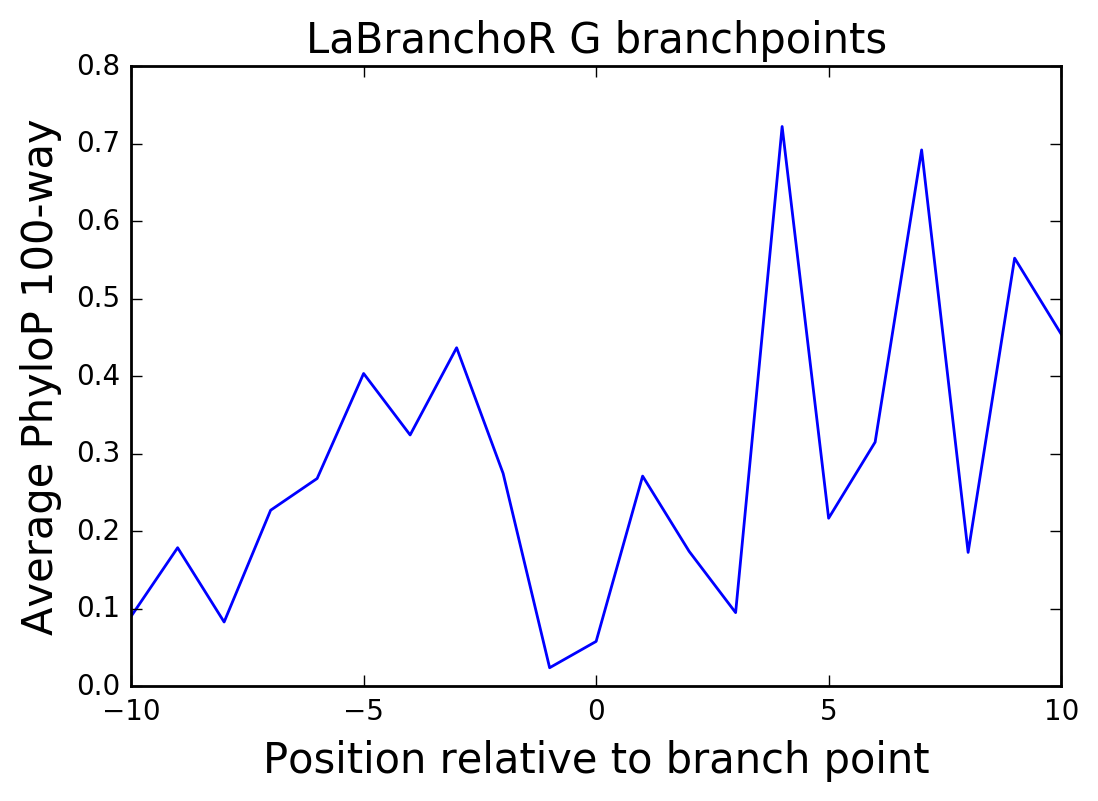

69


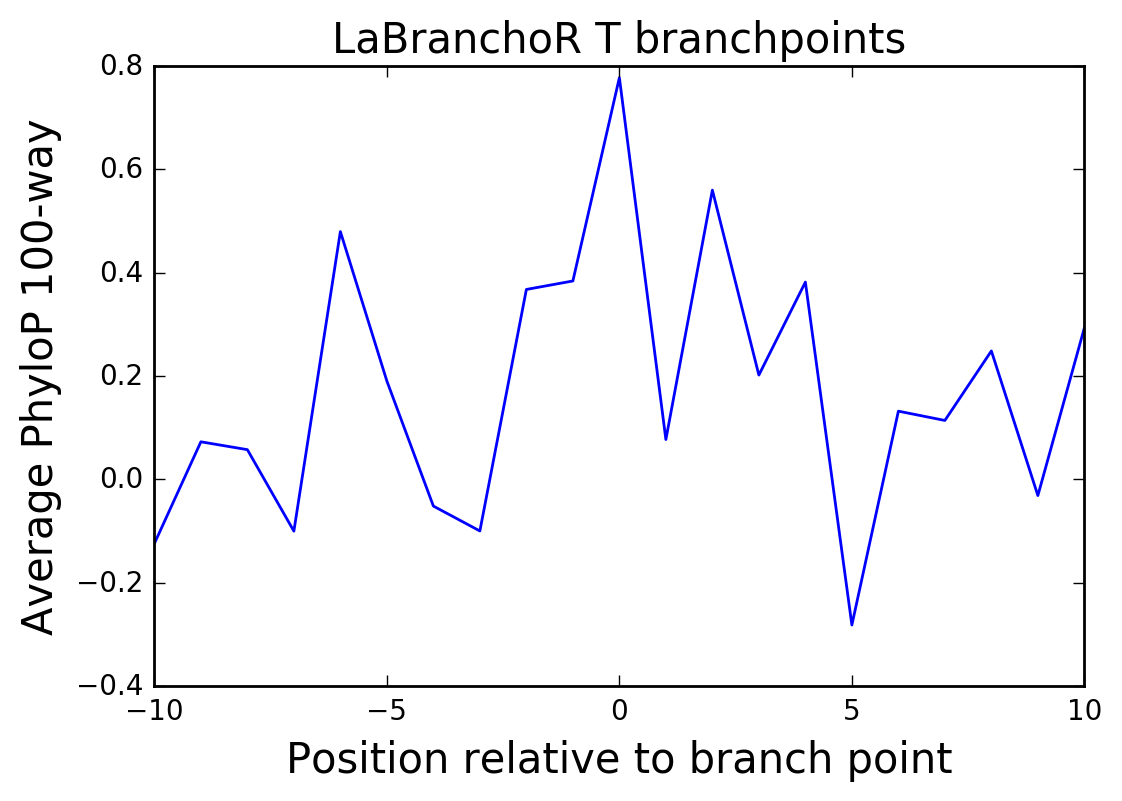

202549


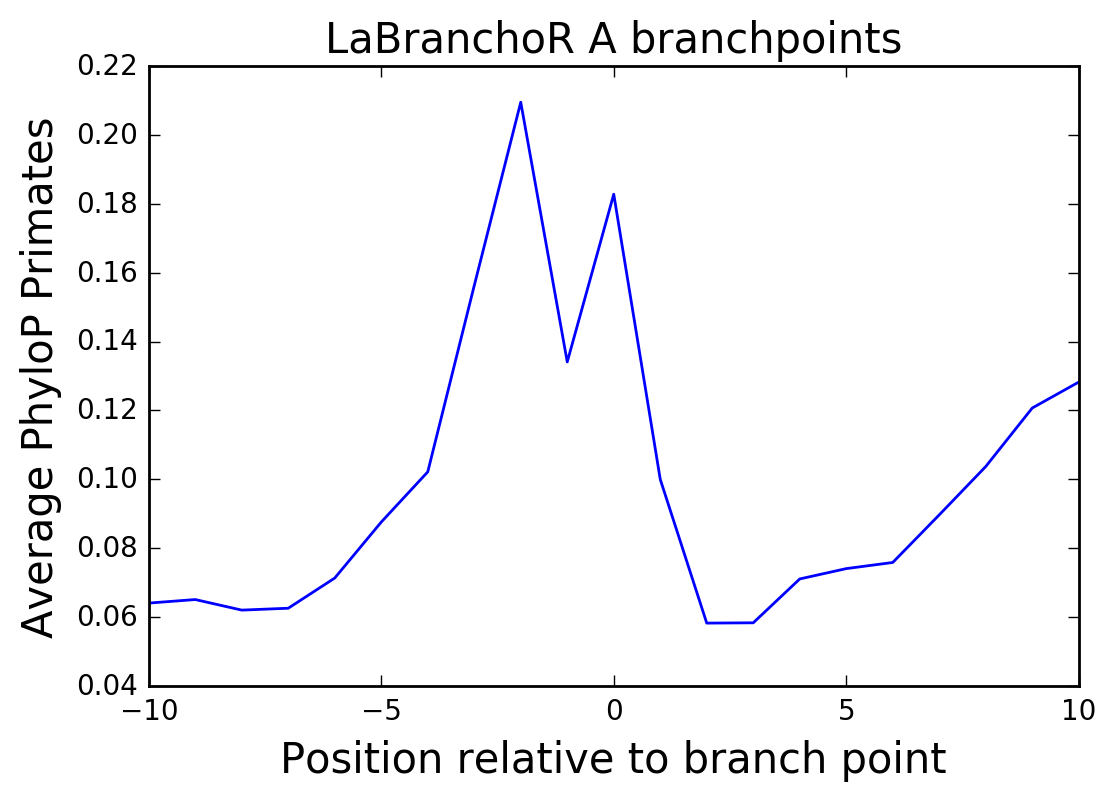

3347


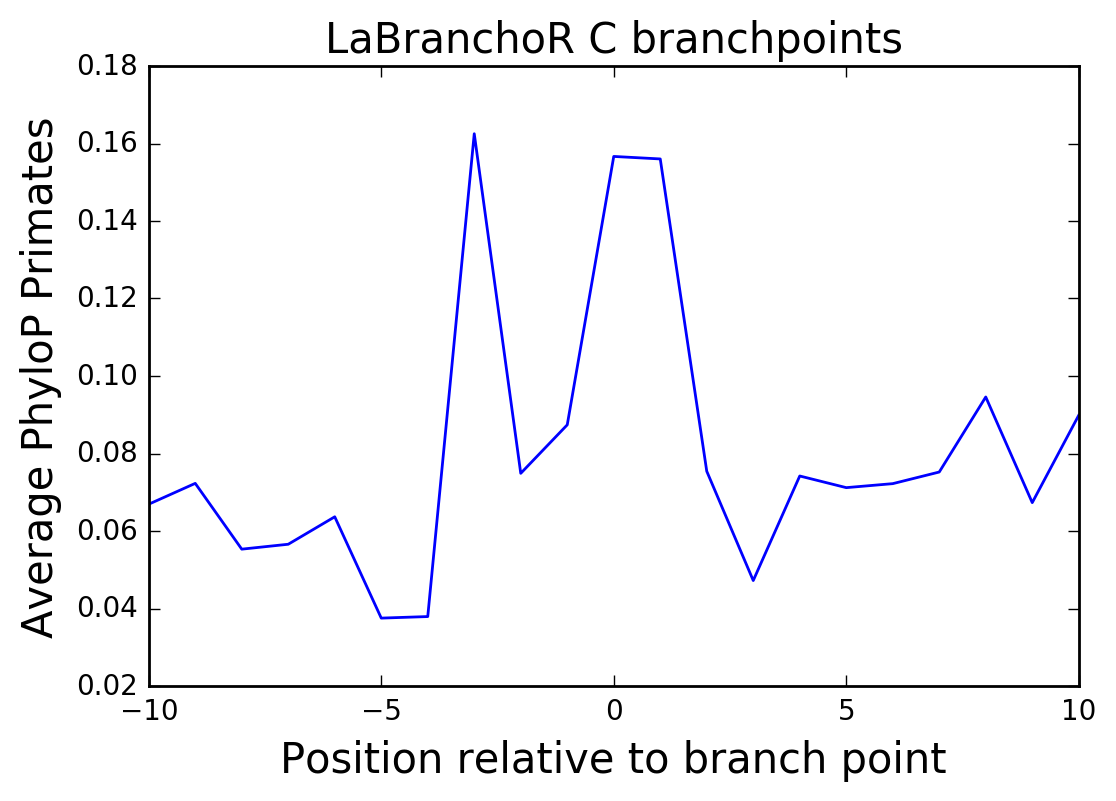

57


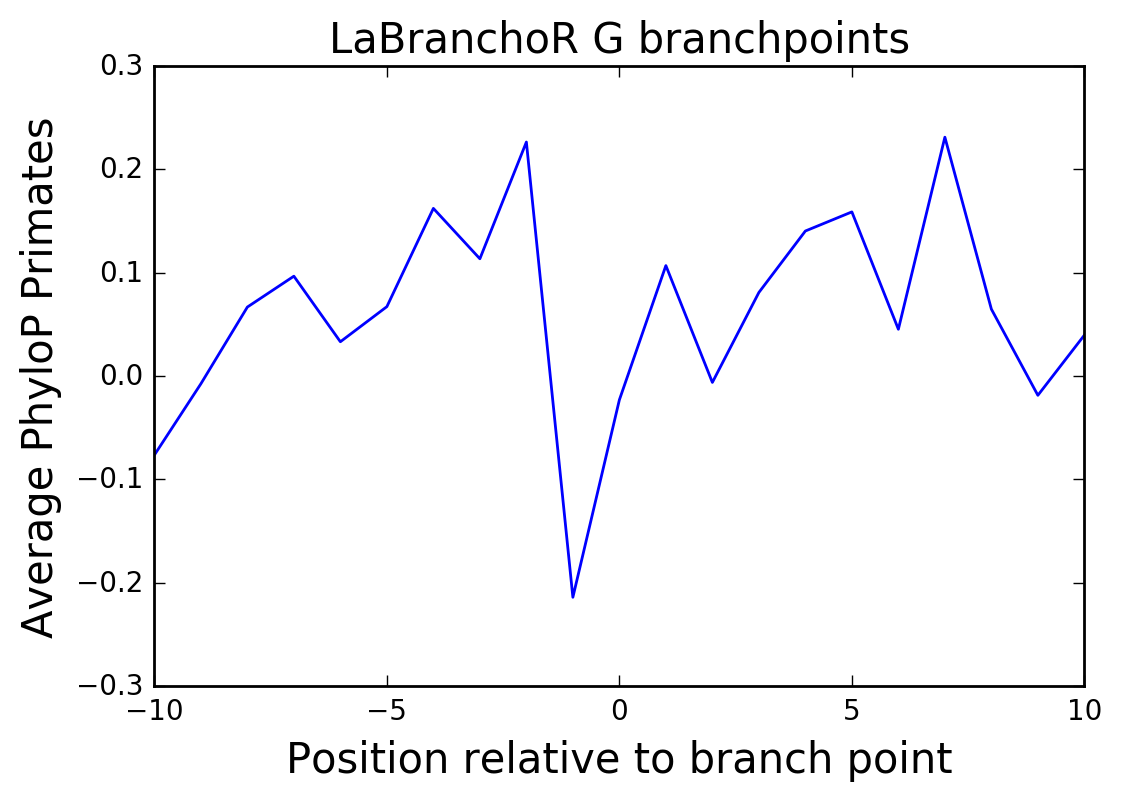

69


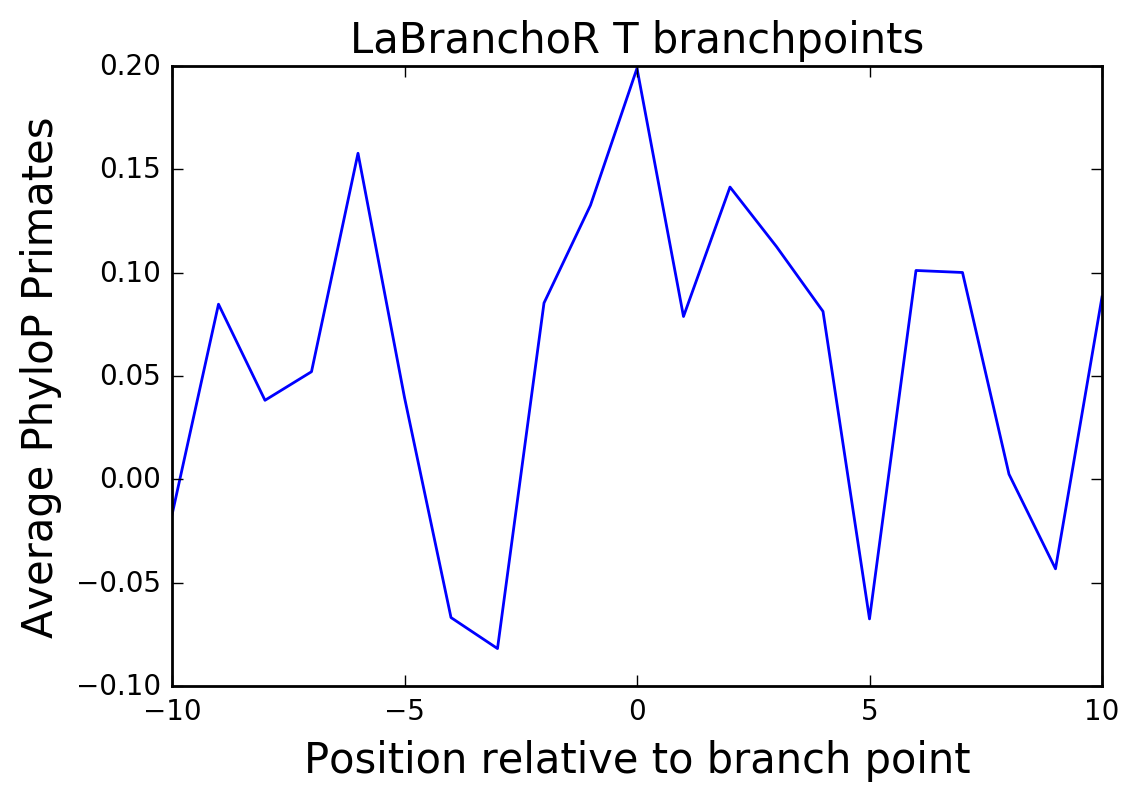

In [14]:
# By BP nucleotide

def cons_novel_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if not seq[bp, base]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_novel_base(X_all, y_all, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average Phastcons 100-way')
    plt.title("LaBranchoR {} branchpoints".format(base))
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average PhyloP 100-way')
    plt.title("LaBranchoR {} branchpoints".format(base))
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 6, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average PhyloP Primates')
    plt.title("LaBranchoR {} branchpoints".format(base))
    plt.show()

34080
22537


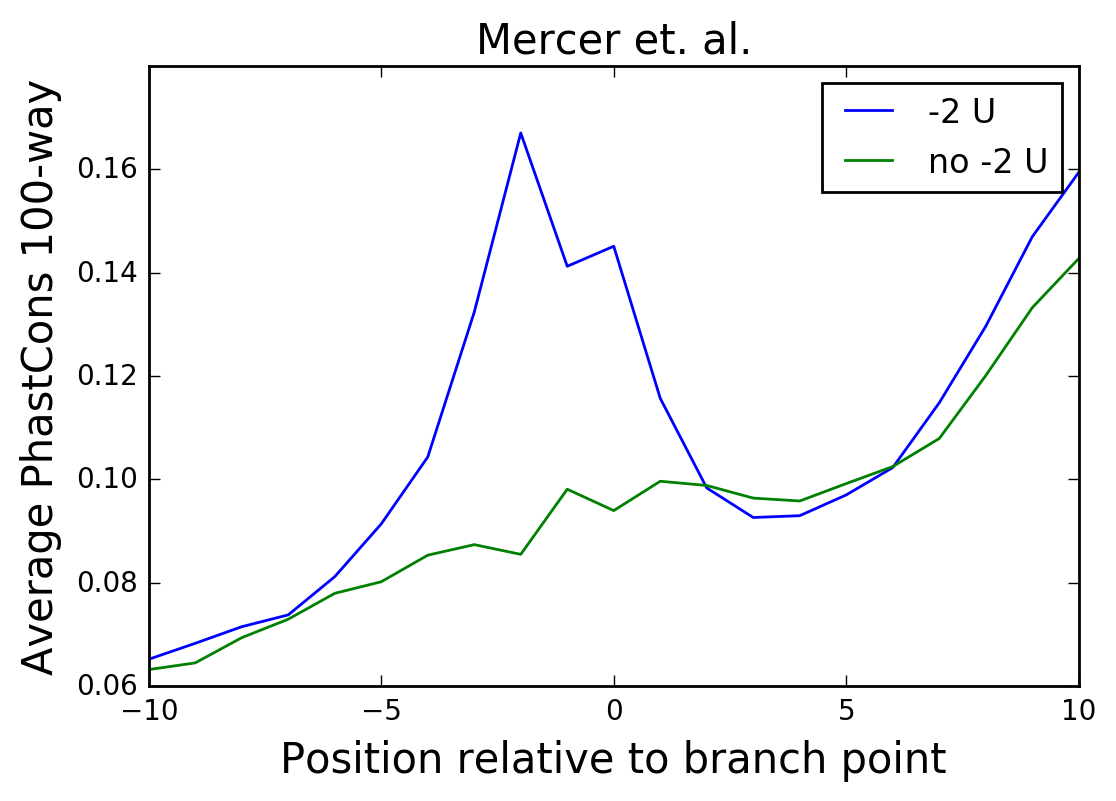

34080
22537


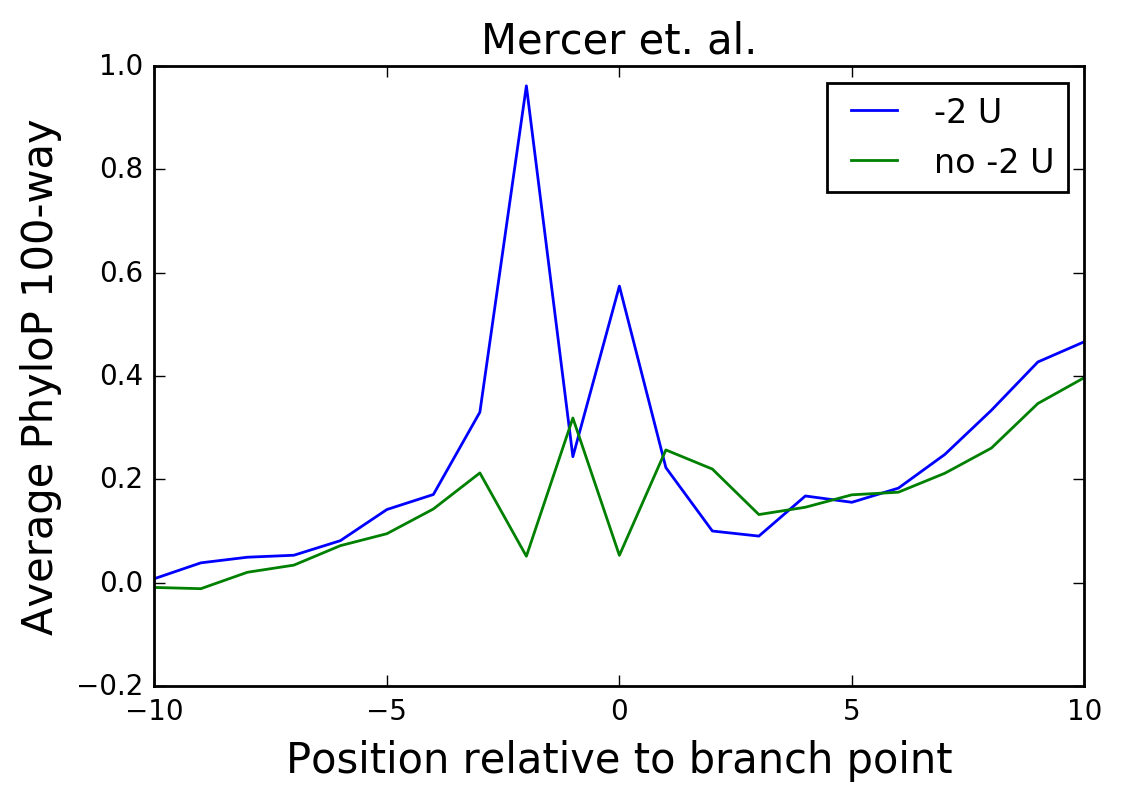

34080
22537


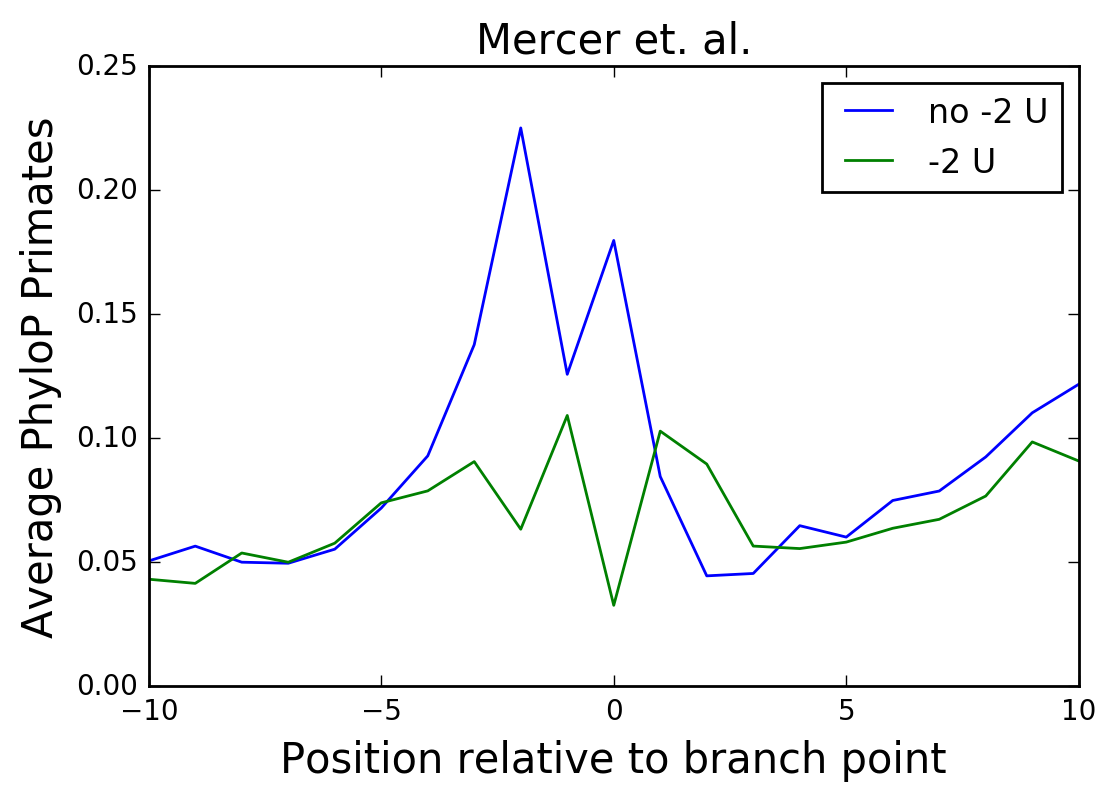

In [17]:
# No -2 T

def cons_known_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if T==seq[bp-2, 3]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

for t, name in enumerate(['-2 U','no -2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average PhastCons 100-way')
plt.title('Mercer et. al.')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

for t, name in enumerate(['-2 U','no -2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average PhyloP 100-way')
plt.title('Mercer et. al.')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

for t, name in enumerate(['no -2 U','-2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 6, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average PhyloP Primates')
plt.title('Mercer et. al.')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

167172
38850


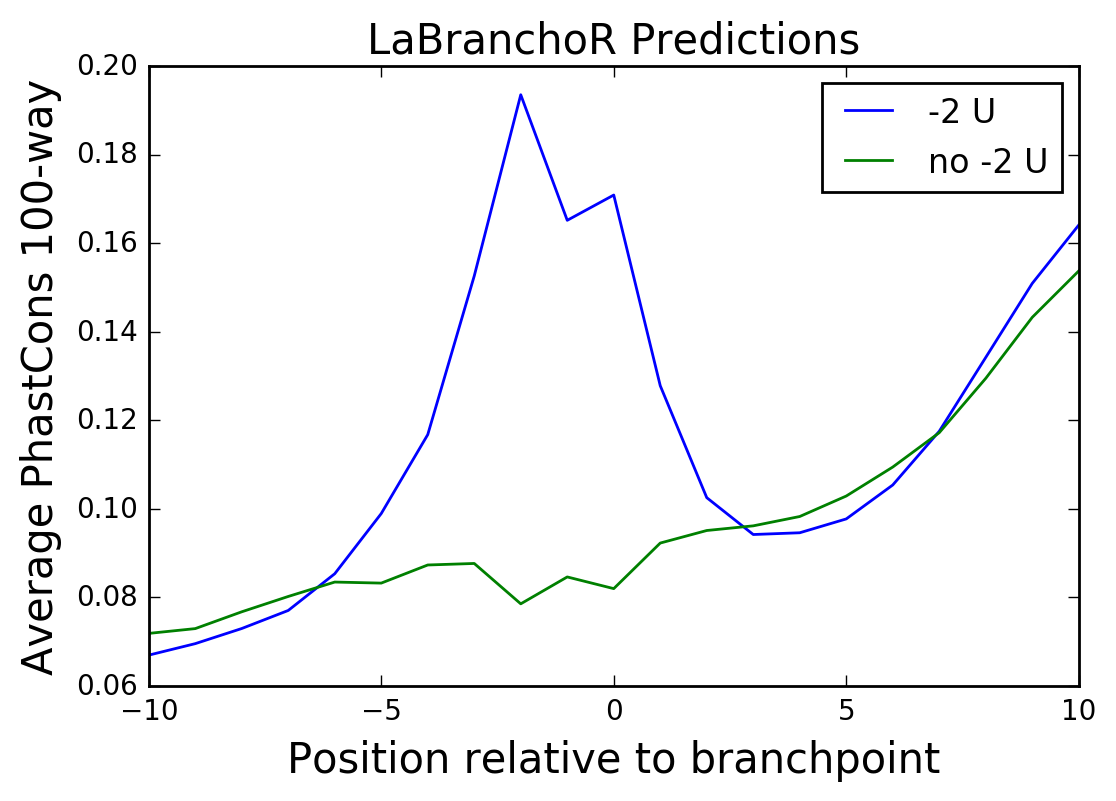

167172
38850


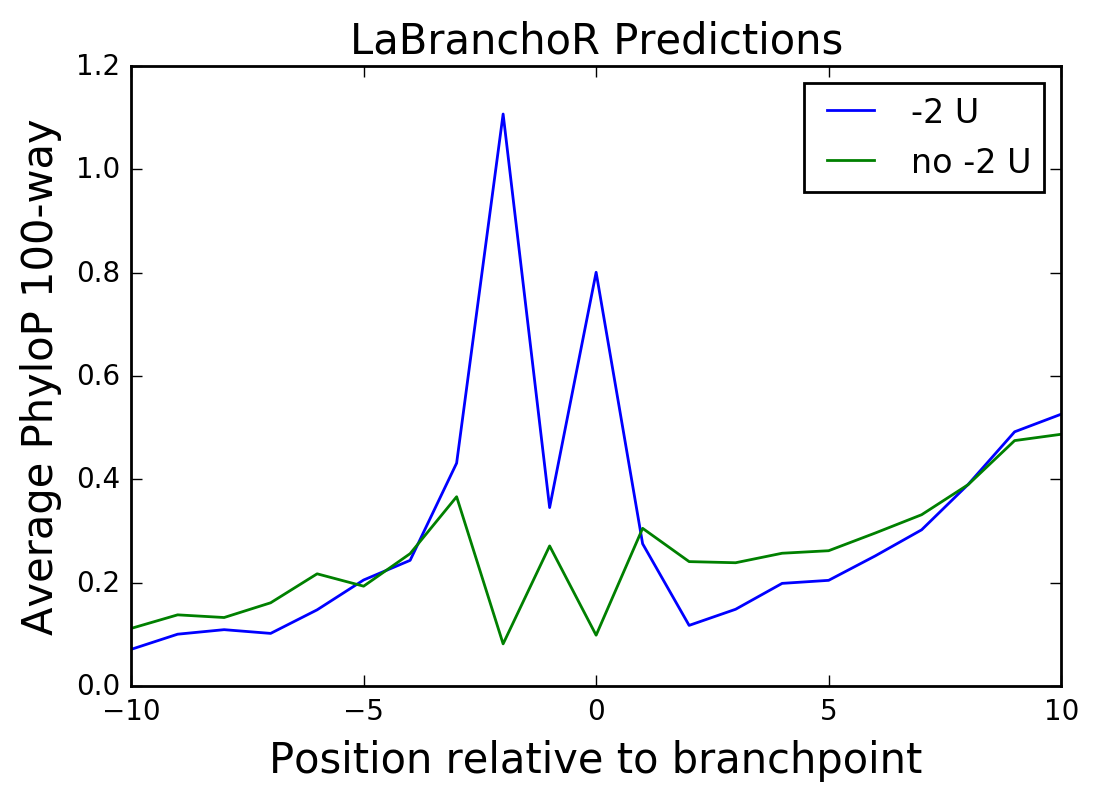

167172
38850


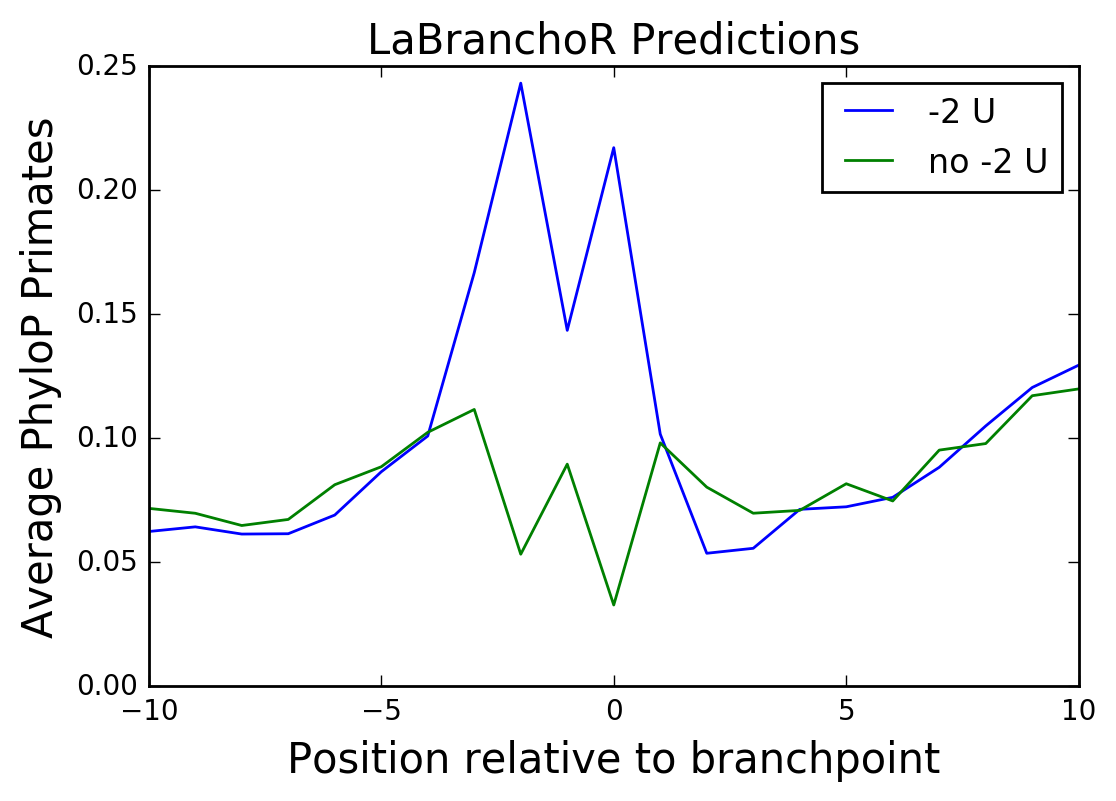

In [33]:
# No -2 T

def cons_novel_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if T==seq[bp-2, 3]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

for t, name in enumerate(['-2 U','no -2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 4, t), label = name)
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Average PhastCons 100-way')
plt.title('LaBranchoR Predictions')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

for t, name in enumerate(['-2 U','no -2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 5, t), label = name)
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Average PhyloP 100-way')
plt.title('LaBranchoR Predictions')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

for t, name in enumerate(['-2 U','no -2 U']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 6, t), label = name)
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Average PhyloP Primates')
plt.title('LaBranchoR Predictions')
plt.legend(loc = 'best', prop={'size':12})
plt.show()

# Scores

0.724096 0.56821
0.750678 0.595204


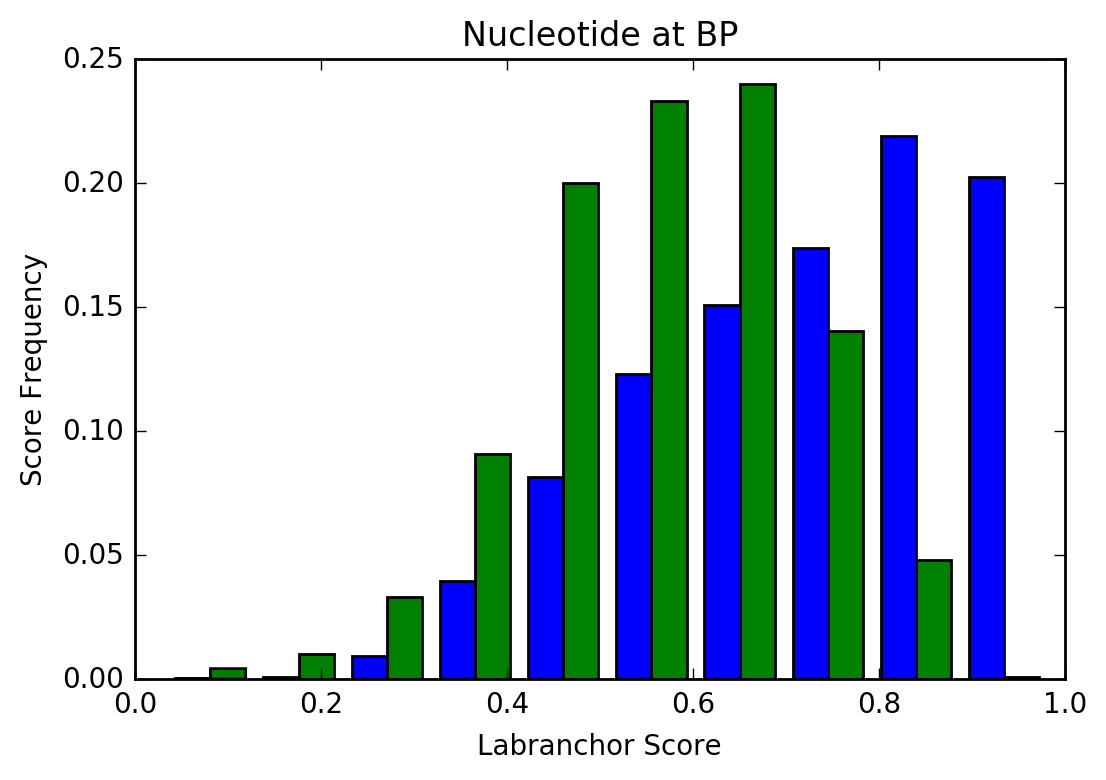

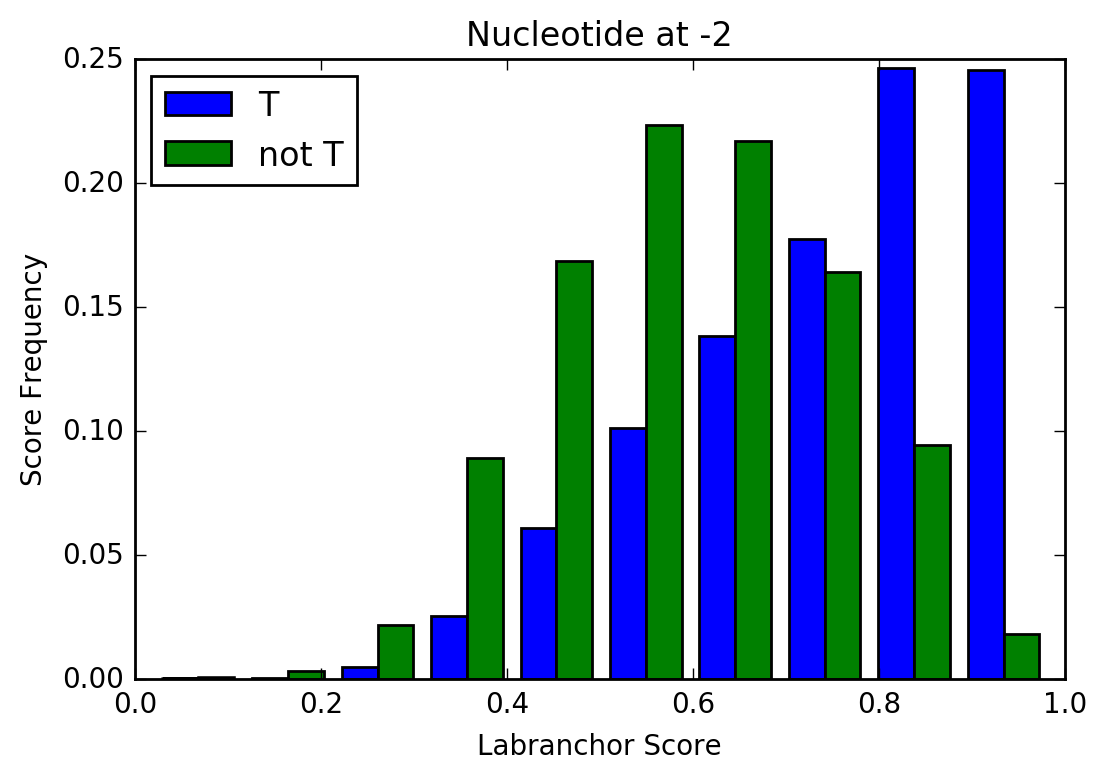

In [16]:
bp_a_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp, 0]:
        bp_a_scores += [score]
bp_a_scores = np.array(bp_a_scores)

bp_c_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp, 1]:
        bp_c_scores += [score]
bp_c_scores = np.array(bp_c_scores)

t2_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if seq[bp-2, 3]:
        t2_scores += [score]
t2_scores = np.array(t2_scores)
nt2_scores = []
for bp, score, seq in zip(np.argmax(y_all, axis = 1), np.max(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]:
        nt2_scores += [score]
nt2_scores = np.array(nt2_scores)

print bp_a_scores.mean(), bp_c_scores.mean()
print t2_scores.mean(), nt2_scores.mean()

w1 = np.ones_like(bp_a_scores)/float(bp_a_scores.shape[0])
w2 = np.ones_like(bp_c_scores)/float(bp_c_scores.shape[0])
plt.hist([bp_a_scores, bp_c_scores], weights = [w1, w2], label= ['A', 'C'])
plt.title('Nucleotide at BP')
plt.ylabel('Score Frequency')
plt.xlabel('Labranchor Score')
plt.show()

w1 = np.ones_like(t2_scores)/float(t2_scores.shape[0])
w2 = np.ones_like(nt2_scores)/float(nt2_scores.shape[0])
plt.hist([t2_scores, nt2_scores], weights = [w1, w2], label= ['T', 'not T'])
plt.legend(loc=2)
plt.title('Nucleotide at -2')
plt.ylabel('Score Frequency')
plt.xlabel('Labranchor Score')
plt.show()

# PPT conservation

I think the scores are dropping right at the 3' ss due to an index error in the bedtools run to extract the relevent scores.

34207
22601


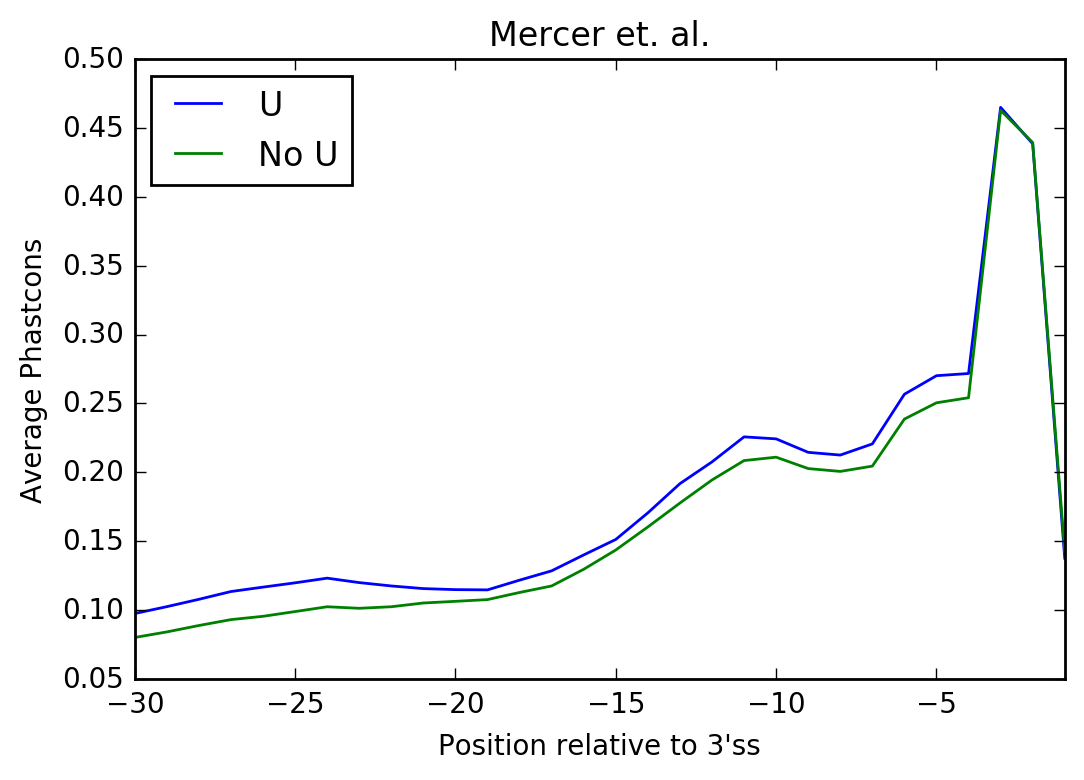

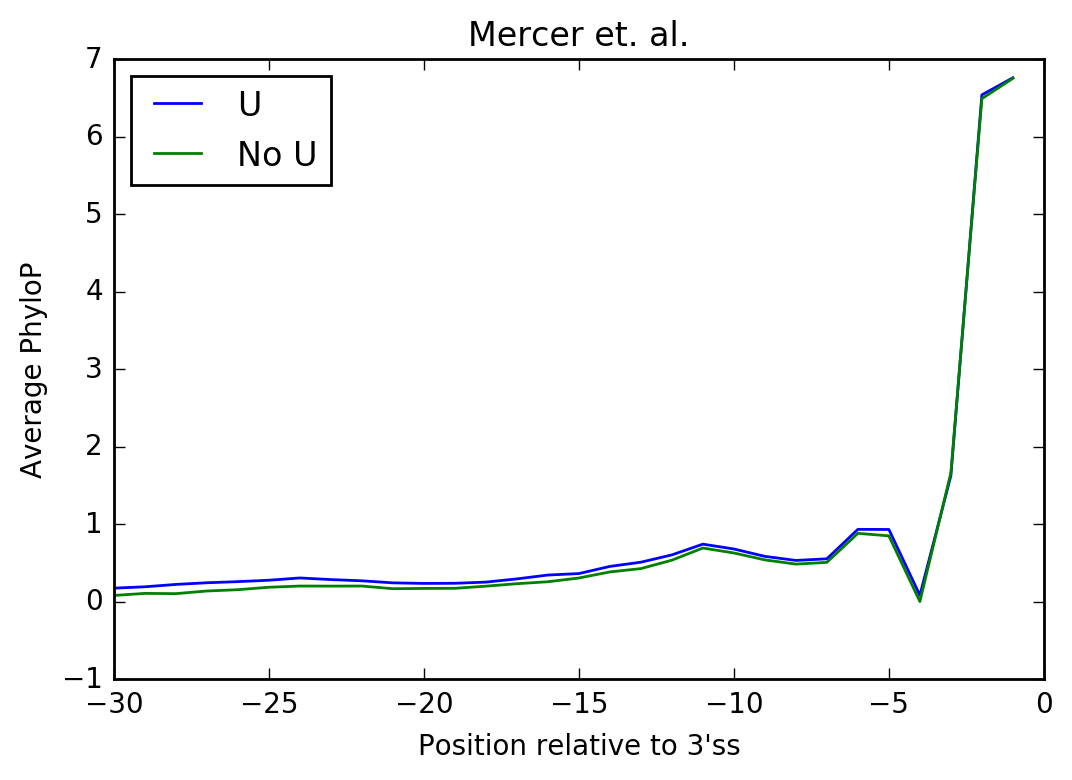

In [44]:
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        counts += seq[-30:, 4]
        total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'U')

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        counts += seq[-30:, 4]
        total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'No U')
plt.xlim(-30, -1)
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Mercer et. al.')
plt.show()

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        if not np.all(seq[-30:, 5]): continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'U')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        if not np.all(seq[-30:, 5]): continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'No U')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Mercer et. al.')
plt.show()

167365
38927


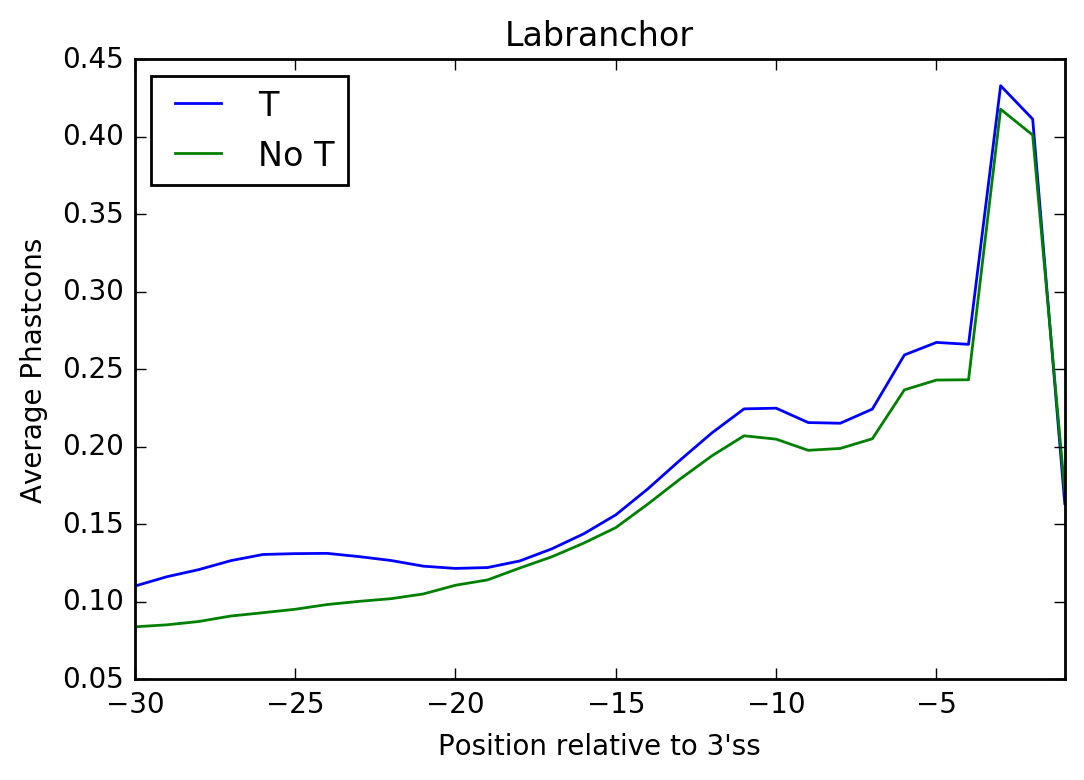

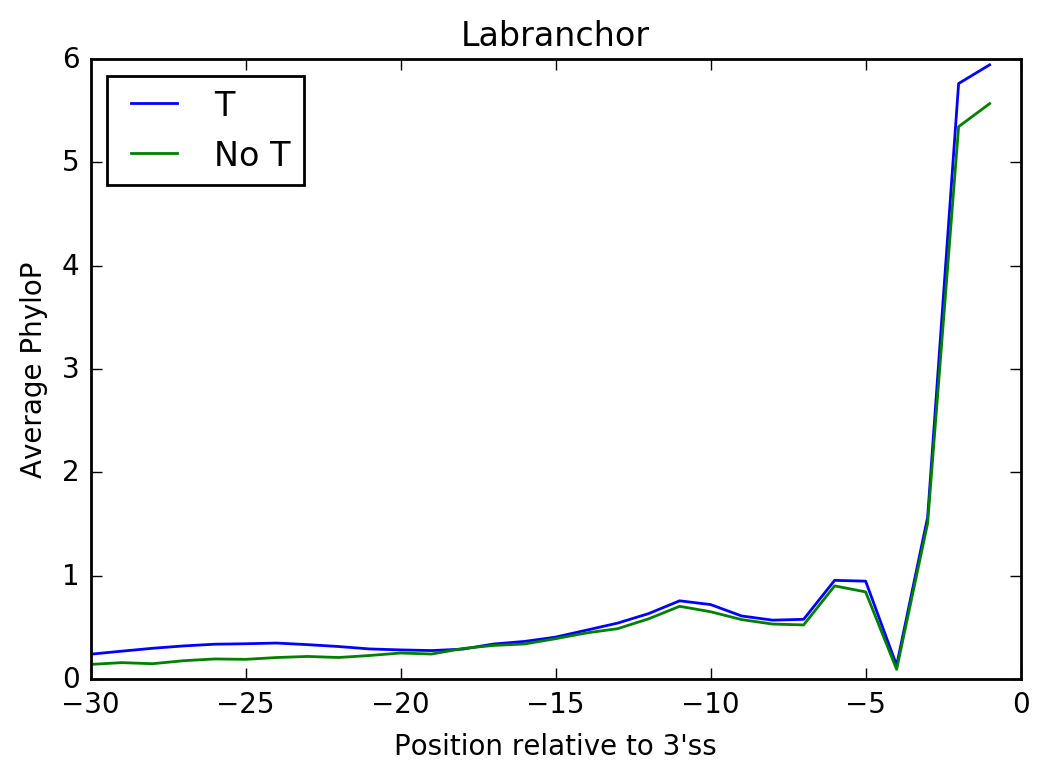

In [18]:
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]: continue
    counts += seq[-30:, 4]
    total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'T')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if seq[bp-2, 3]: continue
    counts += seq[-30:, 4]
    total += 1
print total
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.xlim(-30, -1)
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Labranchor')
plt.show()

counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp-2, 3]: continue
    if not np.all(seq[-30:, 5]): continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'T')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if seq[bp-2, 3]: continue
    if not np.all(seq[-30:, 5]): continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'No T')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Labranchor')
plt.show()

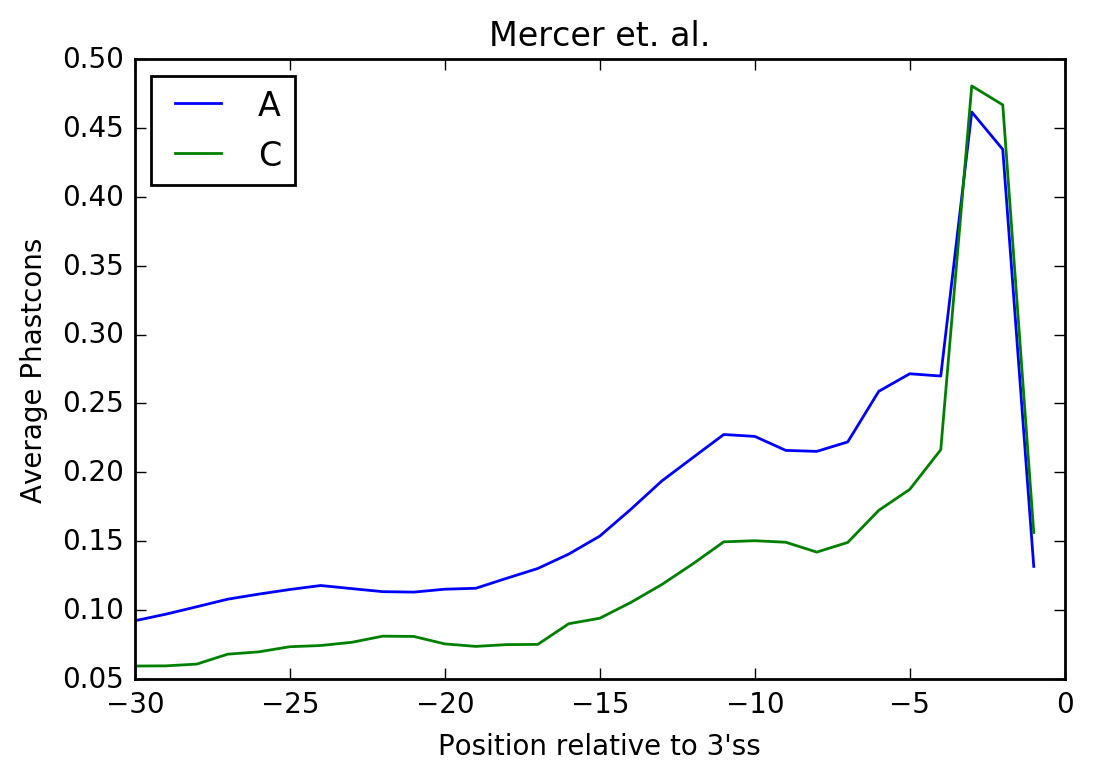

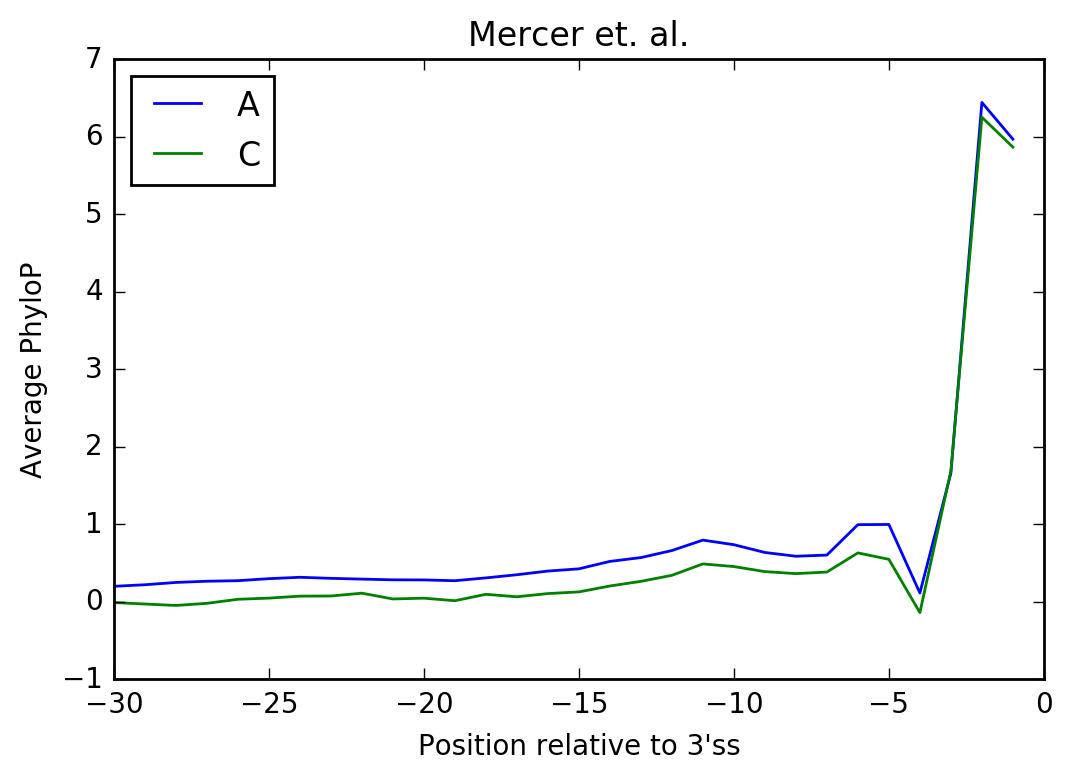

In [19]:
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        counts += seq[-30:, 4]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        counts += seq[-30:, 4]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Mercer et. al.')
plt.show()

counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        counts += seq[-30:, 5]
        total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Mercer et. al.')
plt.show()

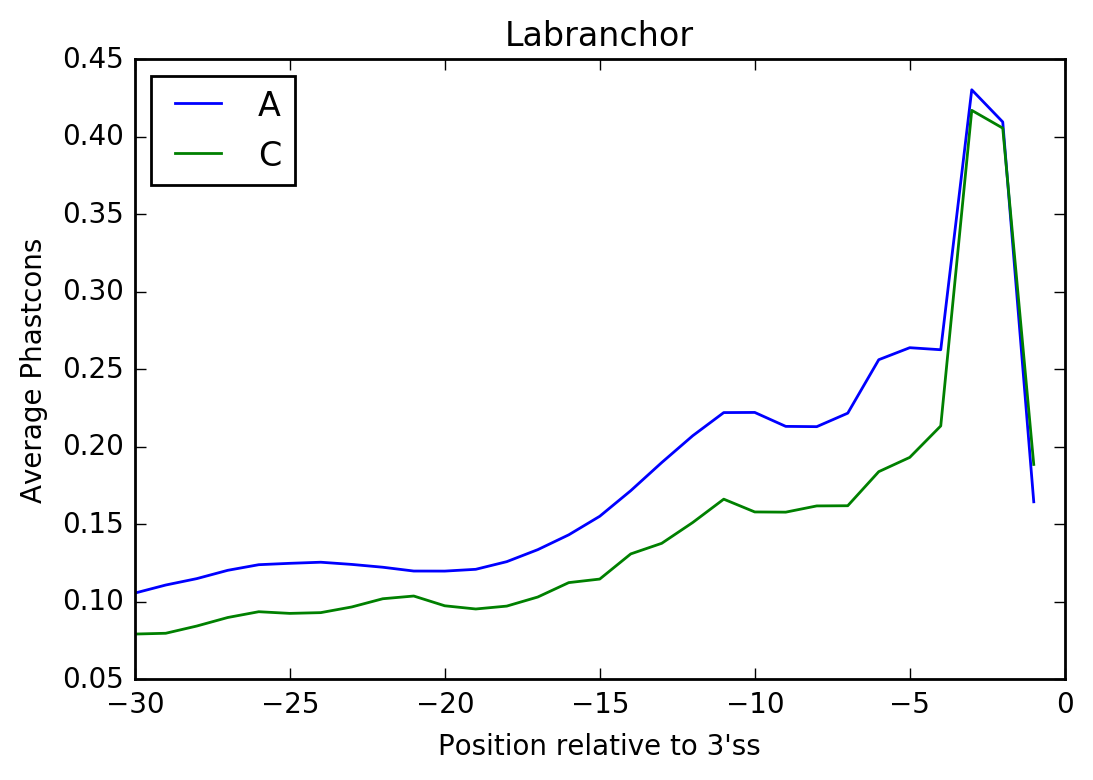

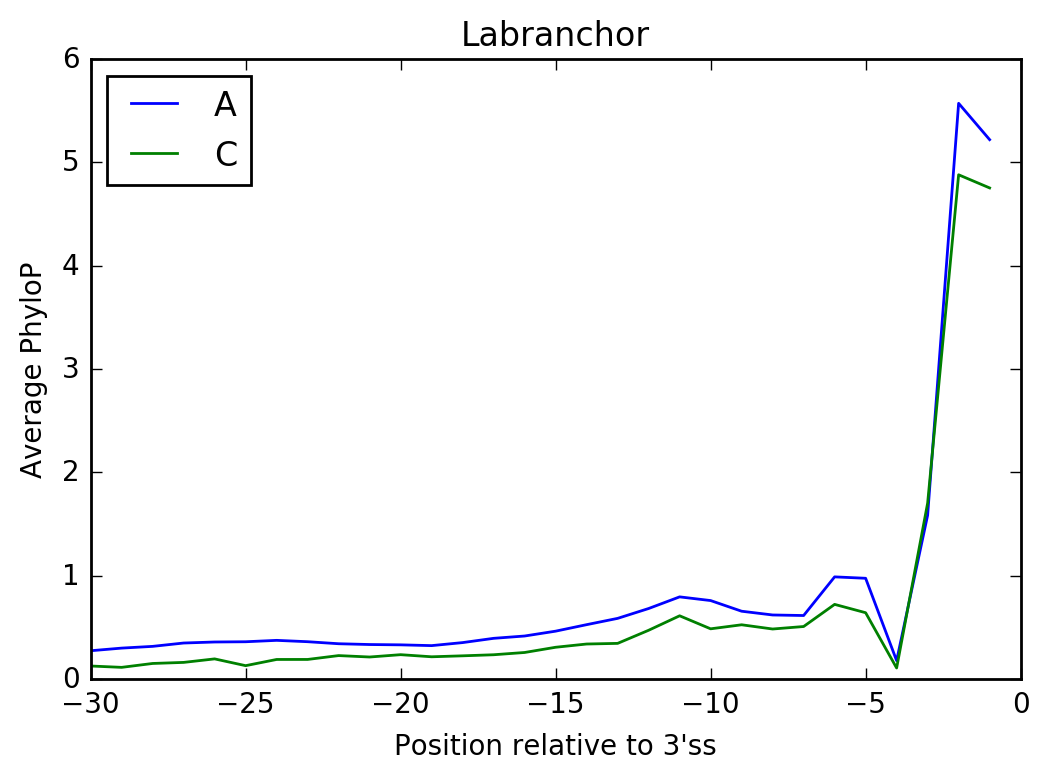

In [20]:
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 0]: continue
    counts += seq[-30:, 4]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 1]: continue
    counts += seq[-30:, 4]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average Phastcons')
plt.title('Labranchor')
plt.show()

counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 0]: continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'A')
counts = np.zeros((30,))
total = 0
for bp, seq in zip(np.argmax(y_all, axis = 1), X_all):
    if not seq[bp, 1]: continue
    counts += seq[-30:, 5]
    total += 1
plt.plot(range(-30, 0), counts / total, label = 'C')
plt.legend(loc = 2)
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Average PhyloP')
plt.title('Labranchor')
plt.show()

# 3' ss Strength

0


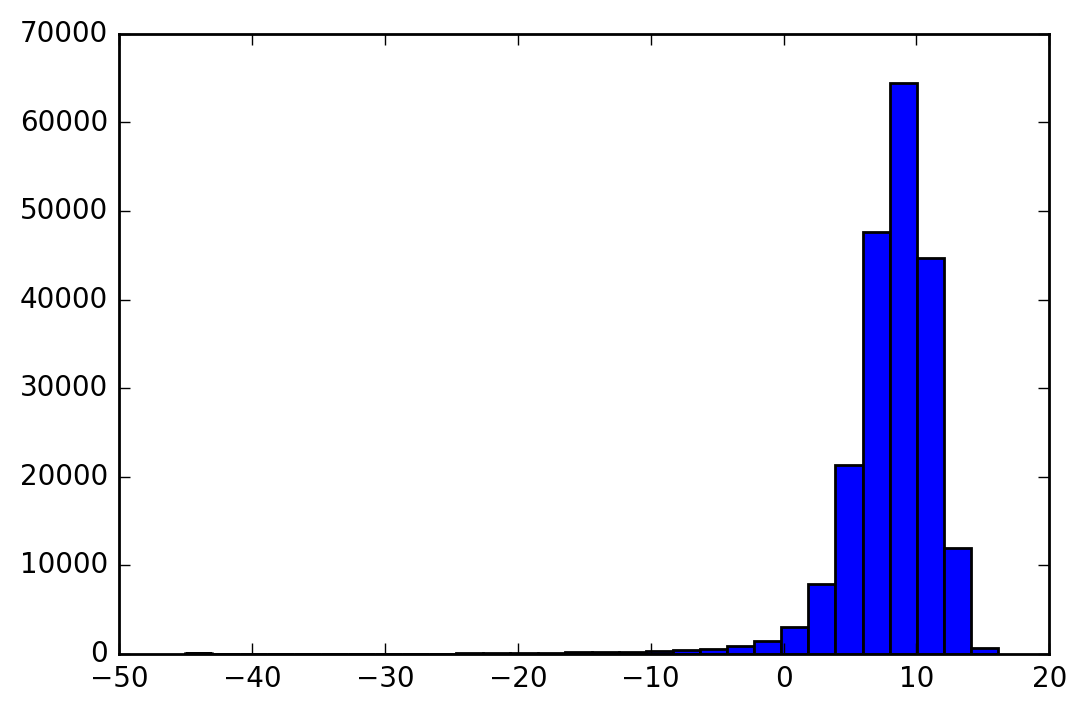

0


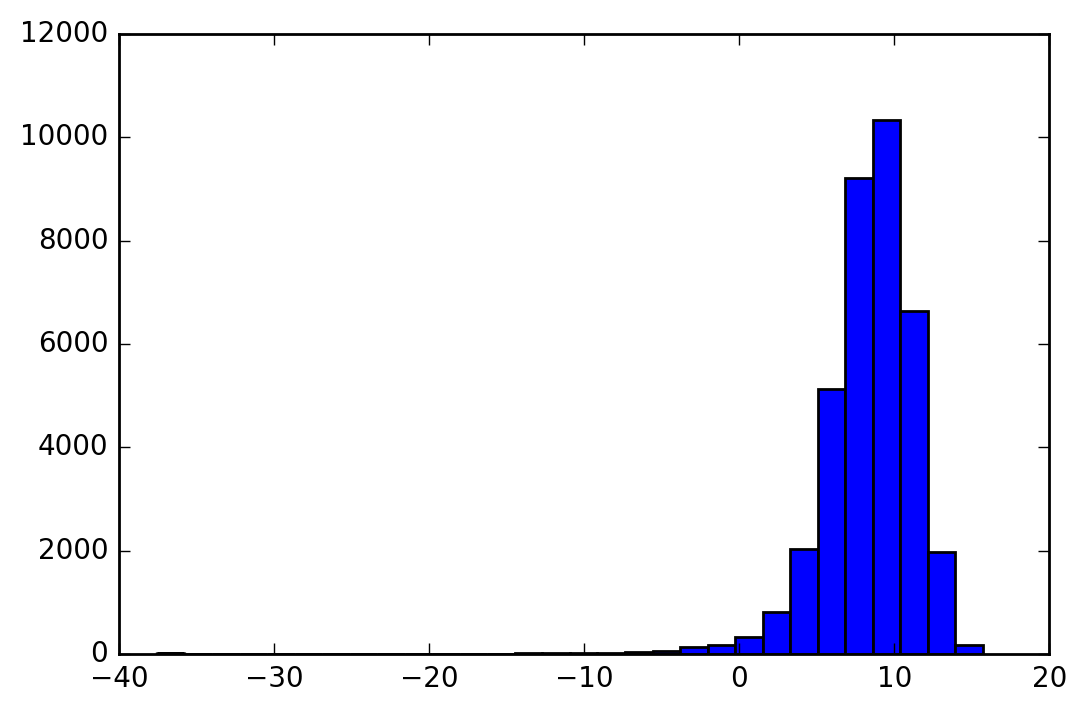

In [21]:
from MaxEntScan.maxentscan import maxentscan

def get_maxentscan(chroms, coords, strands):
    seqs = []
    haveN = 0
    for chrom, three, strand in zip(chroms, coords, strands):
        if strand == '+':
            begin, end = three-20, three+3
        else:
            begin, end = three-3, three+20
        seq = genome.get_seq(chrom, begin, end, strand)
        if 'N' in seq:
            haveN += 1
            seq = seq.replace('N', 'A')
        seqs += [seq]
    print haveN
    return maxentscan(seqs, False)

a_tpss = get_maxentscan(a_chroms, a_coords, a_strands)
plt.hist(a_tpss, bins = 30)
plt.show()

k_tpss = get_maxentscan(k_chroms, k_coords, k_strands)
plt.hist(k_tpss, bins = 30)
plt.show()

In [22]:
print np.mean(k_tpss)
print np.mean(a_tpss)
ranksums(k_tpss, a_tpss)

8.38305874427
8.0931817036


RanksumsResult(statistic=9.9912858569967149, pvalue=1.6640889360034472e-23)

In [23]:
from scipy.stats import ranksums
A = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 0]: continue
        A += [tpss]
        break
C = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp, 1]: continue
        C += [tpss]
        break
print np.mean(A)
print np.mean(C)
print ranksums(A, C)

T = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        T += [tpss]
        break
noT = []
for seq, target, tpss in zip(X_known, y_known, k_tpss):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        noT += [tpss]
        break

print np.mean(T)
print np.mean(noT)
print ranksums(T, noT)

8.36258843881
9.03491223182
RanksumsResult(statistic=-15.841135545102876, pvalue=1.6187108383482658e-56)
8.33065509655
8.48947257511
RanksumsResult(statistic=-6.814954510815225, pvalue=9.4293597528464791e-12)


In [24]:
A = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp, 0]: continue
    A += [tpss]
C = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp, 1]: continue
    C += [tpss]
print np.mean(A)
print np.mean(C)
print ranksums(A, C)

T = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if not seq[bp-2, 3]: continue
    T += [tpss]
noT = []
for seq, bp, tpss in zip(X_all, np.argmax(y_all, axis = 1), a_tpss):
    if seq[bp-2, 3]: continue
    noT += [tpss]

print np.mean(T)
print np.mean(noT)
print ranksums(T, noT)

8.08877133123
8.39643198091
RanksumsResult(statistic=-11.613671482206062, pvalue=3.5120482219162356e-31)
8.08755827085
8.11735941634
RanksumsResult(statistic=-14.350990965308906, pvalue=1.0502572513198669e-46)


SpearmanrResult(correlation=0.064319746803452121, pvalue=5.3944090748302356e-188)


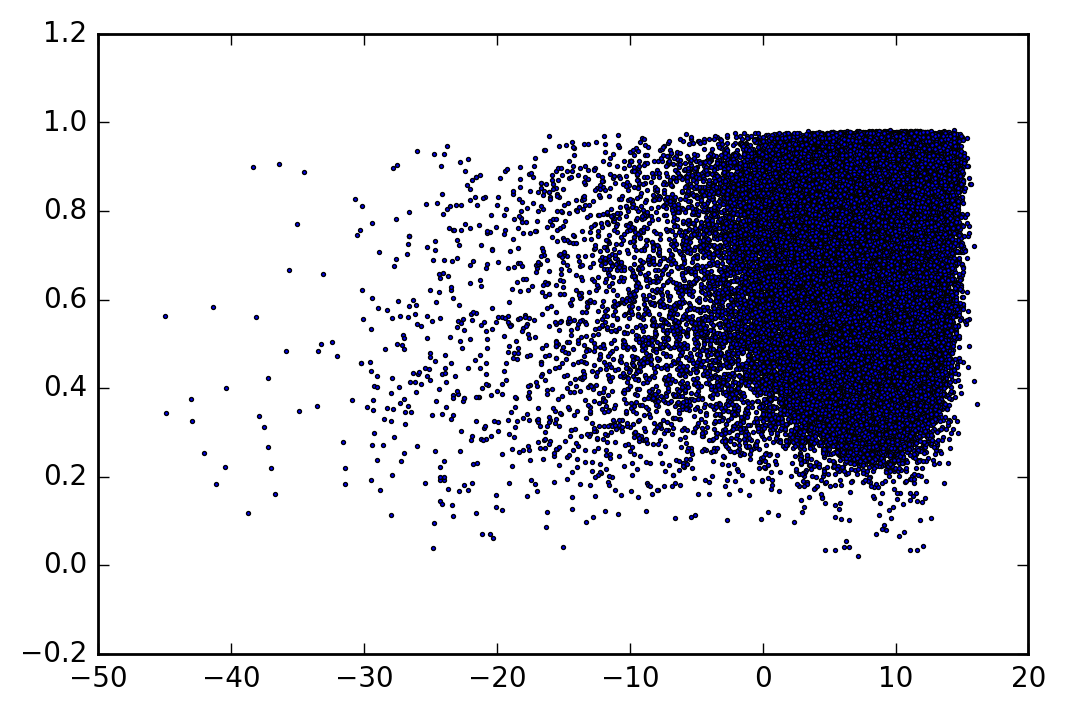

In [25]:
# Exact opposite of what I would have expected?
# Strange that -2T has opposite trend
# Perhaps this highlights that the score
# ... is not a measure of BP strength, but a probability
# ... that it is a branchpoint?

from scipy.stats import spearmanr
print spearmanr(a_tpss, np.max(y_all, axis=1))
plt.scatter(a_tpss, np.max(y_all, axis=1), s = 2, lw = 0.5)
plt.show()

SpearmanrResult(correlation=-0.01902313684896257, pvalue=5.5762096575966252e-18)


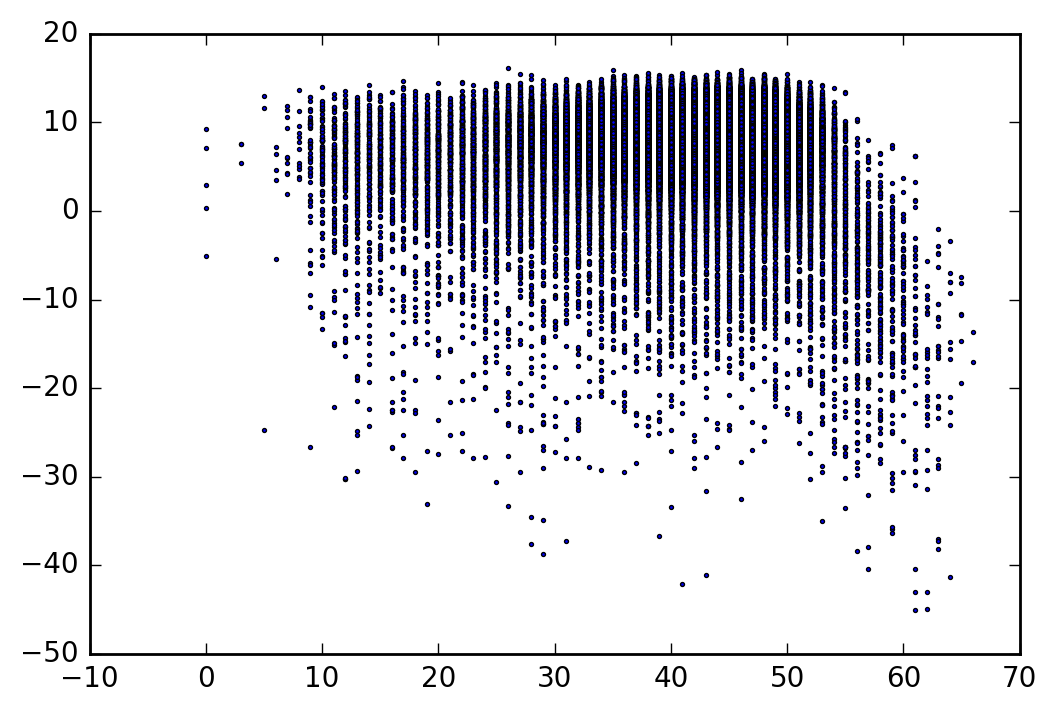

In [26]:
print spearmanr(np.argmax(y_all, axis=1), a_tpss)
plt.scatter(np.argmax(y_all, axis=1), a_tpss, s = 2, lw = 0.5)
plt.show()

# Skipped Exons

Don't look at known here because sets would likely be too small.

In [27]:
se = {}
total = 0
c = set(a_coords)
with open('/Users/jpaggi/Downloads/hg19/SE.hg19.gff3') as fp:
    print fp.readline().strip()
    n = 3
    for line in fp:
        chrom, _, gene, begin, end, _, strand = line.split('\t')[:7]
        if gene == 'gene': continue
        if n == 4:
            assert gene == 'exon'
            if chrom not in se: se[chrom] = set()
            three = int(begin)-1 if strand == '+' else int(end)
            total += three in c
            se[chrom].add(three)
            n = 0
        elif gene == 'exon':
            n += 1
print total

#GFF3 file (created by gffutils (v0.8) on 2013-09-27 21:07:42)
30178


In [28]:
from scipy.stats import chi2_contingency, fisher_exact
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    skipped1 += coord in se[chrom]
    total1 += 1
print 'A Branchpoints'
print skipped1, total1
print skipped1 / float(total1)

total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    skipped2 += coord in se[chrom]
    total2 += 1
print 'C Branchpoints'
print skipped2, total2
print skipped2 / float(total2)


print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1-skipped1], [skipped2, total2-skipped2]])
print fisher_exact([[skipped2, total2-skipped2], [skipped1, total1-skipped1]])

A Branchpoints
24333 202813
0.119977516234
C Branchpoints
487 3352
0.145286396181
1.21094685689
(19.707598403100981, 9.0241837689612675e-06, 1, array([[  24416.45604249,  178396.54395751],
       [    403.54395751,    2948.45604249]]))
(1.2468041411167579, 1.4312839516675034e-05)


In [29]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    skipped1 += coord in se[chrom]
    total1 += 1
print 'T branchpoints Branchpoints'
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    skipped2 += coord in se[chrom]
    total2 += 1

print 'no T branchpoints Branchpoints'
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1-skipped1], [skipped2, total2-skipped2]])
print fisher_exact([[skipped2, total2-skipped2], [skipped1, total1-skipped1]])

T branchpoints Branchpoints
19733 167365
0.117903982314
no T branchpoints Branchpoints
5104 38927
0.131117219411
1.11206777615
(51.940602028622791, 5.7205198287984651e-13, 1, array([[  20150.29426735,  147214.70573265],
       [   4686.70573265,   34240.29426735]]))
(1.1289791657155983, 9.1283164949292556e-13)


In [30]:
down_se = {}
total = 0
c = set(a_coords)
with open('/Users/jpaggi/Downloads/hg19/SE.hg19.gff3') as fp:
    print fp.readline().strip()
    n = 2
    for line in fp:
        chrom, _, gene, begin, end, _, strand = line.split('\t')[:7]
        if gene == 'gene': continue
        if n == 4:
            assert gene == 'exon'
            if chrom not in down_se: down_se[chrom] = set()
            three = int(begin)-1 if strand == '+' else int(end)
            total += three in c
            down_se[chrom].add(three)
            n = 0
        elif gene == 'exon':
            n += 1
print total

#GFF3 file (created by gffutils (v0.8) on 2013-09-27 21:07:42)
31638


In [31]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    skipped1 += coord in down_se[chrom]
    total1 += 1
print 'A Branchpoints'
print skipped1, total1
print skipped1 / float(total1)

total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    skipped2 += coord in down_se[chrom]
    total2 += 1
print 'C Branchpoints'
print skipped2, total2
print skipped2 / float(total2)


print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1-skipped1], [skipped2, total2-skipped2]])
print fisher_exact([[skipped2, total2-skipped2], [skipped1, total1-skipped1]])

A Branchpoints
22171 202813
0.109317450065
C Branchpoints
332 3352
0.0990453460621
0.906034178471
(3.4734153159650334, 0.062362427058454198, 1, array([[  22137.12773264,  180675.87226736],
       [    365.87226736,    2986.12773264]]))
(0.89570416100502381, 0.061290075121703057)


In [32]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    skipped1 += coord in down_se[chrom]
    total1 += 1
print 'T branchpoints Branchpoints'
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    skipped2 += coord in down_se[chrom]
    total2 += 1

print 'no T branchpoints Branchpoints'
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1-skipped1], [skipped2, total2-skipped2]])
print fisher_exact([[skipped2, total2-skipped2], [skipped1, total1-skipped1]])

T branchpoints Branchpoints
18607 167365
0.11117617184
no T branchpoints Branchpoints
3905 38927
0.100315976058
0.90231543682
(38.202676315389489, 6.3764903822229563e-10, 1, array([[  18264.01838171,  149100.98161829],
       [   4247.98161829,   34679.01838171]]))
(0.89142347693114621, 4.4737945039704363e-10)


# Retained introns

In [33]:
ri = {}
total = 0
c = set(a_coords)
with open('/Users/jpaggi/Downloads/hg19/RI.hg19.gff3') as fp:
    print fp.readline().strip()
    n = 0
    for line in fp:
        chrom, _, gene, begin, end, _, strand = line.split('\t')[:7]
        if gene == 'gene': continue
        if n and gene == 'exon':
            if n == 1 and strand == '+':
                n = 2
                continue
            if chrom not in ri: ri[chrom] = set()
            three = int(begin)-1 if strand == '+' else int(end)
            total += three in c
            ri[chrom].add(three)
            n = 0
        else:
            n = 1
print total

#GFF3 file (created by gffutils (v0.8) on 2013-09-27 21:15:33)
7789


In [34]:
from scipy.stats import chi2_contingency
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    skipped1 += coord in ri[chrom]
    total1 += 1
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    skipped2 += coord in ri[chrom]
    total2 += 1
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

6265 202813
0.0308905247691
244 3352
0.0727923627685
2.35646248526
(169.77527914305742, 8.2841499188278596e-39, 1, array([[  6.39894252e+03,   2.02679057e+05],
       [  1.10057478e+02,   3.48594252e+03]]))
(2.3564624852621012, 5.0823413414432944e-30)


In [35]:
total1, skipped1 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    skipped1 += coord in ri[chrom]
    total1 += 1
print skipped1, total1
print skipped1 / float(total1)
total2, skipped2 = 0, 0
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    skipped2 += coord in ri[chrom]
    total2 += 1
print skipped2, total2
print skipped2 / float(total2)

print (skipped2 / float(total2)) / (skipped1 / float(total1))
print chi2_contingency([[skipped1, total1], [skipped2, total2]])
print fisher_exact([[skipped2, total2], [skipped1, total1]], 'greater')

4935 167365
0.0294864517671
1584 38927
0.0406915508516
1.38000839073
(120.46698959232641, 4.9991762226013575e-28, 1, array([[   5278.0340302,  167021.9659698],
       [   1240.9659698,   39270.0340302]]))
(1.3800083907349607, 8.9658039474220117e-27)


# Intron Length

Again, don't look at known here.

U
Median:  1654.0
Mean:  6621.87489618
3012.36726229
no U
Median:  1314.0
Mean:  5153.03581062
2660.17456433


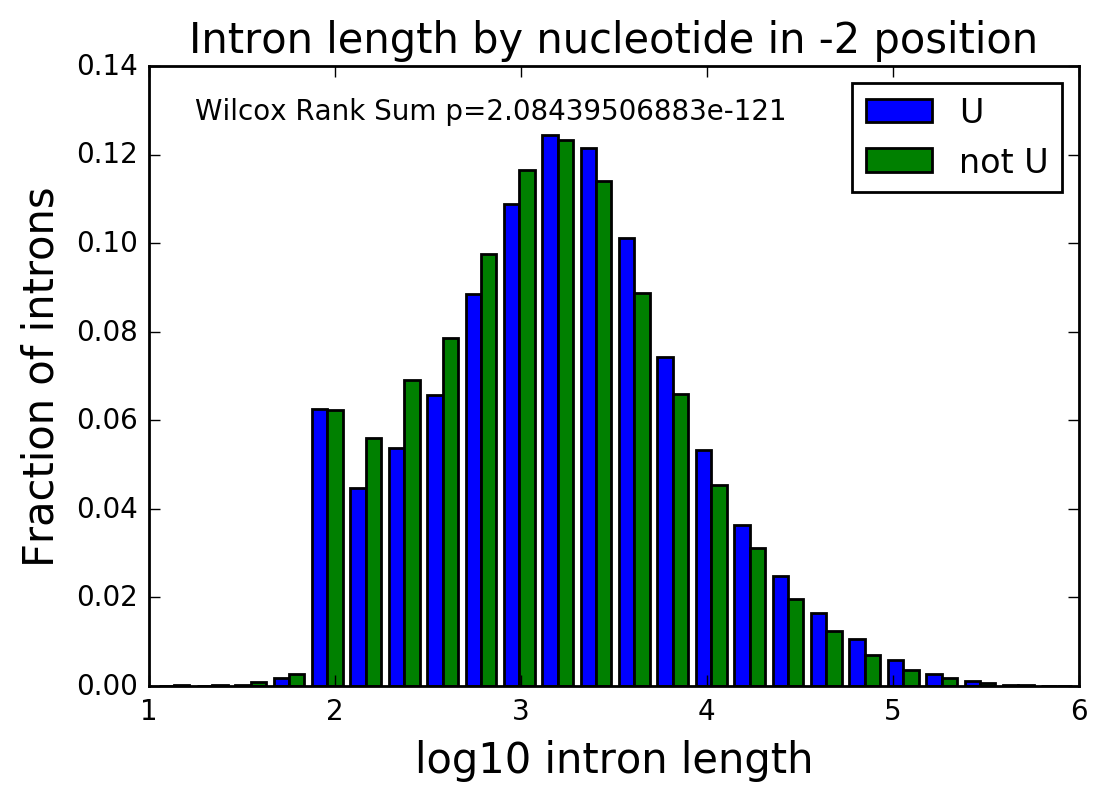

In [20]:
l1 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp-2, 3]: continue
    l1 += [lengths[(chrom, coord)]]
l1 = np.array(l1)
l2 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if seq[bp-2, 3]: continue
    l2 += [lengths[(chrom, coord)]]
l2 = np.array(l2)

print 'U'
print 'Median: ', np.median(l1)
print 'Mean: ', np.mean(l1)
print np.mean(l1[np.log(l1) < 10])
print 'no U'
print 'Median: ', np.median(l2)
print 'Mean: ', np.mean(l2)
print np.mean(l2[np.log(l2) < 10])

# Get and write pval
_, pval = ranksums(l1, l2)
f, ax = plt.subplots()
ax.text(0.05, 0.95, 'Wilcox Rank Sum p='+str(pval), transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

# Make normalized histogram
w1 = np.ones_like(l1)/float(l1.shape[0])
w2 = np.ones_like(l2)/float(l2.shape[0])
plt.hist([np.log10(l1), np.log10(l2)], weights = [w1, w2], label= ['U', 'not U'], bins = 30)
plt.legend(loc = 'best', prop={'size':12})
plt.xlim(1, 6)
plt.title('Intron length by nucleotide in -2 position')
plt.ylabel('Fraction of introns')
plt.xlabel('log10 intron length')
plt.show()

A
Median:  1603.0
Mean:  6389.46358468
2962.80394959
C
Median:  807.0
Mean:  3743.18317422
1925.05102982


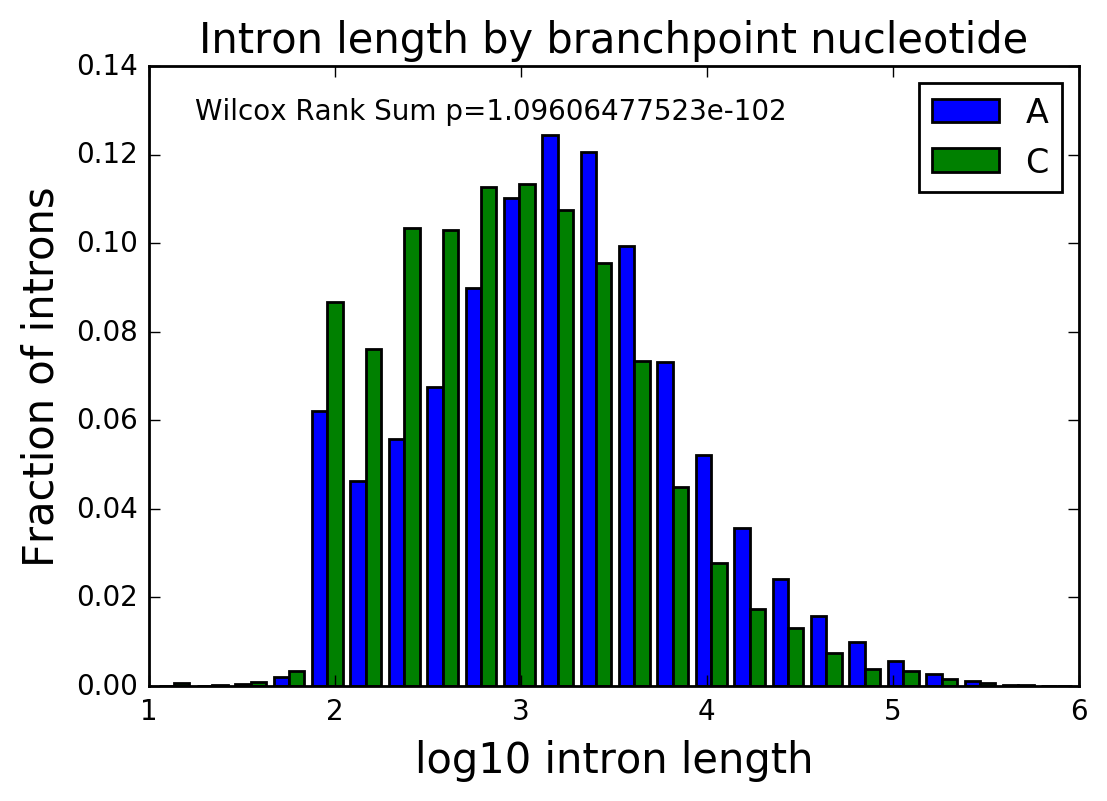

In [21]:
l1 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 0]: continue
    l1 += [lengths[(chrom, coord)]]
l1 = np.array(l1)

l2 = []
for bp, seq, chrom, coord in zip(np.argmax(y_all, axis = 1), X_all, a_chroms, a_coords):
    if not seq[bp, 1]: continue
    l2 += [lengths[(chrom, coord)]]
l2 = np.array(l2)


print 'A'
print 'Median: ', np.median(l1)
print 'Mean: ', np.mean(l1)
print np.mean(l1[np.log(l1) < 10])
print 'C'
print 'Median: ', np.median(l2)
print 'Mean: ', np.mean(l2)
print np.mean(l2[np.log(l2) < 10])

# Get and write pval
_, pval = ranksums(l1, l2)
f, ax = plt.subplots()
ax.text(0.05, 0.95, 'Wilcox Rank Sum p='+str(pval), transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

# Make normalized histogram
w1 = np.ones_like(l1)/float(l1.shape[0])
w2 = np.ones_like(l2)/float(l2.shape[0])
plt.hist([np.log10(l1), np.log10(l2)], weights = [w1, w2], label= ['A', 'C'], bins = 30)
plt.legend(loc = 'best')
plt.xlim(1, 6)
plt.title('Intron length by branchpoint nucleotide')
plt.ylabel('Fraction of introns')
plt.xlabel('log10 intron length')
plt.show()

## Dists

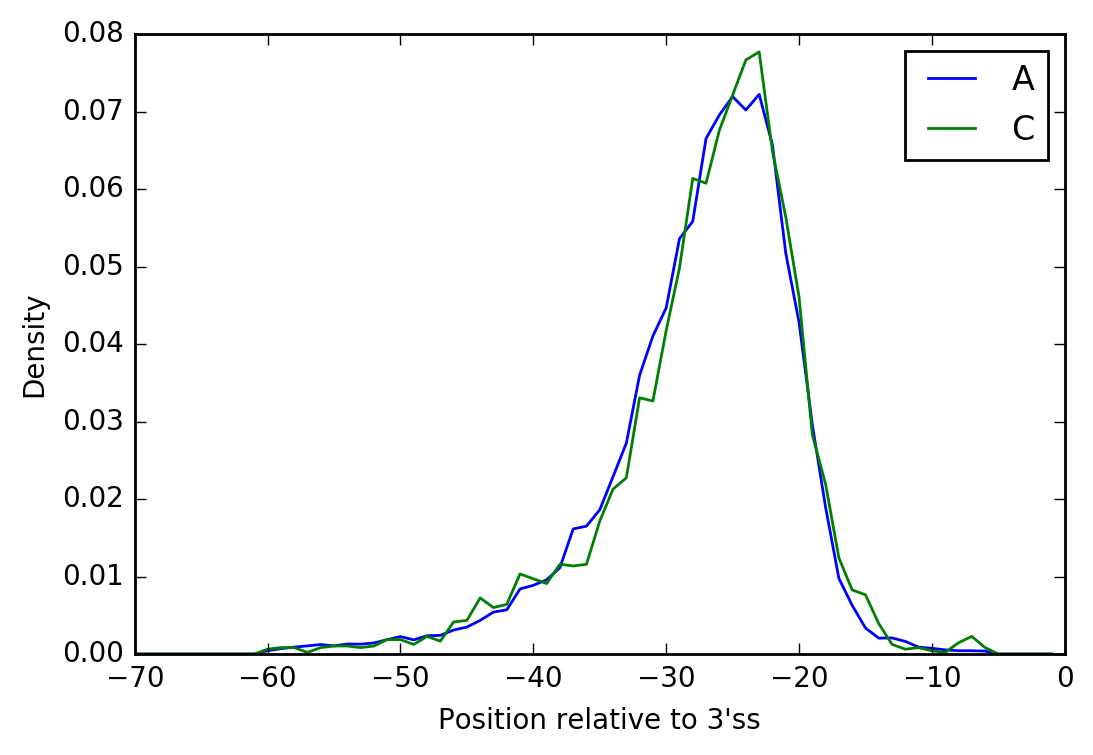

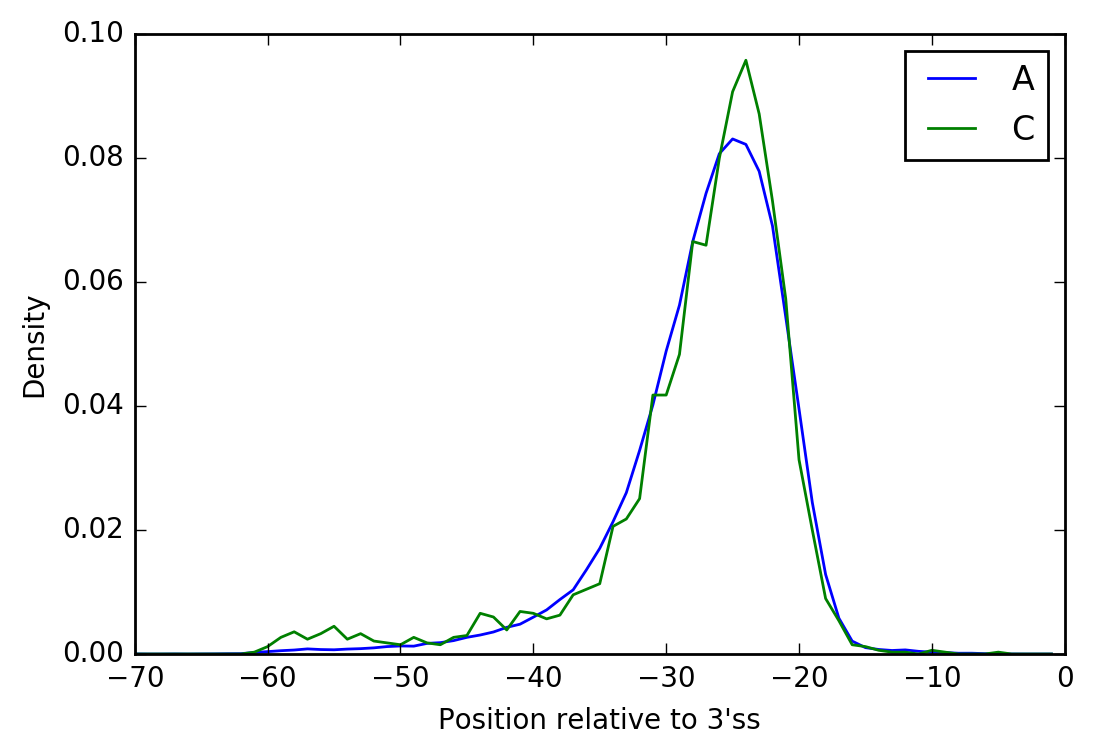

In [38]:
def dist_novel_bp(X, y, base):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if not seq[bp, base]: continue
        counts[bp] += 1
        total += 1
    return counts / total

def dist_known_bp(X, y, base):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if not seq[bp, base]: continue
            counts[bp] += 1
            total += 1
    return counts / total

for i, base in enumerate(bases[:2]):
    plt.plot(range(-L, 0), dist_known_bp(X_known, y_known, i), label = base)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

for i, base in enumerate(bases[:2]):
    plt.plot(range(-L, 0), dist_novel_bp(X_all, y_all, i), label = base)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

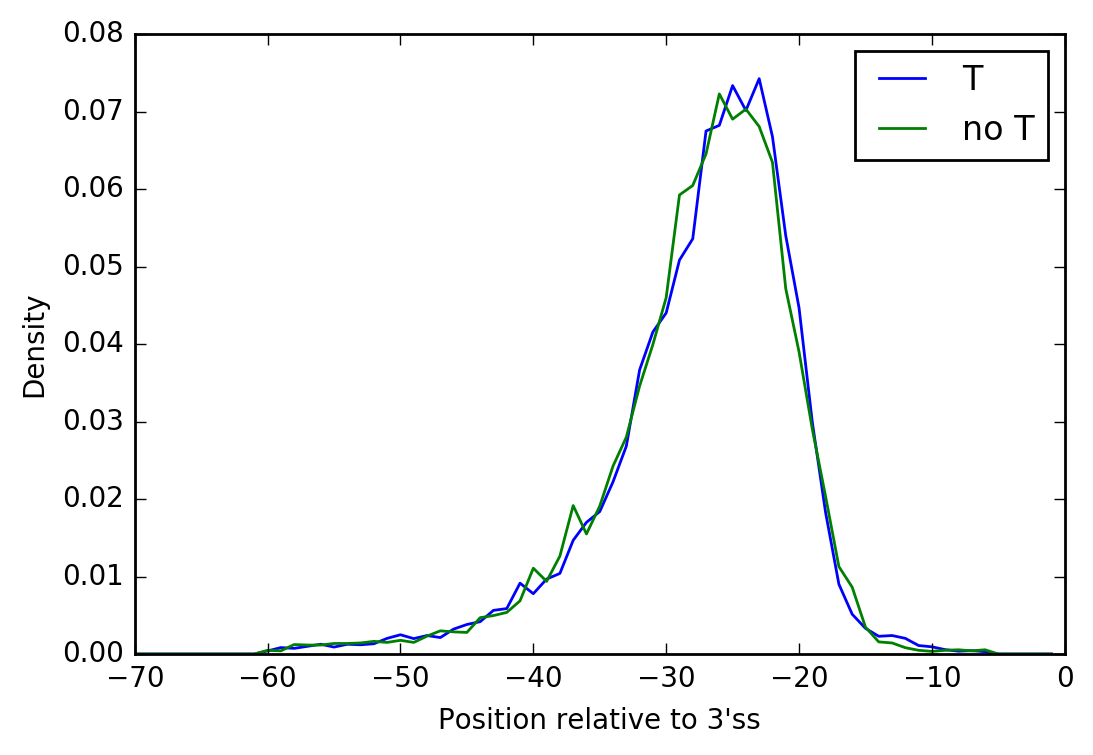

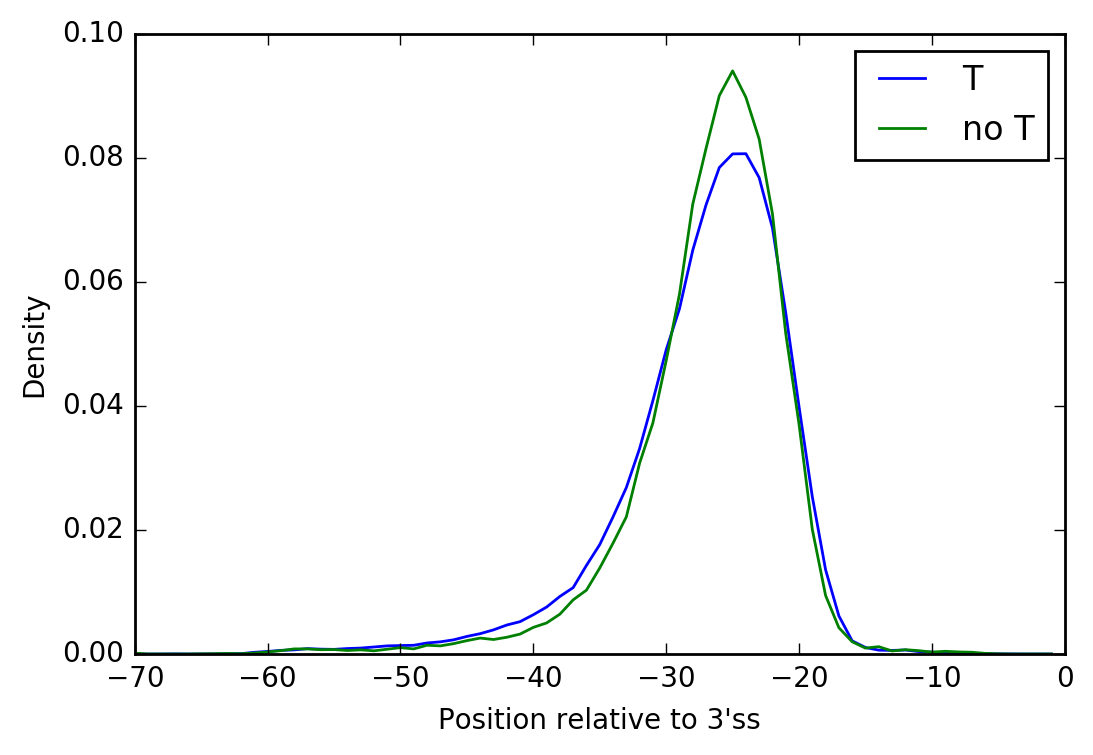

In [39]:
def dist_novel_2T(X, y, T):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if T != seq[bp-2, 3]: continue
        counts[bp] += 1
        total += 1
    return counts / total

def dist_known_2T(X, y, T):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if T != seq[bp-2, 3]: continue
            if not seq[bp, 0]: continue
            counts[bp] += 1
            total += 1
    return counts / total

for i, t in enumerate(['T', 'no T']):
    plt.plot(range(-L, 0), dist_known_2T(X_known, y_known, 1-i), label = t)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

for i, t in enumerate(['T', 'no T']):
    plt.plot(range(-L, 0), dist_novel_2T(X_all, y_all, 1-i), label = t)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

## PWM

In [23]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

def pwm_logo(pwm, title, x=None, aspect = 2.5):
    fig = plt.figure(figsize=(10,5))
    adjustFigAspect(fig,aspect=aspect)

    ax = fig.add_subplot(111)
    #f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'U'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax.bar(bar_l,
               pwm[:, i],
               width=bar_width,
               label=char,
               bottom=np.sum(pwm[:, :i], axis = 1),
               alpha=0.5,
               color = color)
    plt.xticks(tick_pos, x if x else range(-K, K+1))
    plt.legend(loc = 1, prop={'size':9})
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(.75, len(x)+1 if x else 2*K+2)
    plt.show()

44922


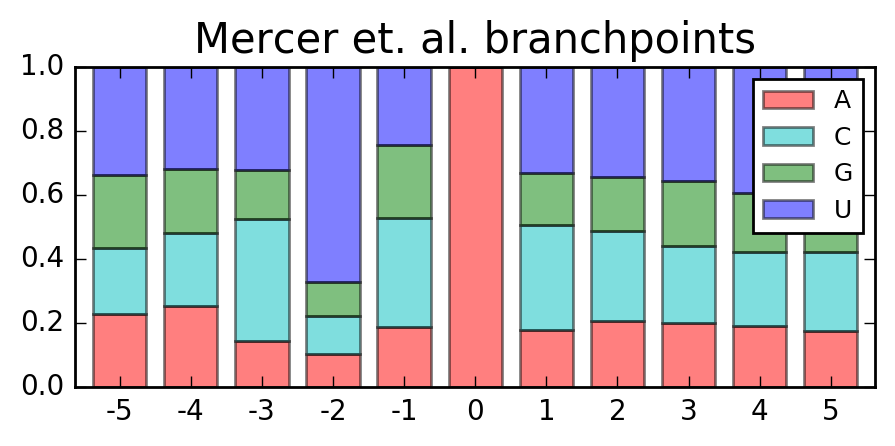

4840


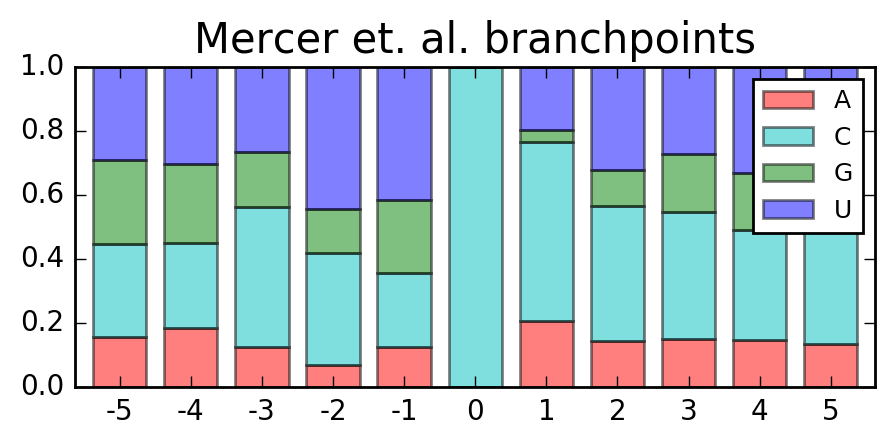

2439


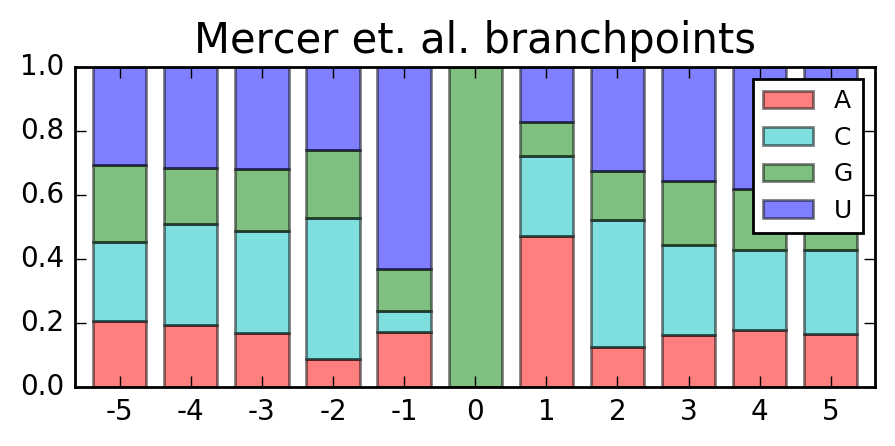

4607


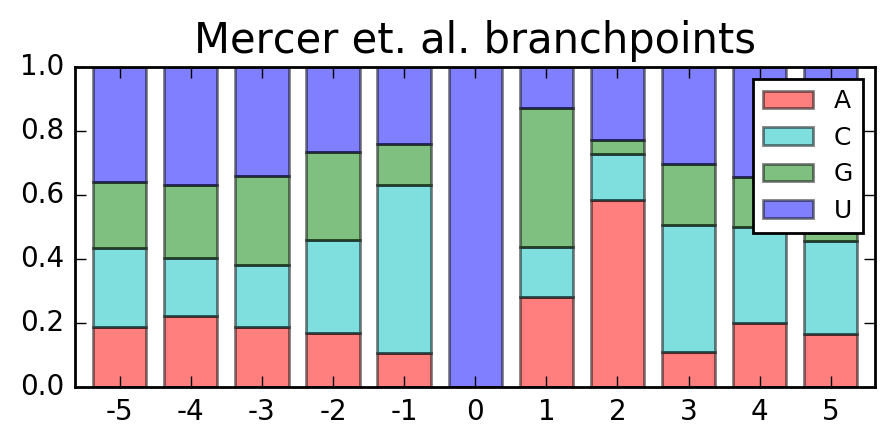

34207


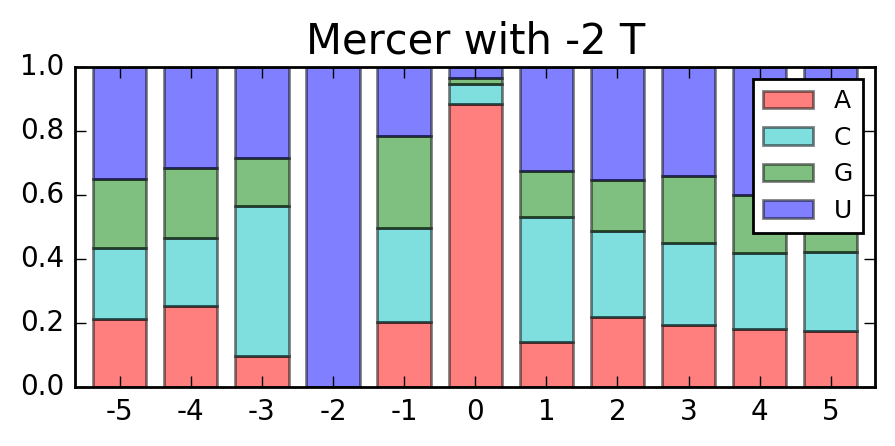

22601


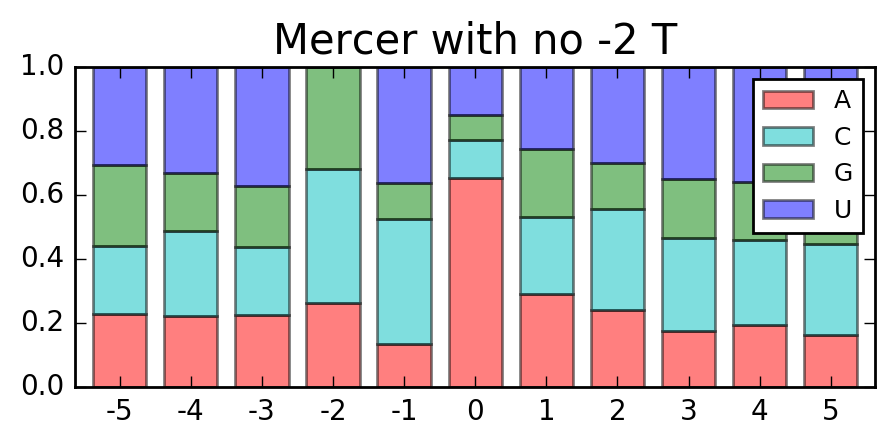

In [24]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known, X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, i]: continue
            counts += seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, 'Mercer et. al. branchpoints')
    
# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if not seq[bp-2, 3]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, 'Mercer with -2 T')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if seq[bp-2, 3]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
print total
pwm_logo(counts / total, 'Mercer with no -2 T')

202799


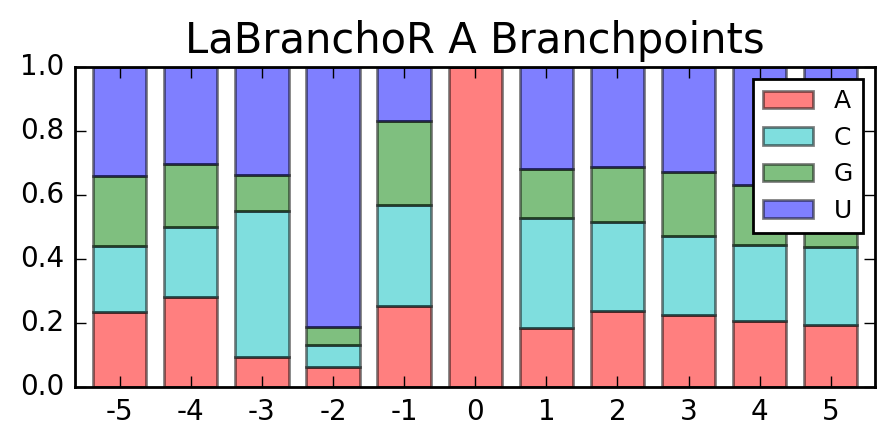

3351


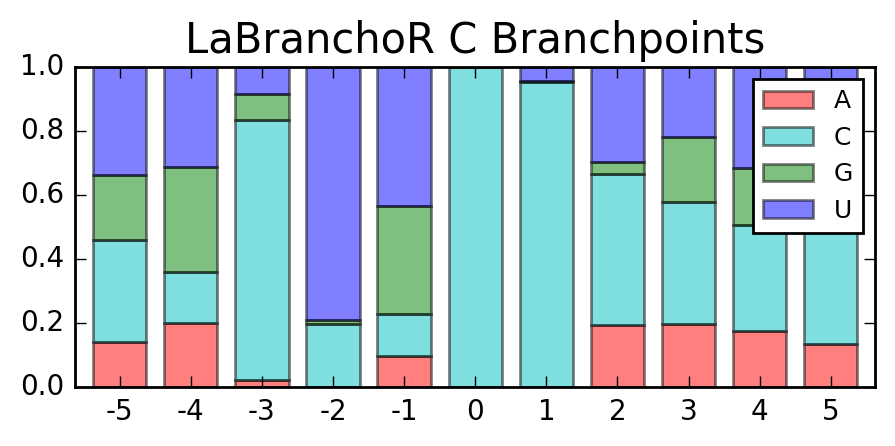

57


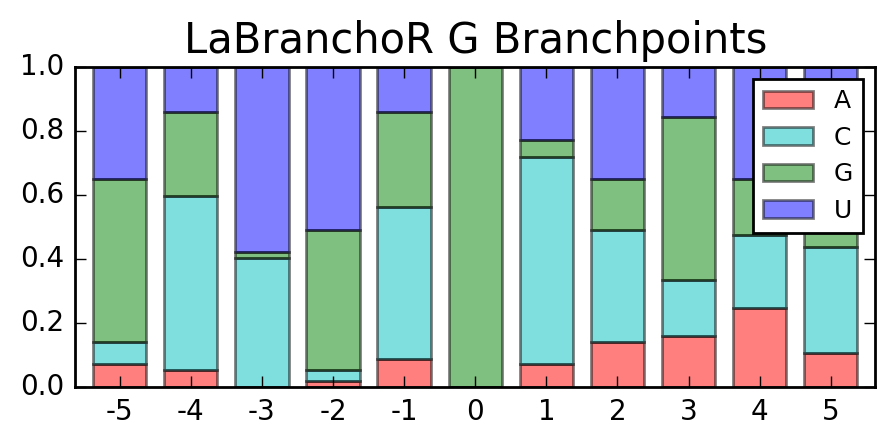

69


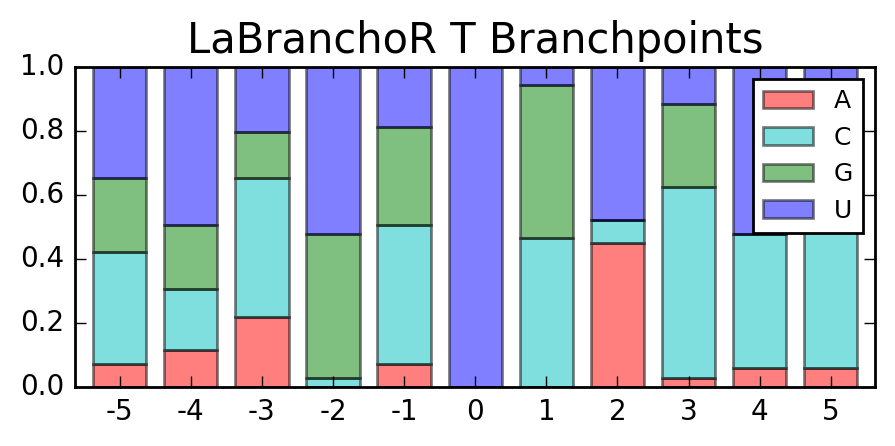

167355


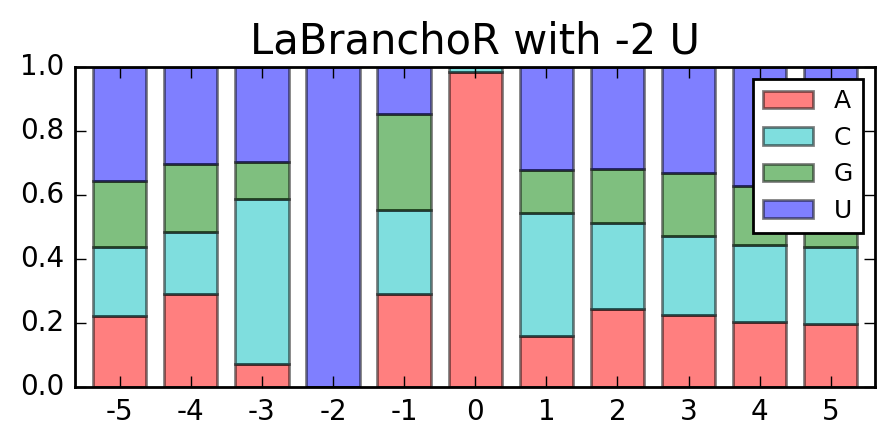

38921


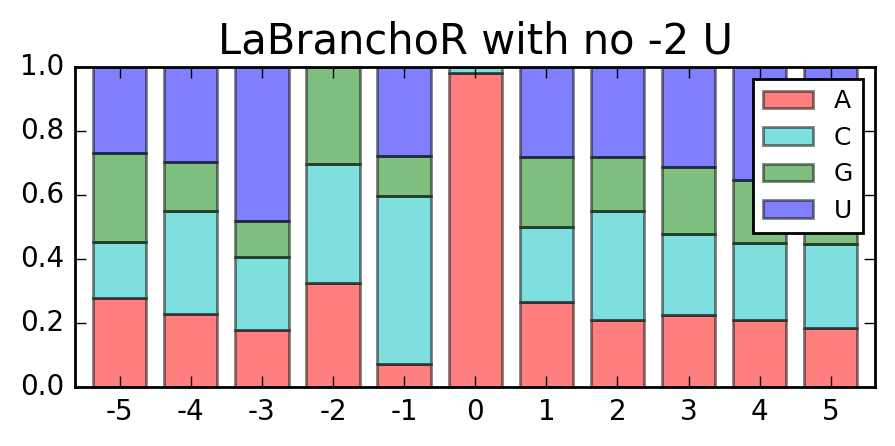

In [25]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, "LaBranchoR {} Branchpoints".format(base))

# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'LaBranchoR with -2 U')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'LaBranchoR with no -2 U')

In [26]:
def CG(bps, title): 
    C = []
    G = []
    for i in range(41):
        C += [sum(bps[:, i, 1])]
        G += [sum(bps[:, i, 2])]
    plt.plot(range(-20, 21),
             np.array(C) / float(bps.shape[0]),
             label = 'C')
    plt.plot(range(-20, 21),
             np.array(G) / float(bps.shape[0]),
             label = 'G')
    plt.legend(loc = 'best')
    plt.ylabel('Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.title(title)
    plt.ylim(0, 0.5)
    plt.show()
    return np.array(C), np.array(G)

def enrichment(c1, c2, g1, g2, n1, n2, pos = range(-20, 0)):
    for i, e, o, t in zip(range(-20, 0), (c1/n1) / (c2/n2), c1, c2):
        print i, e, o, t, 'C'
    plt.plot(range(-20, 21), (c1/n1) / (c2/n2))
    plt.show()
    
    for i, e, o, t in zip(range(-20, 0), (g1/n1) / (g2/n2), g1, g2):
        print i, e, o, t, 'G'
    plt.plot(range(-20, 21), (g1/n1) / (g2/n2))
    plt.show()
    
    for p in pos:
        print 'C', p, fisher_exact([[c1[20+p], n1-c1[20+p]],
                                    [c2[20+p], n2-c2[20+p]]])
        print 'G', p, fisher_exact([[g1[20+p], n1-g1[20+p]],
                                    [g2[20+p], n2-g2[20+p]]])

(42798, 43, 4)


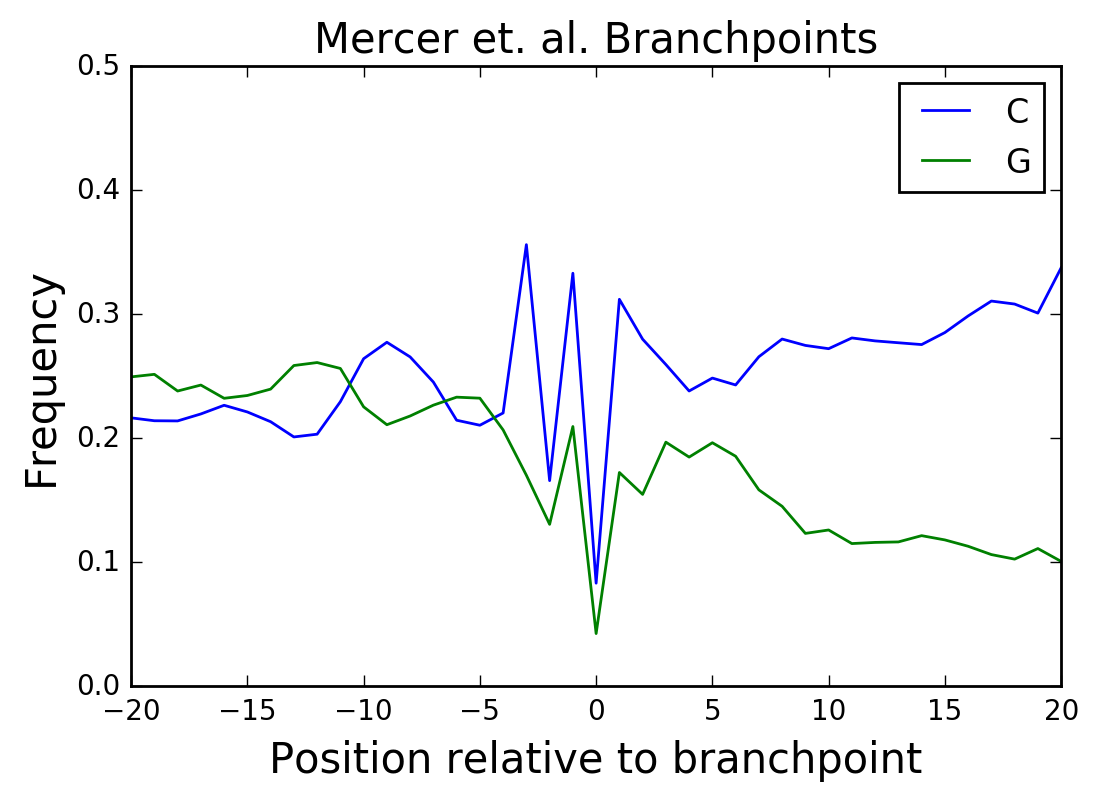

In [27]:
bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG(bps, 'Mercer et. al. Branchpoints');

(160785, 43, 4)


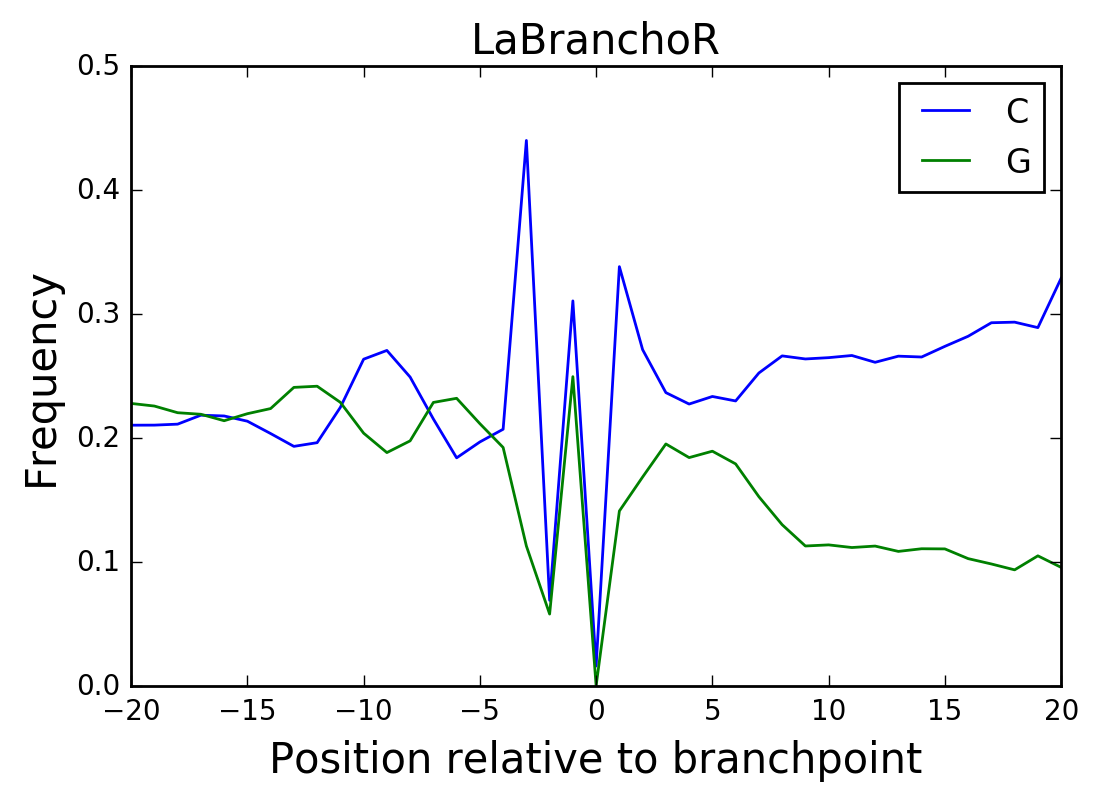

In [28]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG(bps, 'LaBranchoR');

(17292, 43, 4)


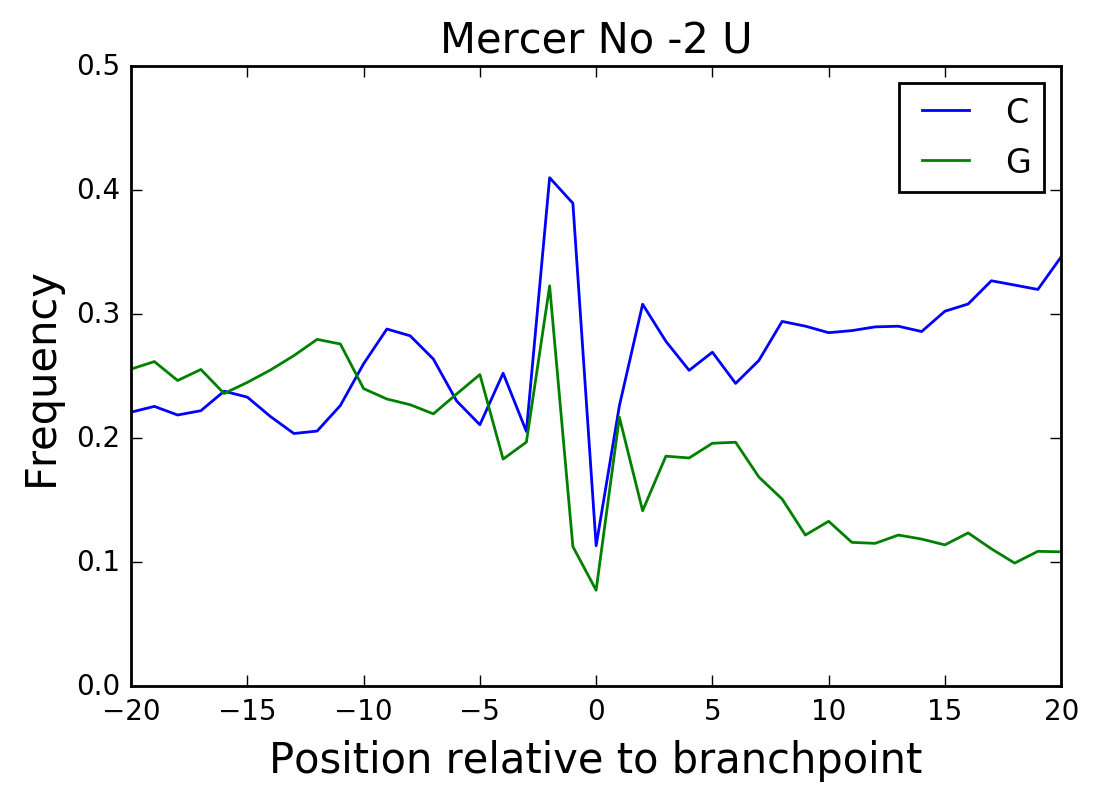

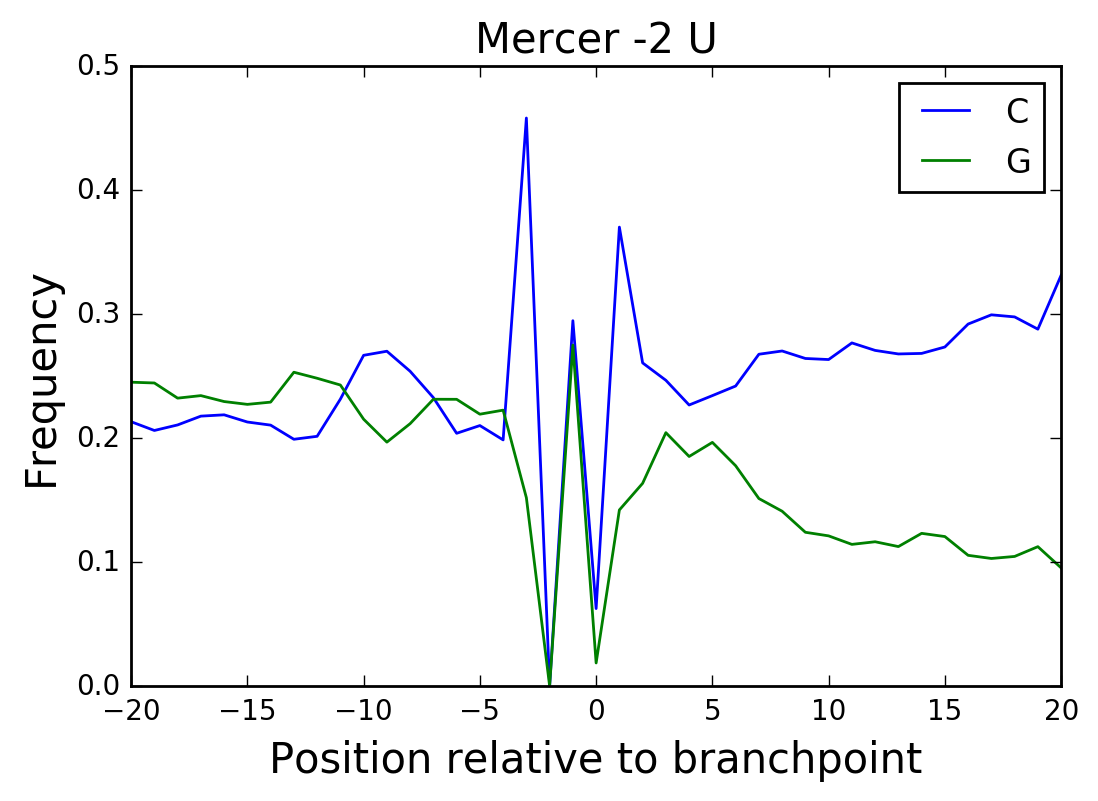

-20 1.03625666962 3819.0 5436.0 C
-19 1.09419570852 3899.0 5256.0 C
-18 1.03800569127 3779.0 5370.0 C
-17 1.02010297299 3839.0 5551.0 C
-16 1.08709148835 4111.0 5578.0 C
-15 1.09417493223 4028.0 5430.0 C
-14 1.03245716792 3756.0 5366.0 C
-13 1.02335686425 3521.0 5075.0 C
-12 1.02096703192 3555.0 5136.0 C
-11 0.97784576674 3912.0 5901.0 C
-10 0.974526310892 4494.0 6802.0 C
-9 1.06631373274 4978.0 6886.0 C
-8 1.11275636899 4884.0 6474.0 C
-7 1.13380611944 4559.0 5931.0 C
-6 1.12797113554 3975.0 5198.0 C
-5 1.0030778799 3643.0 5357.0 C
-4 1.2710441874 4362.0 5062.0 C
-3 0.448199228723 3550.0 11683.0 C
-2 inf 7088.0 0.0 C
-1 1.32150875617 6732.0 7514.0 C


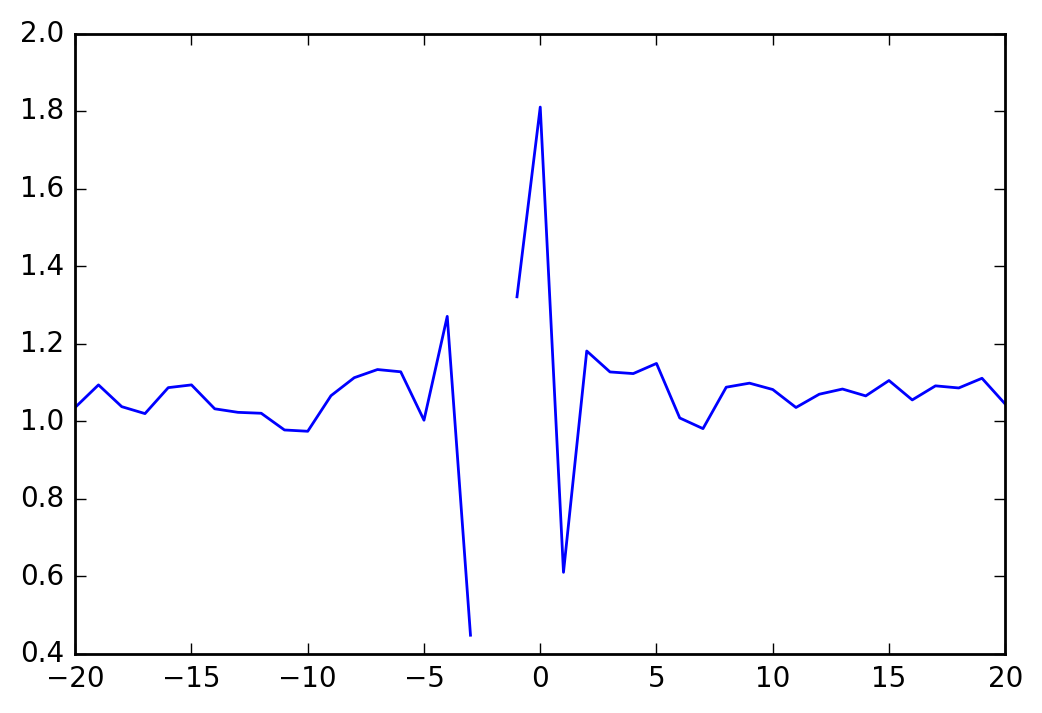

-20 1.04329919713 4420.0 6249.0 G
-19 1.07058855883 4524.0 6233.0 G
-18 1.06123524861 4260.0 5921.0 G
-17 1.09002621443 4414.0 5973.0 G
-16 1.02830213072 4079.0 5851.0 G
-15 1.07806377627 4234.0 5793.0 G
-14 1.11352568499 4408.0 5839.0 G
-13 1.05289819137 4607.0 6454.0 G
-12 1.12641925203 4834.0 6330.0 G
-11 1.13622318489 4769.0 6191.0 G
-10 1.11459492467 4147.0 5488.0 G
-9 1.17683800458 4002.0 5016.0 G
-8 1.07236713498 3923.0 5396.0 G
-7 0.949082882281 3795.0 5898.0 G
-6 1.01852987034 4072.0 5897.0 G
-5 1.14577004954 4343.0 5591.0 G
-4 0.822515842868 3164.0 5674.0 G
-3 1.29525794066 3401.0 3873.0 G
-2 inf 5580.0 0.0 G
-1 0.408932362604 1944.0 7012.0 G


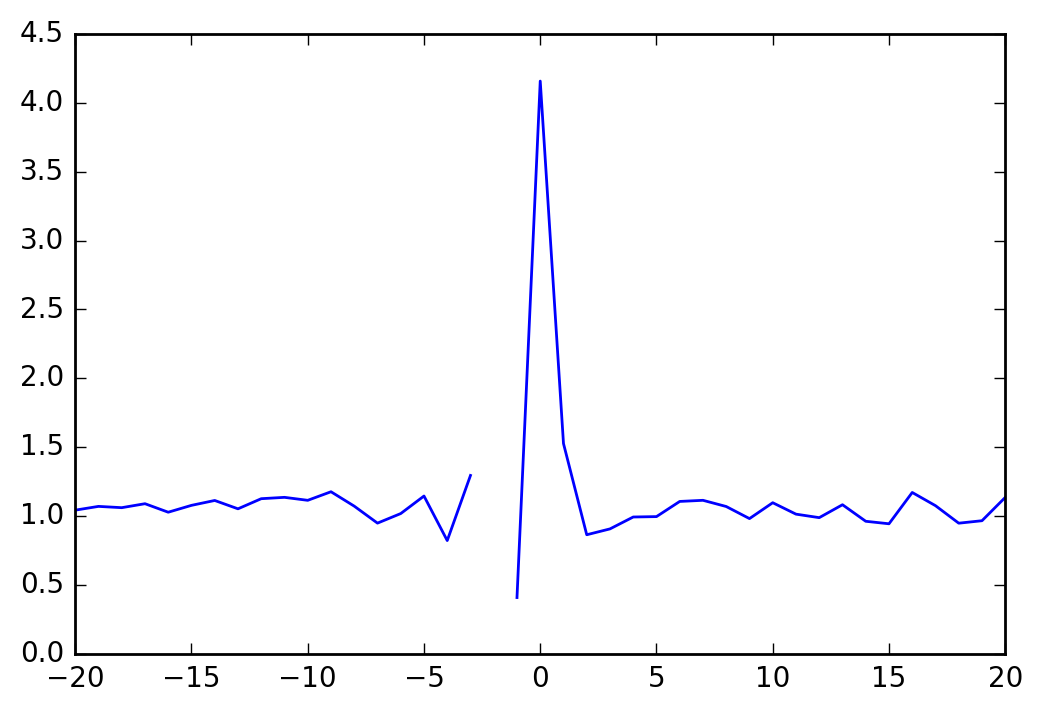

C -20 (1.0465338329344487, 0.057143576163146297)
G -20 (1.0581673179579461, 0.013062402543292811)
C -19 (1.1216181730591221, 1.6434565179321265e-06)
G -19 (1.0955997305151215, 5.5564522449898873e-05)
C -18 (1.048634234693097, 0.04880004571421688)
G -18 (1.0812522958051423, 0.00073037922422330569)
C -17 (1.0258396349438266, 0.28412578387733051)
G -17 (1.1208831573108653, 6.5182223439031683e-07)
C -16 (1.1142543066909465, 4.1784125231304671e-06)
G -16 (1.0370393131286222, 0.12069398568954209)
C -15 (1.1227738938613385, 1.0015980872467032e-06)
G -15 (1.1033756179556311, 2.3035609853356778e-05)
C -14 (1.0414634565414496, 0.092222702840491708)
G -14 (1.1523662018695919, 7.070077104279526e-10)
C -13 (1.0293287994010403, 0.24284052932926498)
G -13 (1.072110013815976, 0.0019743756508505241)
C -12 (1.026393092806861, 0.28682246215428897)
G -12 (1.175472925522647, 4.6106568209815306e-13)
C -11 (0.97136838553623583, 0.21860914094131423)
G -11 (1.1880996017884353, 1.7985834252890606e-14)
C -10 (0.

In [29]:
noT_bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        if seq[bp-2, 3]: continue
        noT_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
noT_bps = np.vstack(noT_bps)
print noT_bps.shape

noT_C, noT_G = CG(noT_bps, 'Mercer No -2 U')

T_bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        if not seq[bp-2, 3]: continue
        T_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
T_bps = np.vstack(T_bps)

T_C, T_G = CG(T_bps, 'Mercer -2 U')
enrichment(noT_C, T_C, noT_G, T_G, noT_bps.shape[0], T_bps.shape[0])

(30840, 43, 4)


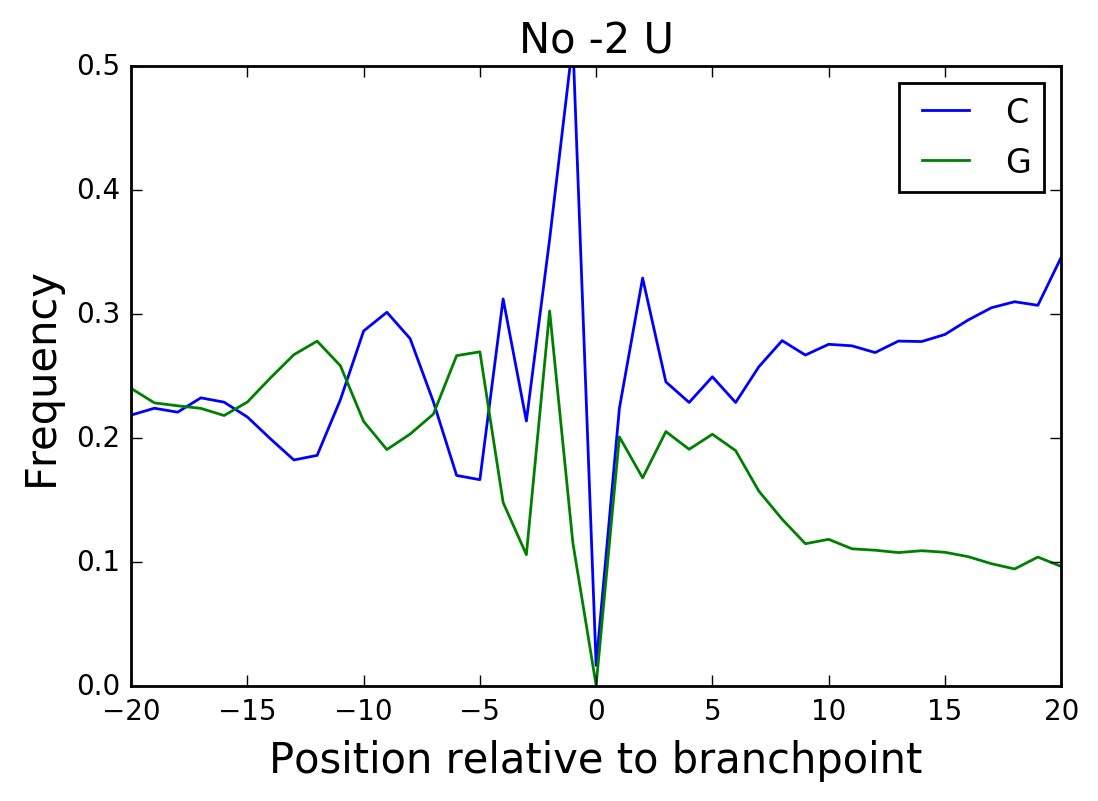

(160785, 43, 4)


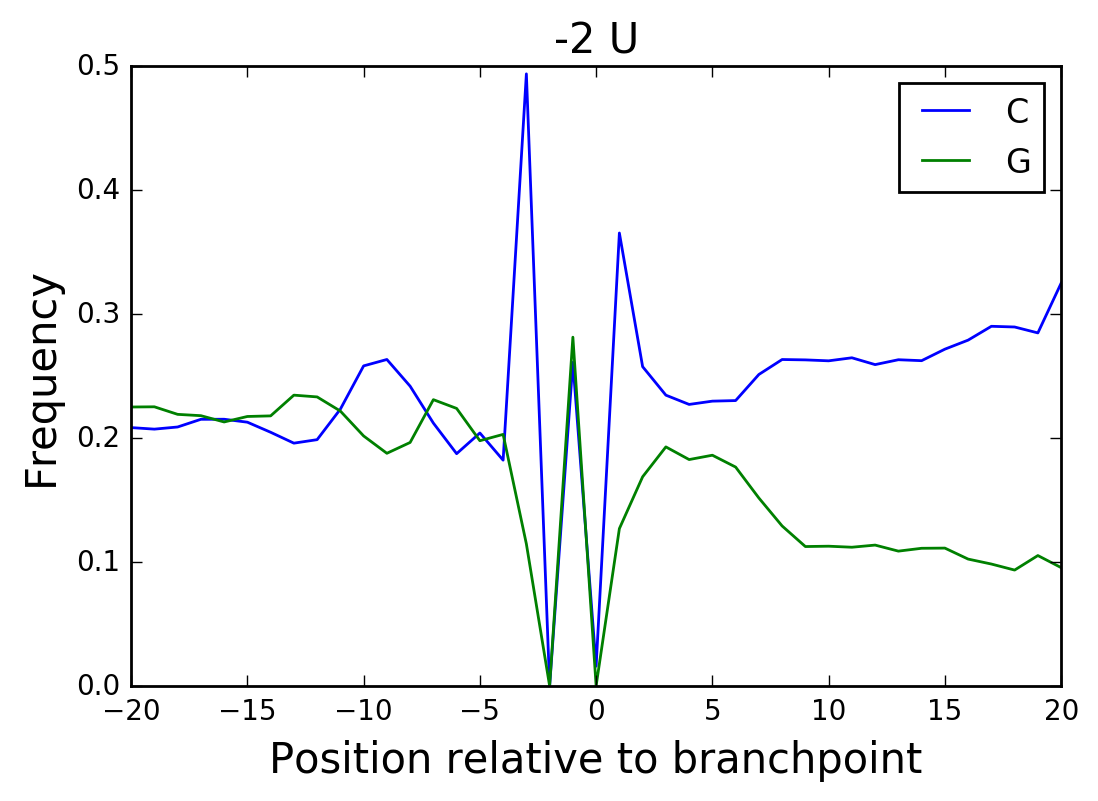

-20 1.04844001619 6738.0 27079.0 C
-19 1.08132126594 6908.0 26918.0 C
-18 1.05714477911 6810.0 27143.0 C
-17 1.08051767137 7167.0 27948.0 C
-16 1.06396879156 7059.0 27955.0 C
-15 1.01962157893 6690.0 27646.0 C
-14 0.973594414682 6144.0 26590.0 C
-13 0.930819180132 5622.0 25449.0 C
-12 0.936229275803 5736.0 25815.0 C
-11 1.03384775805 7119.0 29014.0 C
-10 1.10908585133 8830.0 33546.0 C
-9 1.14459717159 9295.0 34217.0 C
-8 1.1587250908 8640.0 31418.0 C
-7 1.08125281491 7070.0 27551.0 C
-6 0.906358809491 5237.0 24346.0 C
-5 0.815402365067 5131.0 26514.0 C
-4 1.71400196591 9627.0 23666.0 C
-3 0.432860042887 6590.0 64148.0 C
-2 inf 11111.0 0.0 C
-1 1.98979780866 16017.0 33917.0 C


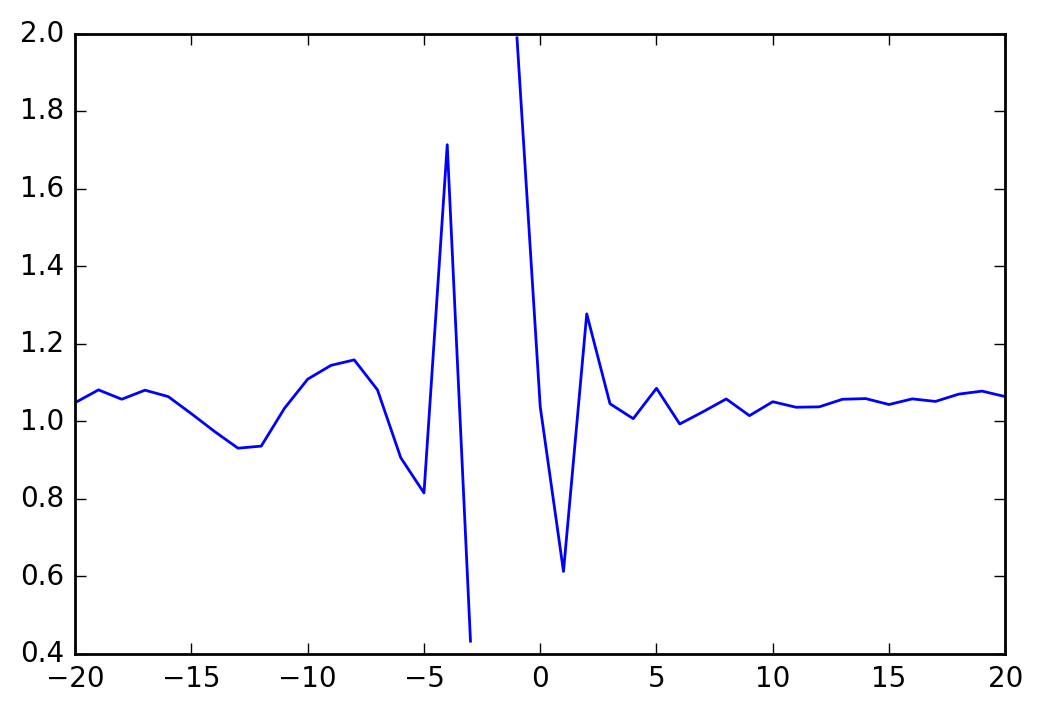

-20 1.06674711525 7402.0 29237.0 G
-19 1.01413690971 7042.0 29258.0 G
-18 1.03151124608 6969.0 28467.0 G
-17 1.02705327847 6905.0 28328.0 G
-16 1.02440848831 6727.0 27669.0 G
-15 1.05367871596 7063.0 28244.0 G
-14 1.14123957254 7667.0 28307.0 G
-13 1.13908846268 8240.0 30480.0 G
-12 1.19295481133 8577.0 30294.0 G
-11 1.16500334867 7966.0 28811.0 G
-10 1.0582446414 6581.0 26203.0 G
-9 1.01597251852 5880.0 24386.0 G
-8 1.03451765594 6266.0 25521.0 G
-7 0.949537816172 6762.0 30006.0 G
-6 1.19012279389 8216.0 29088.0 G
-5 1.36254240131 8312.0 25704.0 G
-4 0.729340147652 4564.0 26367.0 G
-3 0.924608706095 3267.0 14888.0 G
-2 inf 9328.0 0.0 G
-1 0.410124997099 3558.0 36554.0 G


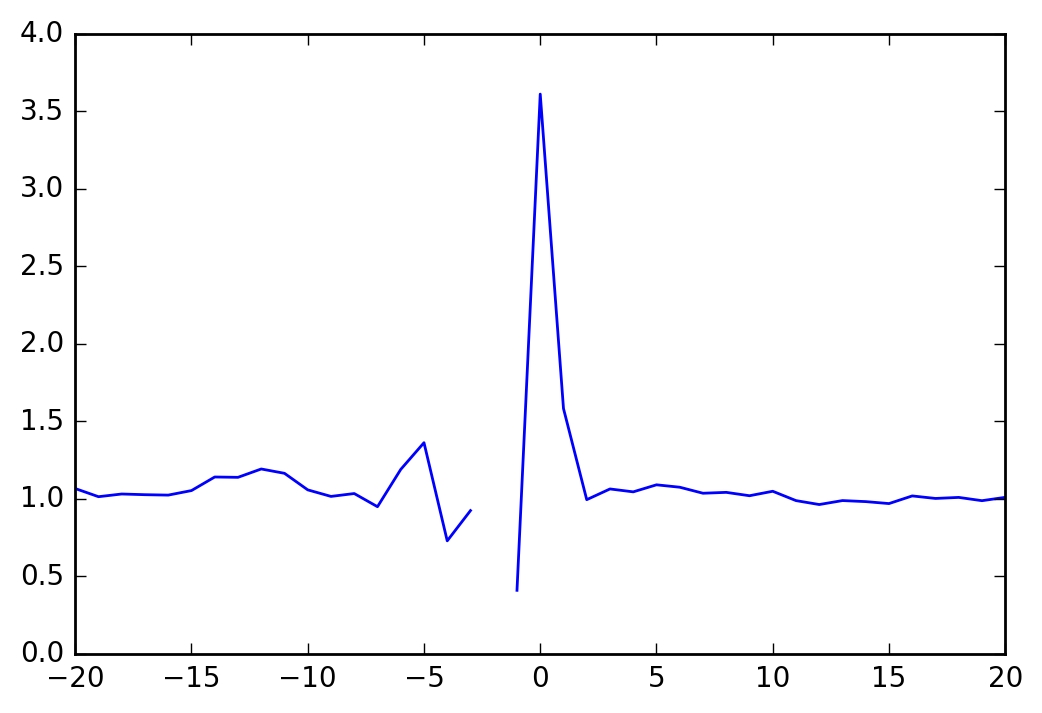

C -20 (1.0619819973171924, 9.8790921098176093e-05)
G -20 (1.0878266504951721, 1.8503523870249311e-08)
C -19 (1.1047947451777114, 8.6394404164360511e-11)
G -19 (1.0183201233482042, 0.23135615457367881)
C -18 (1.0733393669437352, 4.3465256852430592e-06)
G -18 (1.040710771604032, 0.0087744608336613478)
C -17 (1.1048943938230089, 4.7732901491636413e-11)
G -17 (1.034857869558351, 0.024877180208636485)
C -16 (1.0829568786740444, 1.5944453532725519e-07)
G -16 (1.0312179230898015, 0.046306433161870969)
C -15 (1.0250571219180562, 0.10796490370422956)
G -15 (1.0696240736989484, 9.4290094114025865e-06)
C -14 (0.96702509510761803, 0.034365364392708569)
G -14 (1.1879699830405785, 8.2308867744190328e-31)
C -13 (0.91539628500538606, 5.3634555657488061e-08)
G -13 (1.1898003623440876, 7.5618092081191034e-33)
C -12 (0.92165833595346203, 4.2758107539537476e-07)
G -12 (1.2672922059678244, 2.2758433947547952e-60)
C -11 (1.0440059381284199, 0.0043319885144015805)
G -11 (1.2224666990056583, 3.866195093100839

In [30]:
noT_bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if seq[bp-2, 3]: continue
    noT_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
noT_bps = np.vstack(noT_bps)
print noT_bps.shape

noT_C, noT_G = CG(noT_bps, 'No -2 U')

T_bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if not seq[bp-2, 3]: continue
    T_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
T_bps = np.vstack(T_bps)
print bps.shape

T_C, T_G = CG(T_bps, '-2 U')

enrichment(noT_C, T_C, noT_G, T_G, noT_bps.shape[0], T_bps.shape[0])

(3549, 43, 4)


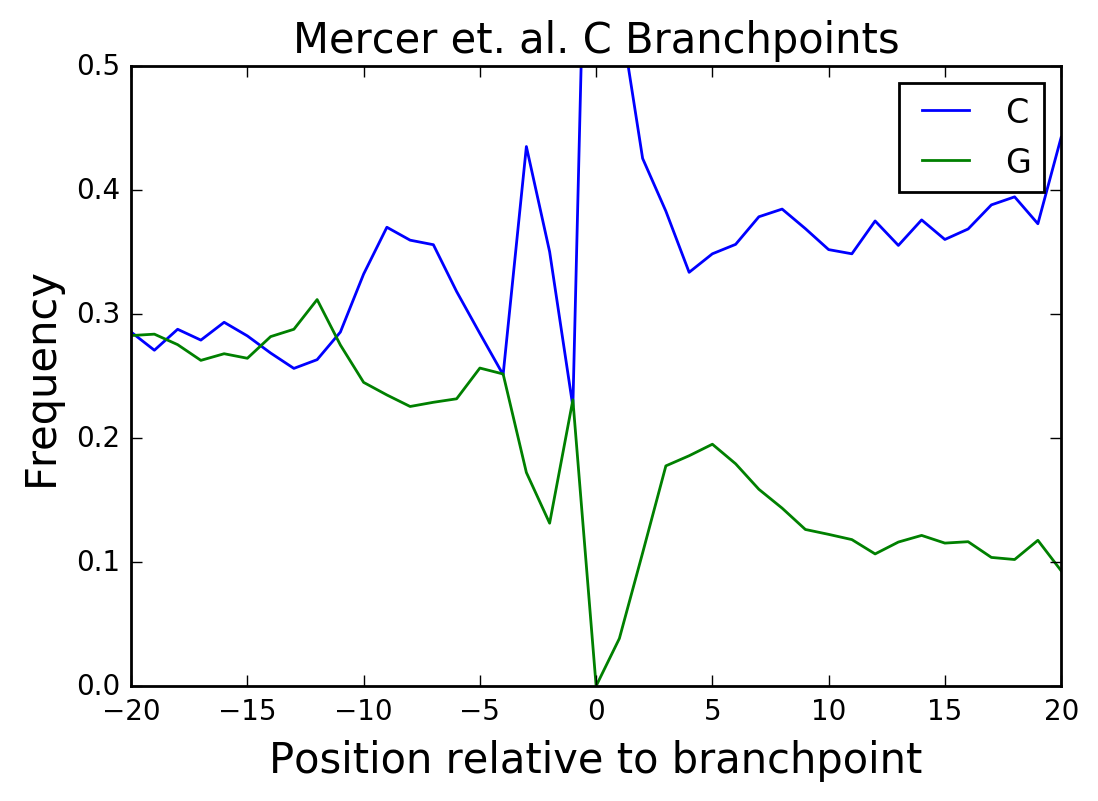

In [31]:
bps = []
for seq, target in zip(X_known, y_known):
    for bp in np.nonzero(target)[0]:
        if bp-20 < 0 or bp+23 > L: continue
        if not seq[bp, 1]: continue
        bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG(bps, 'Mercer et. al. C Branchpoints');

(3549, 43, 4)


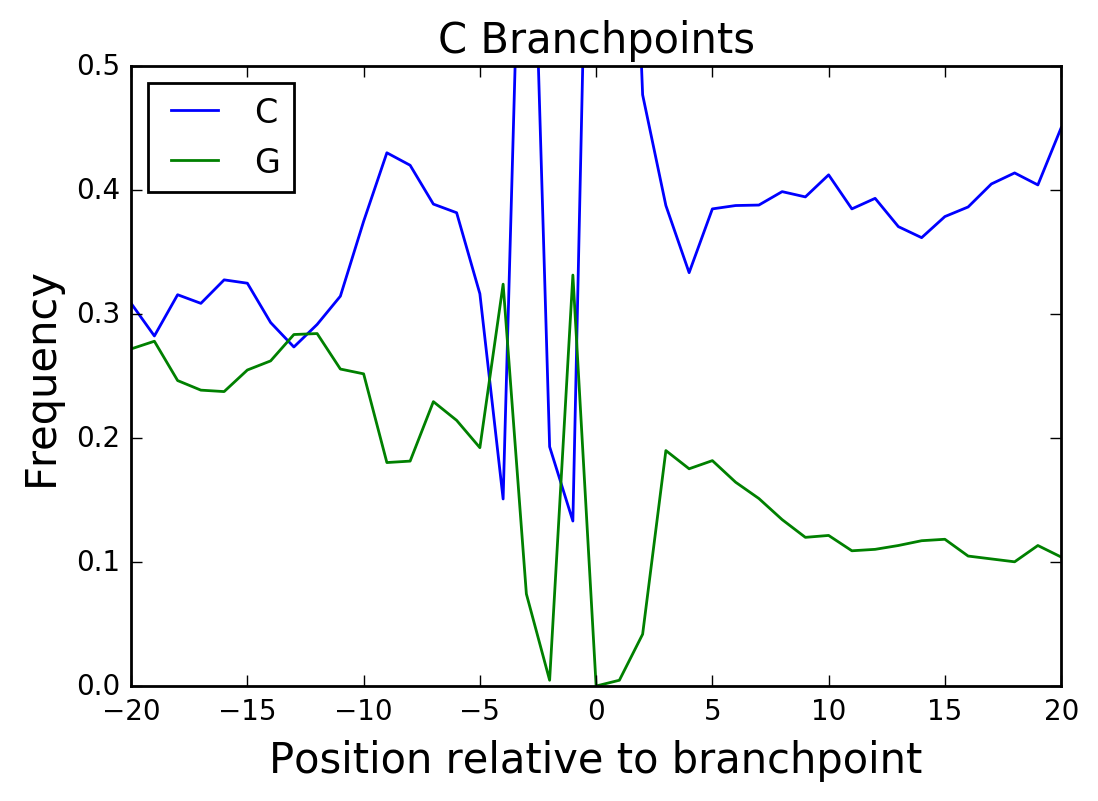

(158116, 43, 4)


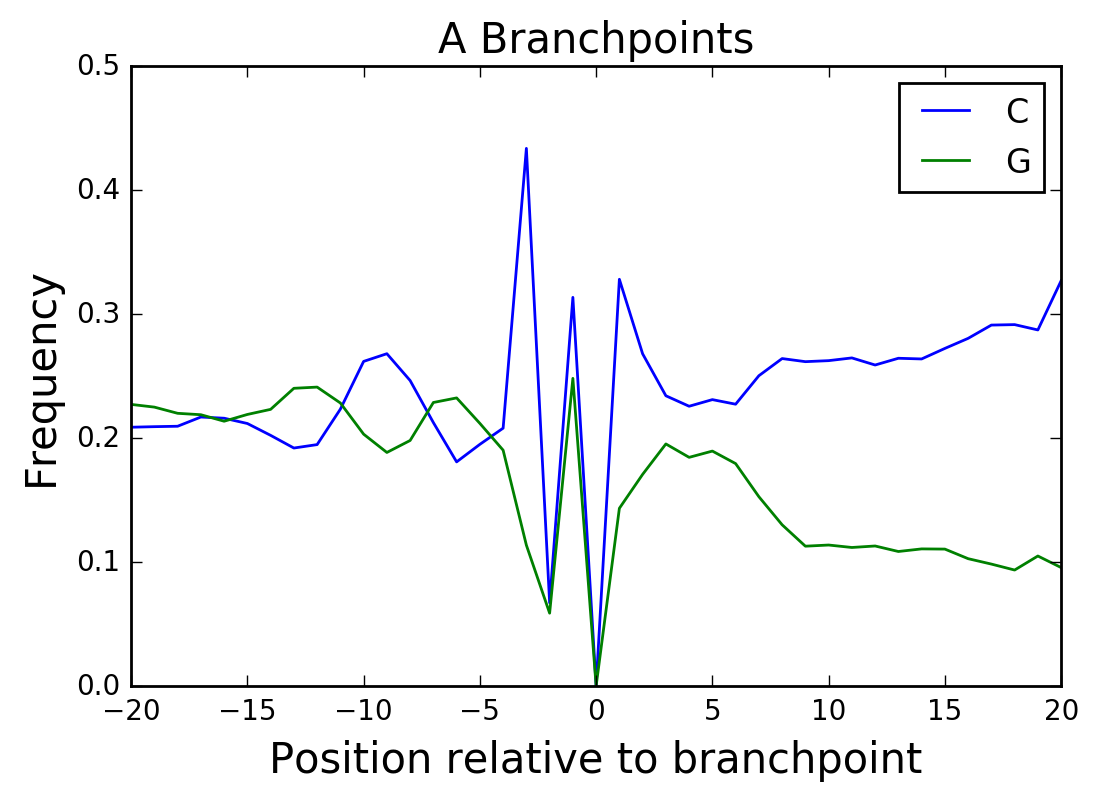

-20 1.47868522393 798.0 32997.0 C
-19 1.34977764069 730.0 33068.0 C
-18 1.50633270153 816.0 33122.0 C
-17 1.42263685845 798.0 34297.0 C
-16 1.51671363777 847.0 34145.0 C
-15 1.53446821472 840.0 33471.0 C
-14 1.45013933697 758.0 31960.0 C
-13 1.42460309207 707.0 30344.0 C
-12 1.49768958798 754.0 30782.0 C
-11 1.40807643843 813.0 35303.0 C
-10 1.43144824091 969.0 41390.0 C
-9 1.60466127449 1112.0 42371.0 C
-8 1.70474141436 1086.0 38951.0 C
-7 1.82948652803 1005.0 33588.0 C
-6 2.11162805198 987.0 28579.0 C
-5 1.62307440845 818.0 30815.0 C
-4 0.725281357261 390.0 32878.0 C
-3 1.91133436993 2143.0 68554.0 C
-2 2.87562638816 499.0 10610.0 C
-1 0.424433345525 344.0 49556.0 C


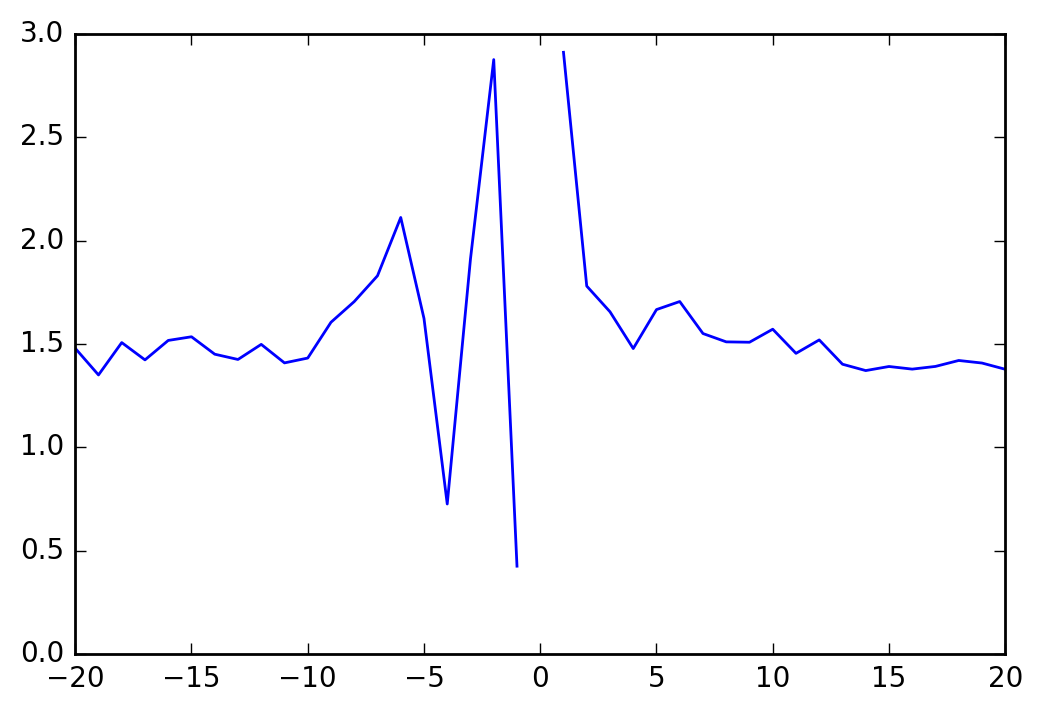

-20 1.19708090103 703.0 35907.0 G
-19 1.23623838371 719.0 35561.0 G
-18 1.1201006775 637.0 34772.0 G
-17 1.09060967291 617.0 34591.0 G
-16 1.11195574792 614.0 33762.0 G
-15 1.16367147451 659.0 34626.0 G
-14 1.17519509456 678.0 35275.0 G
-13 1.18062949492 733.0 37961.0 G
-12 1.1790985573 735.0 38114.0 G
-11 1.11994830916 661.0 36087.0 G
-10 1.2395411015 651.0 32112.0 G
-9 0.956804271487 466.0 29779.0 G
-8 0.915964596894 469.0 31307.0 G
-7 1.00295552878 593.0 36151.0 G
-6 0.922122972575 554.0 36734.0 G
-5 0.907514105484 497.0 33485.0 G
-4 1.70395408908 838.0 30070.0 G
-3 0.653718175614 192.0 17958.0 G
-2 0.0790047310601 12.0 9287.0 G
-1 1.3357708255 857.0 39228.0 G


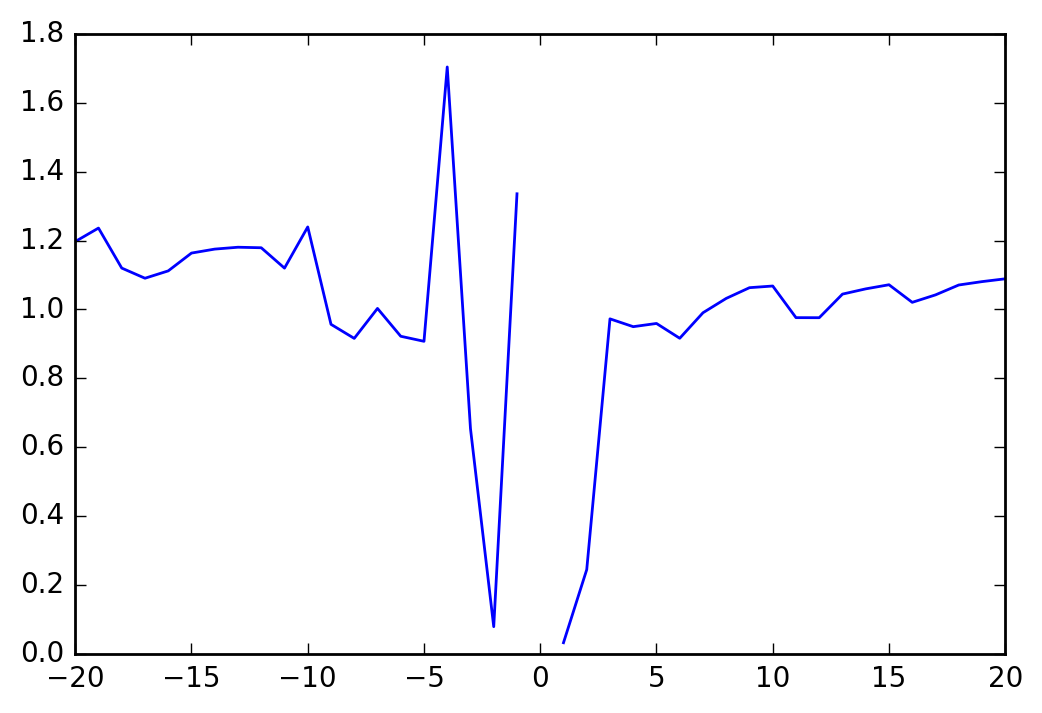

C -20 (1.6923266158221013, 4.1409552777836957e-32)
G -20 (1.2706591662615294, 1.3217679453001956e-07)
C -19 (1.4873518204911091, 2.4189691157392481e-18)
G -19 (1.3272161008460202, 4.220106273224668e-10)
C -18 (1.7397606588482846, 1.0869124065565049e-35)
G -18 (1.1593536952320997, 0.0014653200039323338)
C -17 (1.611263375805464, 7.4487934380199806e-27)
G -17 (1.1190028512687602, 0.016538555570593735)
C -16 (1.7683849725543004, 1.4086837140425122e-38)
G -16 (1.1468141805909473, 0.0037110306342799993)
C -15 (1.7916006891537948, 5.5667447817961751e-40)
G -15 (1.2196442309729969, 1.791023836806944e-05)
C -14 (1.6367944887345505, 1.3108917520269955e-27)
G -14 (1.2374499552037228, 3.4474698178968729e-06)
C -13 (1.5843659372528343, 2.2530436558496682e-23)
G -13 (1.2520819610742318, 5.3659985612509976e-07)
C -12 (1.7025247131610688, 1.2324788568177531e-31)
G -12 (1.2502154884829433, 5.5986408883498051e-07)
C -11 (1.5951977832899644, 3.2798412672678049e-26)
G -11 (1.1611357545383649, 0.001216679

In [32]:
C_bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if not seq[bp, 1]: continue
    C_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
C_bps = np.vstack(C_bps)
print bps.shape

C_C, C_G = CG(C_bps, 'C Branchpoints')

A_bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    if not seq[bp, 0]: continue
    A_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
A_bps = np.vstack(A_bps)
print A_bps.shape

A_C, A_G = CG(A_bps, 'A Branchpoints')

enrichment(C_C, A_C, C_G, A_G, C_bps.shape[0], A_bps.shape[0])

24837
(19309, 43, 4)


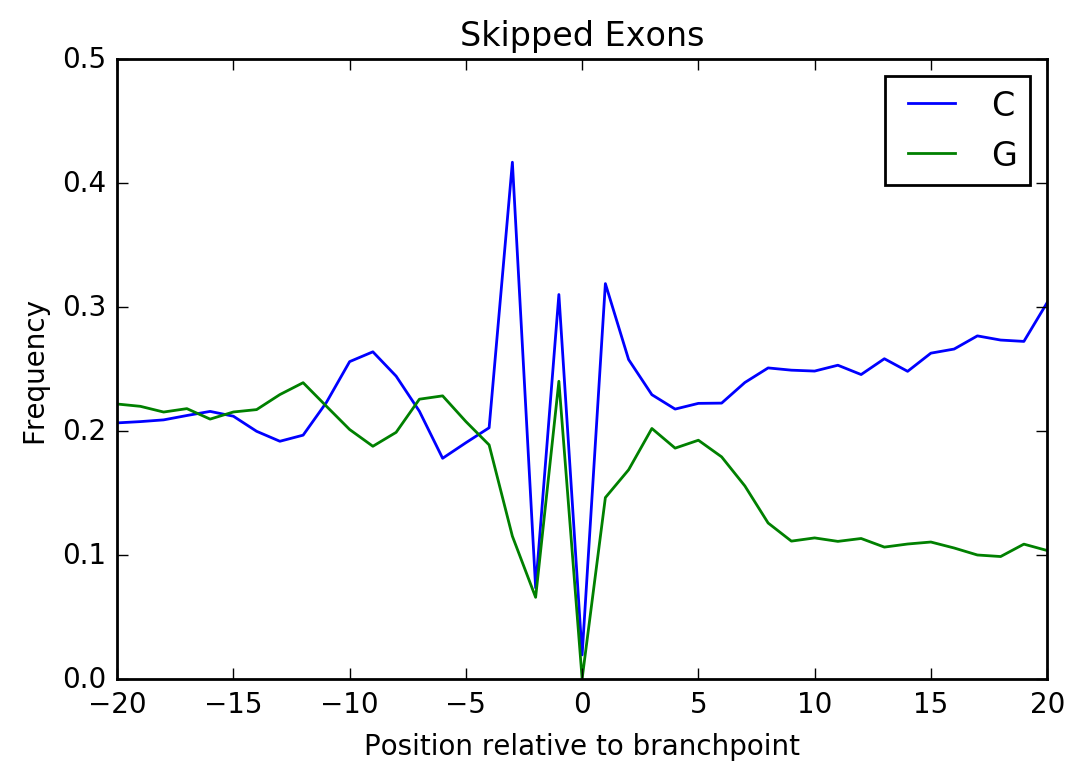

22512
(17953, 43, 4)


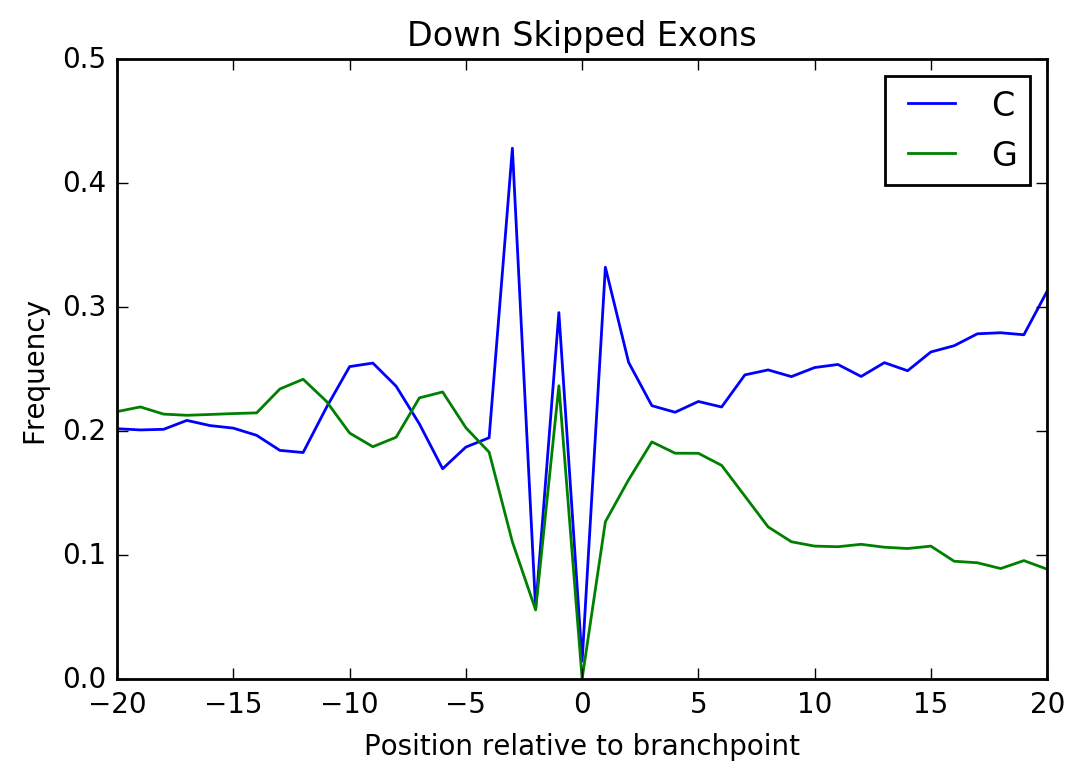

-20 1.02316154484 3988.0 3624.0 C
-19 1.03342565505 4008.0 3606.0 C
-18 1.03779717884 4035.0 3615.0 C
-17 1.01892665913 4103.0 3744.0 C
-16 1.05597354247 4167.0 3669.0 C
-15 1.04753136049 4092.0 3632.0 C
-14 1.01647876597 3857.0 3528.0 C
-13 1.0398858507 3702.0 3310.0 C
-12 1.07665467078 3797.0 3279.0 C
-11 1.01872912696 4306.0 3930.0 C
-10 1.01590571078 4942.0 4523.0 C
-9 1.03567925295 5095.0 4574.0 C
-8 1.03439789526 4716.0 4239.0 C
-7 1.04958209214 4170.0 3694.0 C
-6 1.04981344956 3437.0 3044.0 C
-5 1.01865317784 3679.0 3358.0 C
-4 1.04130393323 3912.0 3493.0 C
-3 0.973570436998 8047.0 7685.0 C
-2 1.29729484058 1419.0 1017.0 C
-1 1.04930349221 5987.0 5305.0 C


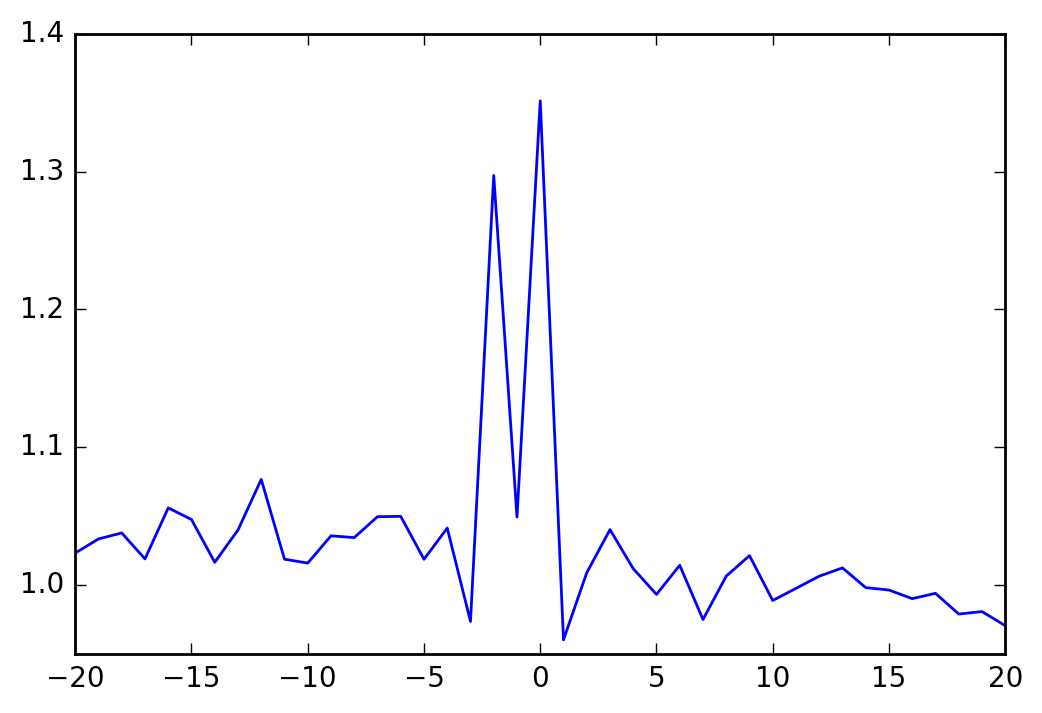

-20 1.02822595574 4282.0 3872.0 G
-19 1.00223890533 4246.0 3939.0 G
-18 1.00784072765 4157.0 3835.0 G
-17 1.02523499099 4210.0 3818.0 G
-16 0.98245276388 4047.0 3830.0 G
-15 1.0059846381 4158.0 3843.0 G
-14 1.01230225549 4195.0 3853.0 G
-13 0.980701984204 4429.0 4199.0 G
-12 0.988473678018 4614.0 4340.0 G
-11 0.982262769329 4248.0 4021.0 G
-10 1.01436976956 3885.0 3561.0 G
-9 1.0019327442 3624.0 3363.0 G
-8 1.02036020213 3841.0 3500.0 G
-7 0.995337574119 4357.0 4070.0 G
-6 0.986374436492 4409.0 4156.0 G
-5 1.02459117257 4009.0 3638.0 G
-4 1.03198083618 3645.0 3284.0 G
-3 1.04172124222 2224.0 1985.0 G
-2 1.18267212181 1272.0 1000.0 G
-1 1.01517446622 4636.0 4246.0 G


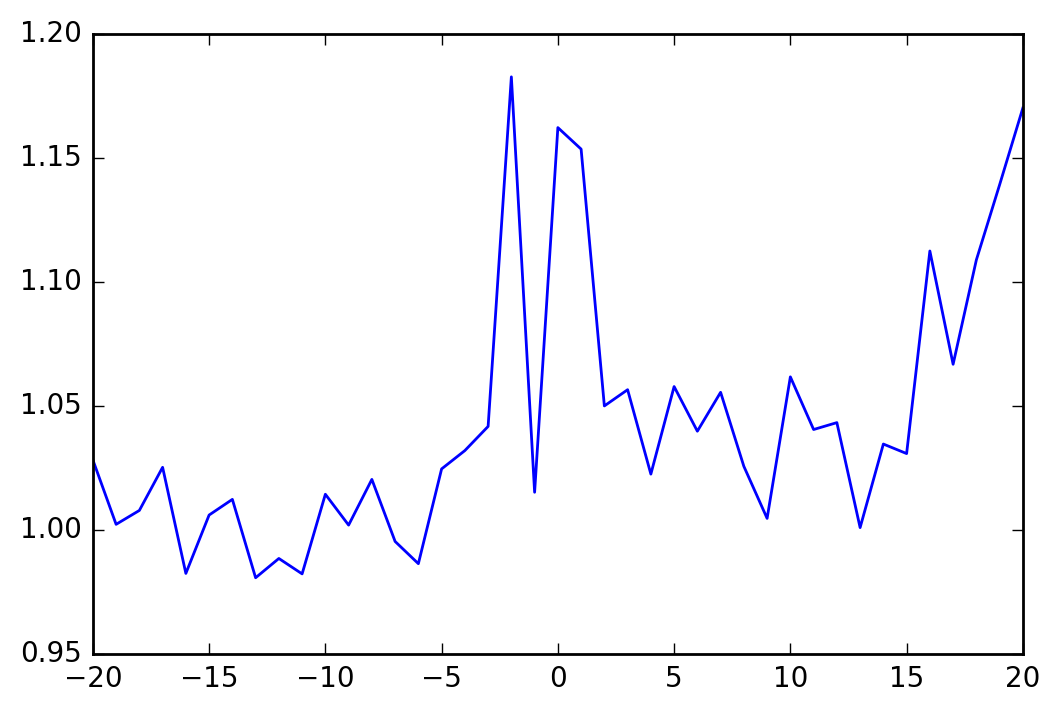

C -20 (1.0291904098502496, 0.26883332608458227)
G -20 (1.0362690476701166, 0.15655726816697407)
C -19 (1.0421812936002681, 0.11089118921325899)
G -19 (1.0028700141474016, 0.91028358419644106)
C -18 (1.0477822264070367, 0.070361519796850208)
G -18 (1.0099918565317774, 0.69543843722989163)
C -17 (1.0240335960220381, 0.35335494748644553)
G -17 (1.0322711729961336, 0.2119317260785078)
C -16 (1.0713771715522058, 0.0069992322305618502)
G -16 (0.97779979149224017, 0.38101028417727612)
C -15 (1.0603130077970413, 0.022824274044008927)
G -15 (1.0076270462048169, 0.77154524272374703)
C -14 (1.0205920587667288, 0.43527349591583758)
G -14 (1.0157168354659789, 0.53708189788286664)
C -13 (1.0493468245811925, 0.071266318804619713)
G -13 (0.97495797130397155, 0.30772534969780135)
C -12 (1.0954180658923014, 0.0005890967884684985)
G -12 (0.98485459332071634, 0.53607114464723682)
C -11 (1.0241045599192291, 0.3424004135872632)
G -11 (0.97725993048149828, 0.3624593465281869)
C -10 (1.0213770007270173, 0.378

In [56]:
# Look at skipped exons!
skipped_idx = np.array([coord in se[chrom] for chrom, coord in zip(a_chroms, a_coords)])
print sum(skipped_idx)
bps = []
for seq, bp in zip(X_all[skipped_idx], np.argmax(y_all[skipped_idx],axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

U_C, U_G = CG(bps, 'Skipped Exons')

# Look at skipped exons!
skipped_idx = np.array([coord in down_se[chrom] for chrom, coord in zip(a_chroms, a_coords)])
print sum(skipped_idx)
d_bps = []
for seq, bp in zip(X_all[skipped_idx], np.argmax(y_all[skipped_idx],axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    d_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
d_bps = np.vstack(d_bps)
print d_bps.shape

D_C, D_G = CG(d_bps, 'Down Skipped Exons')

enrichment(U_C, D_C, U_G, D_G, bps.shape[0], d_bps.shape[0])

6519
(4486, 43, 4)


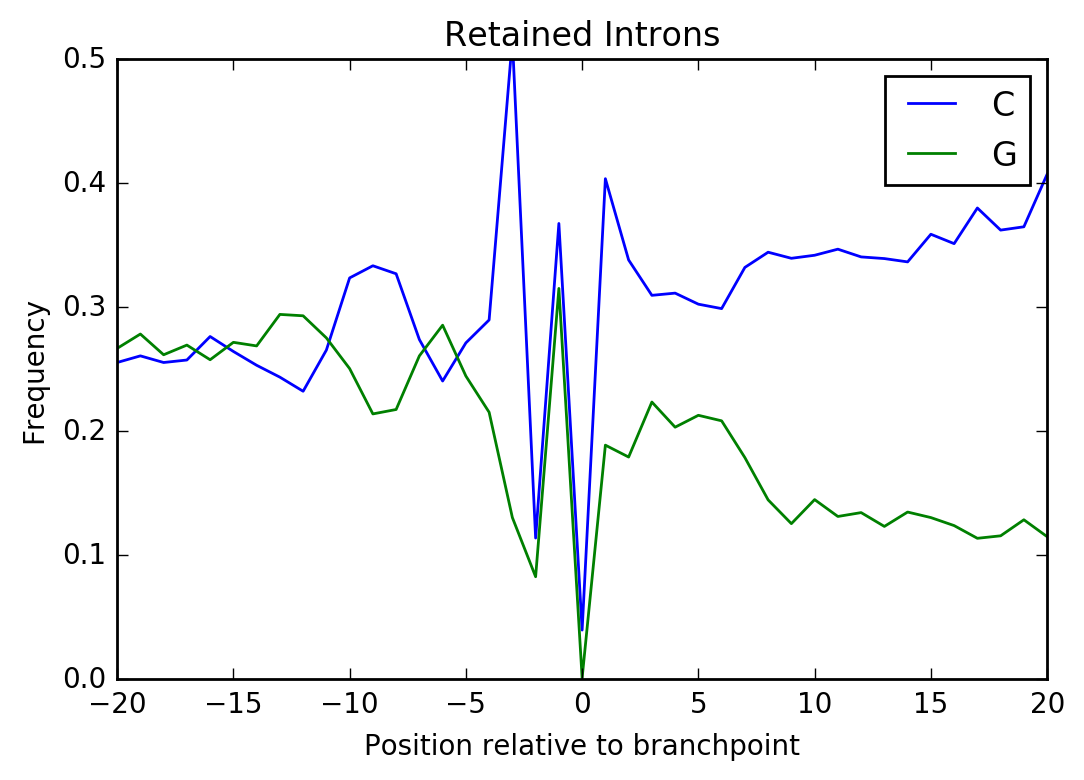

In [55]:
retained_idx = np.array([coord in ri[chrom] for chrom, coord in zip(a_chroms, a_coords)])
print sum(retained_idx)
bps = []
for seq, bp in zip(X_all[retained_idx], np.argmax(y_all[retained_idx],axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

CG(bps, 'Retained Introns');

# 3'ss motifs by motif type

In [61]:
def C_enrichment(counts1, counts2, begin, end):
    c1, n1 = np.sum(counts1[begin:end, 1]), np.sum(counts1[begin:end])
    c2, n2 = np.sum(counts2[begin:end, 1]), np.sum(counts2[begin:end])
    
    print 'Frac 1:', c1 / n1
    print 'Frac 2:', c2 / n2
    print 'Enrichment:', (c1 / n1) / (c2 / n2)
    
    print fisher_exact([[c1, n1-c1],
                        [c2, n2-c2]])

3352


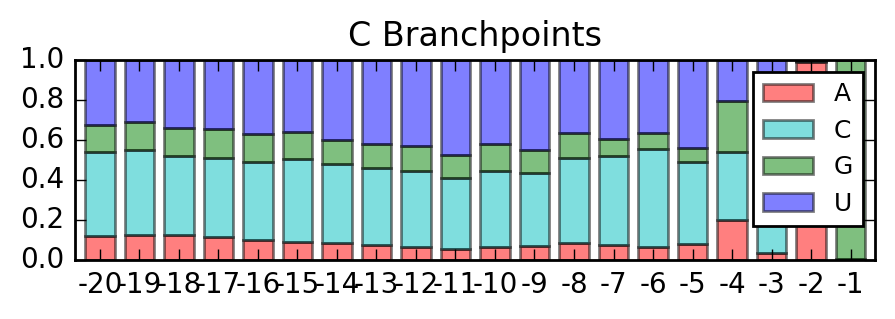

202813


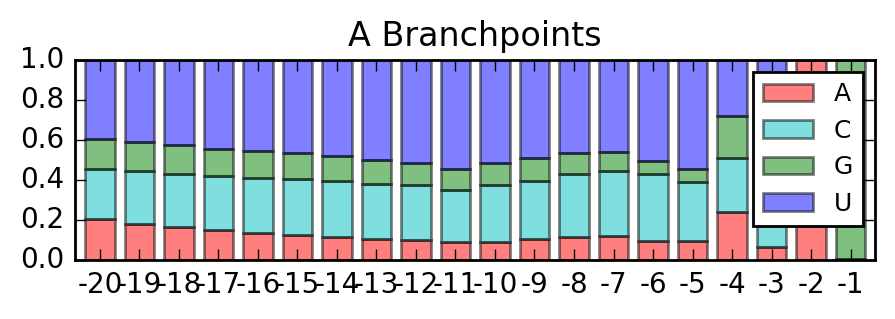

Frac 1: 0.403599840891
Frac 2: 0.282974299807
Enrichment: 1.42627737278
(1.7147506020322136, 0.0)
38927


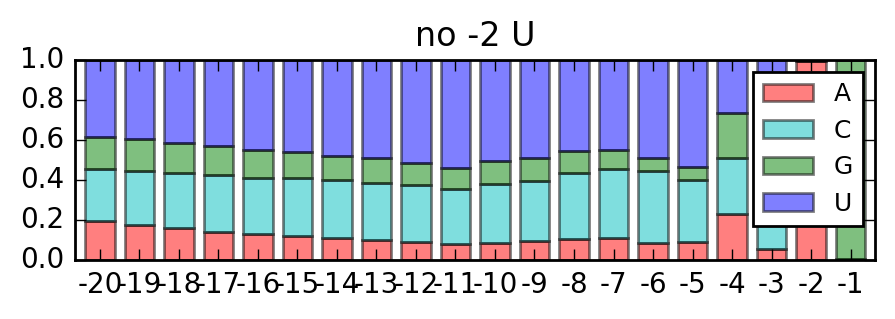

202813


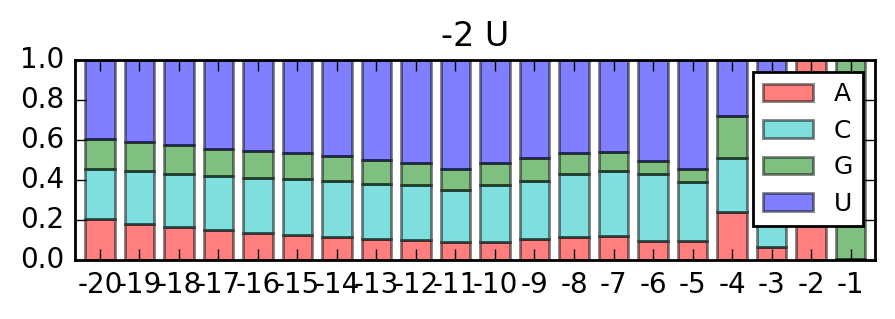

Frac 1: 0.295166165729
Frac 2: 0.282974299807
Enrichment: 1.04308471098
(1.0611274727275604, 2.9396755234657856e-79)


In [76]:
K = 10
counts1 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 1]: continue
    counts1 += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts1 / total, 'C Branchpoints', range(-20, 0), 4)

counts2 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 0]: continue
    counts2 += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts2 / total, 'A Branchpoints', range(-20, 0), 4)

C_enrichment(counts1, counts2, 0, 15)

counts1 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    counts1 += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts1 / total, 'no -2 U', range(-20, 0), 4)

counts2 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp, 0]: continue
    counts2 += seq[-20:, :4]
    total += 1
print total
pwm_logo(counts2 / total, '-2 U', range(-20, 0), 4)

C_enrichment(counts1, counts2, 0, 15)

4840


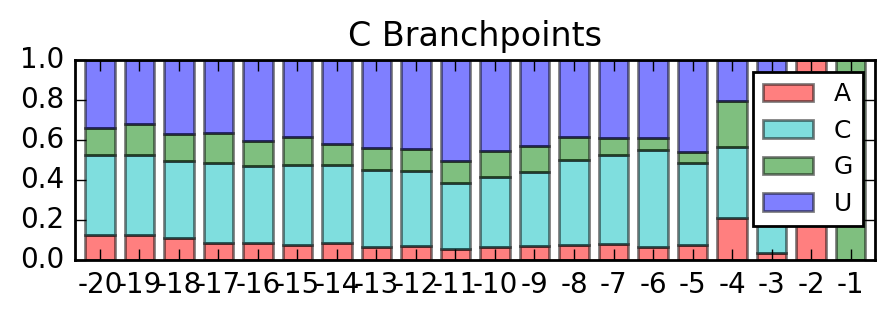

44922


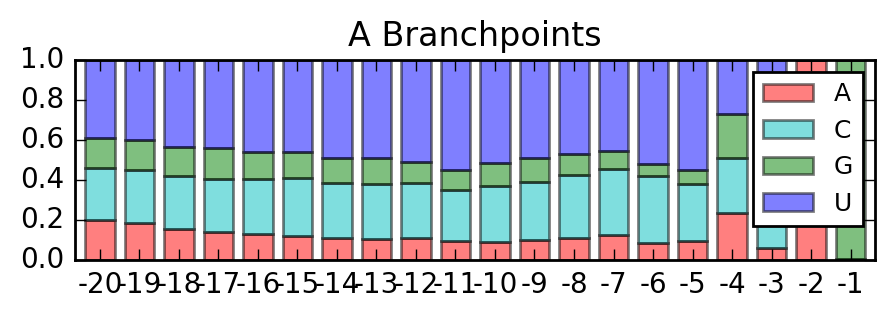

Frac 1: 0.395454545455
Frac 2: 0.284080554443
Enrichment: 1.39205073797
(1.6485049801002596, 0.0)
22601


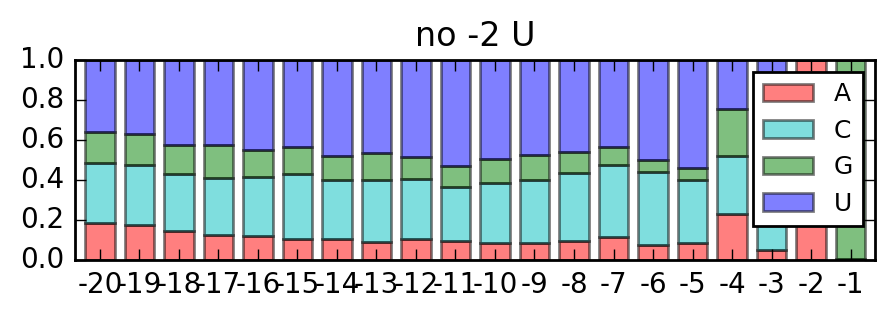

44922


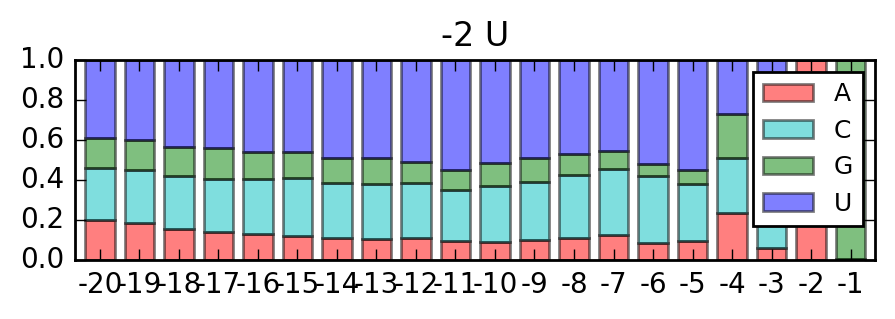

Frac 1: 0.309723758536
Frac 2: 0.284080554443
Enrichment: 1.09026736851
(1.1307699194665766, 5.6499045472650272e-157)


In [78]:
counts1 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 1]: continue
        counts1 += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts1 / total, 'C Branchpoints', range(-20, 0), 4)

counts2 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 0]: continue
        counts2 += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts2 / total, 'A Branchpoints', range(-20, 0), 4)

C_enrichment(counts1, counts2, 0, 15)

counts1 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if seq[bp-2, 3]: continue
        counts1 += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts1 / total, 'no -2 U', range(-20, 0), 4)

counts2 = np.zeros((20, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.array(range(L))[target == 1]:
        if not seq[bp, 0]: continue
        counts2 += seq[-20:, :4]
        total += 1
print total
pwm_logo(counts2 / total, '-2 U', range(-20, 0), 4)

C_enrichment(counts1, counts2, 0, 15)